# Team Based Model

## Imports

In [118]:
import pep8
import autopep8
import sqlite3
import joblib
import optuna
import plotly.graph_objects as go
import plotly.express as px
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
import pickle
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import learning_curve, validation_curve
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Ridge,  LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [120]:
def load_team_data(conn):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    return df


connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection)
connection.close()

In [121]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    df = df.dropna(subset=['E_OFF_RATING'])

    return df


clean_df = clean_team_data(df)
clean_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53875  2021-22  1610612750               MIN  Minnesota Timberwolves   
53876  2021-22  1610612746               LAC             LA Clippers   
53877  2021-22  1610612760               OKC   Oklahoma City Thunder   
53878  2021-22  1610612761               TOR         Toronto Raptors   
53879  2021-22  1610612752               NYK         New York Knicks   

          GAME_ID  GAME_DATE      MATCHUP  WL  MIN  FGM  FGA  FG_PCT  FG3M  \
0      0020000002 2000-10-31    CLE @ BKN   1  240   32   78   0.410     2   
1      0020000002 2000-10-31  BKN vs. CLE   0  240   31   85   0.365     3   
2      0020000008 2000-10-31  HOU vs. MIN   0  240   34   74   0.459     2   
3      0020000008 2000-10-31    MIN @ HOU   1  240   43   88   0.489     6   
4      0020000009 2000-10-31  SAS vs. IND   1  240   33   64   0.516     4   
...           ...        ...          ...  ..  ...  ...  ...     ...   ...   
53875  0022100101 2021-11-01  MIN vs. ORL   0  240   36   97   0.371    14   
53876  0022100102 2021-11-01  LAC vs. OKC   1  240   35   92   0.380    15   
53877  0022100102 2021-11-01    OKC @ LAC   0  240   35   90   0.389    11   
53878  0022100099 2021-11-01    TOR @ NYK   1  240   43   99   0.434    14   
53879  0022100099 2021-11-01  NYK vs. TOR   0  240   35   76   0.461    16   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  \
0         7    0.286   20   32   0.625    11    41   52   16    5    8   19   
1        10    0.300   17   26   0.654    12    35   47   24    9    8   15   
2         9    0.222   28   40   0.700    11    27   38   18    9    7   18   
3        11    0.545   14   16   0.875    13    31   44   29    7    1   16   
4         8    0.500   28   35   0.800     5    32   37   17    6    4   18   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...  ...  ...  ...   
53875    51    0.275   11   19   0.579    16    31   47   21    8    1   14   
53876    42    0.357   14   19   0.737    13    38   51   18    8    5   14   
53877    37    0.297   13   16   0.813    10    41   51   17    8    6   16   
53878    42    0.333   13   14   0.929    13    35   48   24   12    4    9   
53879    38    0.421   18   24   0.750     7    34   41   20    3    4   17   

       PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0      27   86           4          85.9        87.8          82.5   
1      31   82          -4          82.5        83.7          85.9   
2      17   98          -8          99.4       103.2         108.1   
3      25  106           8         108.1       110.4          99.4   
4      22   98          13         106.1       104.3          90.7   
...    ..  ...         ...           ...         ...           ...   
53875  20   97         -18          93.8        98.0         115.9   
53876  14   99           5          97.7       100.0          91.2   
53877  18   94          -5          91.2        94.0          97.7   
53878  20  113           9         111.7       115.3         107.7   
53879  13  104          -9         107.7       107.2         111.7   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0            83.7           3.5         4.1    0.500     0.84       12.6   
1            87.8          -3.5        -4.1    0.774     1.60       17.7   
2           110.4          -8.7        -7.3    0.529     1.00       14.1   
3           103.2           8.7         7.3    0.674     1.81       20.7   
4            90.4          15.4     

In [123]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40', 'MIN'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

#     df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
#                             'PCT_PTS_3PT', 'PCT_PTS_FB',
#                             'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
#                             'PCT_AST_2PM', 'PCT_UAST_2PM',
#                             'PCT_AST_3PM', 'PCT_UAST_3PM',
#                             'PCT_AST_FGM', 'PCT_UAST_FGM',
#                             'FGM', 'FGA'])

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    df = df[['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
             'GAME_DATE', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL',
             'RECORD', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
             'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
             'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
             'E_NET_RATING', 'NET_RATING', 'POSS', 'PIE', 'PTS_2PT_MR',
             'PTS_FB', 'PTS_OFF_TOV', 'PTS_PAINT', 'AST_2PM', 'AST_3PM',
             'UAST_2PM', 'UAST_3PM']]

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53875  2021-22  1610612750               MIN  Minnesota Timberwolves   
53876  2021-22  1610612746               LAC             LA Clippers   
53877  2021-22  1610612760               OKC   Oklahoma City Thunder   
53878  2021-22  1610612761               TOR         Toronto Raptors   
53879  2021-22  1610612752               NYK         New York Knicks   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53875  0022100101 2021-11-01  MIN vs. ORL          1          97         -18   
53876  0022100102 2021-11-01  LAC vs. OKC          1          99           5   
53877  0022100102 2021-11-01    OKC @ LAC          0          94          -5   
53878  0022100099 2021-11-01    TOR @ NYK          0         113           9   
53879  0022100099 2021-11-01  NYK vs. TOR          1         104          -9   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53875   0       0    22    46    14    51   11   19    16    31   47   21   
53876   1       1    20    50    15    42   14   19    13    38   51   18   
53877   0       0    24    53    11    37   13   16    10    41   51   17   
53878   1       1    29    57    14    42   13   14    13    35   48   24   
53879   0       0    19    38    16    38   18   24     7    34   41   20   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53875    8    1   14  20   97         -18          93.8        98.0   
53876    8    5   14  14   99           5          97.7       100.0   
53877    8    6   16  18   94          -5          91.2        94.0   
53878   12    4    9  20  113           9         111.7       115.3   
53879    3    4   17  13  104          -9         107.7       107.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

## Add Betting Data 

In [124]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [125]:
spreads

SEASON     GM_DATE      HOME_TEAM      AWAY_TEAM  AWAY_SCOREBOARD  \
0      2006-07  2006-10-31          Miami        Chicago  22,37,21,28,108   
1      2006-07  2006-10-31    L.A. Lakers        Phoenix  41,17,21,27,106   
2      2006-07  2006-11-02         Dallas    San Antonio   26,19,27,25,97   
3      2006-07  2006-11-02  L.A. Clippers         Denver   24,24,22,25,95   
4      2006-07  2006-11-03        Memphis      Charlotte   21,26,23,13,83   
...        ...         ...            ...            ...              ...   
18982  2021-22  2021-11-01        Atlanta     Washington  23,37,17,34,111   
18983  2021-22  2021-11-01         Boston        Chicago  34,25,30,39,128   
18984  2021-22  2021-11-01        Memphis         Denver   26,32,15,24,97   
18985  2021-22  2021-11-01      Minnesota        Orlando  26,27,19,43,115   
18986  2021-22  2021-11-01  L.A. Clippers  Oklahoma City   23,21,30,20,94   

       HOME_SCOREBOARD                  AWAY_SPREAD  \
0       16,14,21,15,66                -,-,+4½-110,-   
1      26,27,34,27,114                -,-,-8½-110,-   
2       27,24,24,16,91                 -,-,+3-110,-   
3       18,31,16,31,96                -,-,+4½-110,-   
4       24,20,16,36,96                 -,-,+5-110,-   
...                ...                          ...   
18982  34,29,21,34,118    +5½-110,-,+5½-110,+6½-145   
18983  35,32,36,11,114     +2½-110,-,+2-108,+3½-135   
18984  31,29,22,24,106      +1-110,-,+1½-110,-1-110   
18985   32,26,20,19,97      +9-110,-,+9-110,+8½-110   
18986   14,26,26,33,99  +12½-110,-,+13-109,+12½-105   

                       HOME_SPREAD  
0                    -,-,-4½-110,-  
1                    -,-,+8½-110,-  
2                     -,-,-3-110,-  
3                    -,-,-4½-110,-  
4                     -,-,-5-110,-  
...                            ...  
18982    -5½-110,-,-5½-110,-7½+130  
18983     -2½-110,-,-2-113,-4½+105  
18984      -1-110,-,-1½-112,+1-110  
18985      -9-110,-,-9-110,-8½-110  
18986  -12½-110,-,-13-112,-12½-115  

[18987 rows x 8 columns]

In [126]:
moneylines

SEASON     GM_DATE      HOME_TEAM      AWAY_TEAM           AWAY_ML  \
0      2020-21  2020-12-22       Brooklyn   Golden State  +290,+275,+275,-   
1      2020-21  2020-12-22    L.A. Lakers  L.A. Clippers  +110,+110,+120,-   
2      2020-21  2020-12-23      Cleveland      Charlotte  -155,-156,-155,-   
3      2020-21  2020-12-23        Indiana       New York  +270,+300,+265,-   
4      2020-21  2020-12-23        Orlando          Miami  -195,-195,-210,-   
...        ...         ...            ...            ...               ...   
18980  2021-22  2021-11-01        Atlanta     Washington  +175,-,+175,+185   
18981  2021-22  2021-11-01         Boston        Chicago  +120,-,+108,+120   
18982  2021-22  2021-11-01        Memphis         Denver  -110,-,+102,-115   
18983  2021-22  2021-11-01      Minnesota        Orlando  +320,-,+320,+310   
18984  2021-22  2021-11-01  L.A. Clippers  Oklahoma City  +575,-,+750,+560   

                 HOME_ML  
0       -360,-330,-350,-  
1       -130,-130,-140,-  
2       +135,+136,+135,-  
3       -330,-370,-330,-  
4       +170,+170,+175,-  
...                  ...  
18980   -210,-,-210,-235  
18981   -140,-,-129,-140  
18982   -110,-,-121,-105  
18983   -400,-,-420,-400  
18984  -850,-,-1115,-826  

[18985 rows x 6 columns]

In [127]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [128]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [129]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [130]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [131]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: All-NaN axis encountered


In [132]:
# clean_spreads = clean_spreads_df(spreads)

clean_spreads

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_SPREAD  \
0      2006-07  2006-10-31       MIA       CHI                 -4.5   
1      2006-07  2006-10-31       LAL       PHX                  8.5   
2      2006-07  2006-11-02       DAL       SAS                 -3.0   
3      2006-07  2006-11-02       LAC       DEN                 -4.5   
4      2006-07  2006-11-03       MEM       CHA                 -5.0   
...        ...         ...       ...       ...                  ...   
18982  2021-22  2021-11-01       ATL       WAS                 -7.5   
18983  2021-22  2021-11-01       BOS       CHI                 -4.5   
18984  2021-22  2021-11-01       MEM       DEN                  1.5   
18985  2021-22  2021-11-01       MIN       ORL                 -9.0   
18986  2021-22  2021-11-01       LAC       OKC                -13.0   

       HIGHEST_AWAY_SPREAD  
0                      4.5  
1                     -8.5  
2                      3.0  
3                      4.5  
4                      5.0  
...                    ...  
18982                  6.5  
18983                  3.5  
18984                  1.5  
18985                  9.0  
18986                 13.0  

[18987 rows x 6 columns]

In [133]:
clean_mls

SEASON     GM_DATE HOME_TEAM AWAY_TEAM  HIGHEST_HOME_ML  \
0      2020-21  2020-12-22       BKN       GSW         1.277778   
1      2020-21  2020-12-22       LAL       LAC         1.714286   
2      2020-21  2020-12-23       CLE       CHA         2.360000   
3      2020-21  2020-12-23       IND       NYK         1.270270   
4      2020-21  2020-12-23       ORL       MIA         2.750000   
...        ...         ...       ...       ...              ...   
18980  2021-22  2021-11-01       ATL       WAS         1.425532   
18981  2021-22  2021-11-01       BOS       CHI         1.714286   
18982  2021-22  2021-11-01       MEM       DEN         1.826446   
18983  2021-22  2021-11-01       MIN       ORL         1.238095   
18984  2021-22  2021-11-01       LAC       OKC         1.089686   

       HIGHEST_AWAY_ML  
0             3.900000  
1             2.200000  
2             1.641026  
3             4.000000  
4             1.476190  
...                ...  
18980         2.850000  
18981         2.200000  
18982         2.150000  
18983         4.200000  
18984         8.500000  

[18985 rows x 6 columns]

In [134]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [135]:
merged_df

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612739               CLE     Cleveland Cavaliers   
1      2000-01  1610612751               BKN         New Jersey Nets   
2      2000-01  1610612745               HOU         Houston Rockets   
3      2000-01  1610612750               MIN  Minnesota Timberwolves   
4      2000-01  1610612759               SAS       San Antonio Spurs   
...        ...         ...               ...                     ...   
53873  2021-22  1610612750               MIN  Minnesota Timberwolves   
53874  2021-22  1610612746               LAC             LA Clippers   
53875  2021-22  1610612760               OKC   Oklahoma City Thunder   
53876  2021-22  1610612761               TOR         Toronto Raptors   
53877  2021-22  1610612752               NYK         New York Knicks   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  POINT_DIFF  \
0      0020000002 2000-10-31    CLE @ BKN          0          86           4   
1      0020000002 2000-10-31  BKN vs. CLE          1          82          -4   
2      0020000008 2000-10-31  HOU vs. MIN          1          98          -8   
3      0020000008 2000-10-31    MIN @ HOU          0         106           8   
4      0020000009 2000-10-31  SAS vs. IND          1          98          13   
...           ...        ...          ...        ...         ...         ...   
53873  0022100101 2021-11-01  MIN vs. ORL          1          97         -18   
53874  0022100102 2021-11-01  LAC vs. OKC          1          99           5   
53875  0022100102 2021-11-01    OKC @ LAC          0          94          -5   
53876  0022100099 2021-11-01    TOR @ NYK          0         113           9   
53877  0022100099 2021-11-01  NYK vs. TOR          1         104          -9   

       WL  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  AST  \
0       1       1    30    71     2     7   20   32    11    41   52   16   
1       0       0    28    75     3    10   17   26    12    35   47   24   
2       0       0    32    65     2     9   28   40    11    27   38   18   
3       1       1    37    77     6    11   14   16    13    31   44   29   
4       1       1    29    56     4     8   28   35     5    32   37   17   
...    ..     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...  ...   
53873   0       0    22    46    14    51   11   19    16    31   47   21   
53874   1       1    20    50    15    42   14   19    13    38   51   18   
53875   0       0    24    53    11    37   13   16    10    41   51   17   
53876   1       1    29    57    14    42   13   14    13    35   48   24   
53877   0       0    19    38    16    38   18   24     7    34   41   20   

       STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        5    8   19  27   86           4          85.9        87.8   
1        9    8   15  31   82          -4          82.5        83.7   
2        9    7   18  17   98          -8          99.4       103.2   
3        7    1   16  25  106           8         108.1       110.4   
4        6    4   18  22   98          13         106.1       104.3   
...    ...  ...  ...  ..  ...         ...           ...         ...   
53873    8    1   14  20   97         -18          93.8        98.0   
53874    8    5   14  14   99           5          97.7       100.0   
53875    8    6   16  18   94          -5          91.2        94.0   
53876   12    4    9  20  113           9         111.7       115.3   
53877    3    4   17  13  104          -9         107.7       107.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING   POSS    PIE  \
0              82.5        83.7           3.5         4.1   98.0  0.512   
1              85.9        87.8          -3.5        -4.1   98.0  0.488   
2             108.1       110.4          -8.7        -7.3   95.0  0.446   
3              99.4       103.2           8.7         7.3   96.0  0.554   
4              90.7        90

In [136]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'TEAM_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 
                             'POINT_DIFF_opp', 'WL_opp',
                             'ML_opp', 'SPREAD_opp', 'OFF_RATING_team',
                             'DEF_RATING_team', 'NET_RATING_team', 'OFF_RATING_opp',
                             'DEF_RATING_opp', 'NET_RATING_opp']
                 )
    
    return matchups


matchups = create_matchups(merged_df)

In [137]:
matchups

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1          2000-01    1610612739                    CLE   
2          2000-01    1610612751                    BKN   
5          2000-01    1610612745                    HOU   
6          2000-01    1610612750                    MIN   
9          2000-01    1610612759                    SAS   
...            ...           ...                    ...   
107746     2021-22    1610612750                    MIN   
107749     2021-22    1610612746                    LAC   
107750     2021-22    1610612760                    OKC   
107753     2021-22    1610612761                    TOR   
107754     2021-22    1610612752                    NYK   

                TEAM_NAME_team     GAME_ID GAME_DATE_team MATCHUP_team  \
1          Cleveland Cavaliers  0020000002     2000-10-31    CLE @ BKN   
2              New Jersey Nets  0020000002     2000-10-31  BKN vs. CLE   
5              Houston Rockets  0020000008     2000-10-31  HOU vs. MIN   
6       Minnesota Timberwolves  0020000008     2000-10-31    MIN @ HOU   
9            San Antonio Spurs  0020000009     2000-10-31  SAS vs. IND   
...                        ...         ...            ...          ...   
107746  Minnesota Timberwolves  0022100101     2021-11-01  MIN vs. ORL   
107749             LA Clippers  0022100102     2021-11-01  LAC vs. OKC   
107750   Oklahoma City Thunder  0022100102     2021-11-01    OKC @ LAC   
107753         Toronto Raptors  0022100099     2021-11-01    TOR @ NYK   
107754         New York Knicks  0022100099     2021-11-01  NYK vs. TOR   

        HOME_GAME_team  TEAM_SCORE_team  POINT_DIFF_team  WL_team  \
1                    0               86                4        1   
2                    1               82               -4        0   
5                    1               98               -8        0   
6                    0              106                8        1   
9                    1               98               13        1   
...                ...              ...              ...      ...   
107746               1               97              -18        0   
107749               1               99                5        1   
107750               0               94               -5        0   
107753               0              113                9        1   
107754               1              104               -9        0   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 1         30         71          2          7        20   
2                 0         28         75          3         10        17   
5                 0         32         65          2          9        28   
6                 1         37         77          6         11        14   
9                 1         29         56          4          8        28   
...             ...        ...        ...        ...        ...       ...   
107746            0         22         46         14         51        11   
107749            1         20         50         15         42        14   
107750            0         24         53         11         37        13   
107753            1         29         57         14         42        13   
107754            0         19         38         16         38        18   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             32         11         41        52        16         5   
2             26         12         35        47        24         9   
5             40         11         27        38        18         9   
6             16         13         31        44        29         7   
9             35          5         32        37        17         6   
...          ...        ...        ...       ...       ...       ...   
107746        19         16         31        47        21         8   
107749        19         13         38        51        18         8   
107750 

In [138]:
def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []
    for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
                'GAME_DATE_team')

            avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

            avg_ml = team_df['ML_team'].shift(1).expanding().mean()

            record = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec = team_df['TEAM_COVERED_team'].shift(
                1).expanding().mean()

            ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
                1).expanding().mean()

            records = pd.DataFrame({'WL_PCT': record,
                                   'ATS_PCT': ATS_rec,
                                    'AVG_SPREAD': avg_spread,
                                    'AVG_ML': avg_ml,
                                    'AVG_ATS_DIFF': ATS_avg_diff
                                    })

            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
                1).ewm(alpha=alpha, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)

            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df


avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:19<00:00,  1.12it/s]


In [139]:
avg_data_ewm_19

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team        TEAM_NAME_team  \
0         2000-01    1610612739                    CLE   Cleveland Cavaliers   
1         2000-01    1610612739                    CLE   Cleveland Cavaliers   
2         2000-01    1610612739                    CLE   Cleveland Cavaliers   
3         2000-01    1610612739                    CLE   Cleveland Cavaliers   
4         2000-01    1610612739                    CLE   Cleveland Cavaliers   
...           ...           ...                    ...                   ...   
53873     2021-22    1610612740                    NOP  New Orleans Pelicans   
53874     2021-22    1610612740                    NOP  New Orleans Pelicans   
53875     2021-22    1610612740                    NOP  New Orleans Pelicans   
53876     2021-22    1610612740                    NOP  New Orleans Pelicans   
53877     2021-22    1610612740                    NOP  New Orleans Pelicans   

          GAME_ID GAME_DATE_team MATCHUP_team  HOME_GAME_team  \
0      0020000002     2000-10-31    CLE @ BKN               0   
1      0020000018     2000-11-01  CLE vs. SAC               1   
2      0020000038     2000-11-04  CLE vs. BOS               1   
3      0020000061     2000-11-08    CLE @ NYK               0   
4      0020000081     2000-11-10    CLE @ TOR               0   
...           ...            ...          ...             ...   
53873  0022100031     2021-10-23    NOP @ MIN               0   
53874  0022100047     2021-10-25    NOP @ MIN               0   
53875  0022100059     2021-10-27  NOP vs. ATL               1   
53876  0022100074     2021-10-29  NOP vs. SAC               1   
53877  0022100080     2021-10-30  NOP vs. NYK               1   

       TEAM_SCORE_team  POINT_DIFF_team  WL_team  ML_team  SPREAD_team  \
0                   86                4        1      NaN          NaN   
1                  102                2        1      NaN          NaN   
2                   91                2        1      NaN          NaN   
3                   99                2        1      NaN          NaN   
4                   88              -27        0      NaN          NaN   
...                ...              ...      ...      ...          ...   
53873               89               -7        0     3.40          9.5   
53874              107                9        1     2.85          6.0   
53875               99               -3        0     2.85          6.0   
53876              109               -4        0     2.06          1.5   
53877              117               -6        0     3.90          9.5   

       TEAM_COVERED_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0          NaN        NaN        NaN        NaN   
1                      0     1.000000  30.000000  71.000000   2.000000   
2                      0     1.000000  35.263158  76.789474   0.947368   
3                      0     1.000000  33.321033  69.856089   0.966790   
4                      0     1.000000  33.809247  68.444024   2.430358   
...                  ...          ...        ...        ...        ...   
53873                  1     0.000000  26.526316  60.368421  14.052632   
53874                  1     0.000000  24.856089  56.173432  12.188192   
53875                  1     0.290782  26.061064  56.413783  11.551905   
53876                  0     0.219775  26.778736  56.556934  11.417133   
53877                  1     0.172870  28.106480  58.145435  10.901268   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1       7.000000  20.000000  32.000000  11.000000  41.000000  52.000000   
2       5.421053  21.052632  30.421053  14.157895  37.315789  51.473684   
3       6.741697  23.616236  32.848708  12.623616  34.616236  47.239852   
4       6.816807  19.947659  29.403315  11.569933  30.075313  41.645246   
...          ...        ...        .

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [140]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df


def add_rest_days(df):
    df['REST'] = np.nan

    for season in df['SEASON_team'].unique():
        season_df = df.loc[df['SEASON_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['REST'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'REST'] = team_df['REST']
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
            
    return df

In [141]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [183]:
# home_teams = full_df_ewm_19.loc[full_df_ewm_19['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
# away_teams = full_df_ewm_19.loc[full_df_ewm_19['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


df_ewm_19 = pd.merge(full_df_ewm_19, full_df_ewm_19, on=['GAME_ID'])
df_ewm_19 = df_ewm_19.loc[df_ewm_19['TEAM_ABBREVIATION_team_x'] != df_ewm_19['TEAM_ABBREVIATION_team_y']]
df_ewm_19 = df_ewm_19.dropna(subset=['ML_team_x', 'SPREAD_team_x'])
df_ewm_19

SEASON_team_x  TEAM_ID_team_x TEAM_ABBREVIATION_team_x  \
30801        2006-07      1610612739                      CLE   
30802        2006-07      1610612764                      WAS   
30825        2006-07      1610612739                      CLE   
30826        2006-07      1610612752                      NYK   
30833        2006-07      1610612739                      CLE   
...              ...             ...                      ...   
107746       2021-22      1610612760                      OKC   
107749       2021-22      1610612763                      MEM   
107750       2021-22      1610612748                      MIA   
107753       2021-22      1610612763                      MEM   
107754       2021-22      1610612743                      DEN   

             TEAM_NAME_team_x     GAME_ID GAME_DATE_team_x MATCHUP_team_x  \
30801     Cleveland Cavaliers  0020600009       2006-11-01    CLE vs. WAS   
30802      Washington Wizards  0020600009       2006-11-01      WAS @ CLE   
30825     Cleveland Cavaliers  0020600099       2006-11-13      CLE @ NYK   
30826         New York Knicks  0020600099       2006-11-13    NYK vs. CLE   
30833     Cleveland Cavaliers  0020600122       2006-11-17    CLE vs. MIN   
...                       ...         ...              ...            ...   
107746  Oklahoma City Thunder  0022100086       2021-10-30      OKC @ GSW   
107749      Memphis Grizzlies  0022100084       2021-10-30    MEM vs. MIA   
107750             Miami Heat  0022100084       2021-10-30      MIA @ MEM   
107753      Memphis Grizzlies  0022100100       2021-11-01    MEM vs. DEN   
107754         Denver Nuggets  0022100100       2021-11-01      DEN @ MEM   

        HOME_GAME_team_x  TEAM_SCORE_team_x  POINT_DIFF_team_x  WL_team_x  \
30801                  1                 97                  3          1   
30802                  0                 94                 -3          0   
30825                  0                102                  6          1   
30826                  1                 96                 -6          0   
30833                  1                 92                 16          1   
...                  ...                ...                ...        ...   
107746                 0                 82                -21          0   
107749                 1                103                -26          0   
107750                 0                129                 26          1   
107753                 1                106                  9          1   
107754                 0                 97                 -9          0   

        ML_team_x  SPREAD_team_x  TEAM_COVERED_team_x  RECORD_team_x  \
30801    1.400000           -6.5                    0            NaN   
30802    3.100000            6.5                    1            NaN   
30825    1.444444           -5.5                    1       0.671546   
30826    2.850000            5.5                    0       0.257127   
30833    1.370370           -6.0                    1       0.781121   
...           ...            ...                  ...            ...   
107746   7.500000           12.5                    0       0.244194   
107749   1.606061           -5.5                    0       0.582428   
107750   2.400000            5.5                    1       0.821982   
107753   1.826446            1.5                    1       0.458126   
107754   2.150000           -1.5                    0       0.671546   

        FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  FTM_team_x  \
30801           NaN          NaN          NaN          NaN         NaN   
30802           NaN          NaN          NaN          NaN         NaN   
30825     28.461541    60.928807     5.987148    17.434562   21.542250   
30826     30.836104    64.591003     4.869877    14.768709   21.868166   
30833     28.342684    58.722660     6.272367    18.272851   22.432405   
...             ...          ...          ...          ...         

In [24]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [114]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53823  2021-22  1610612743               DEN          Denver Nuggets   
53824  2021-22  1610612746               LAC             LA Clippers   
53825  2021-22  1610612757               POR  Portland Trail Blazers   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53823  0022100075 2021-10-29  DEN vs. DAL          1         106   
53824  0022100076 2021-10-29    LAC @ POR          0          92   
53825  0022100076 2021-10-29  POR vs. LAC          1         111   
53826  0022100077 2021-10-29    CLE @ LAL          0         101   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53823               31        1  1.588235         -4.0                  1   
53824              -19        0  2.400000          5.5                  0   
53825               19        1  1.606061         -5.5                  1   
53826              -12        0  3.800000         10.0                  0   
53827               12        1  1.277778        -10.0                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53823         -0.340506        5.807211        3.052050       -3.441117   
53824         -0.264612       -0.071242        3.548124       -1.634778   
53825          0.264612        0.071242       -3.548124        1.634778   
53826          0.244194       -3.850138       -6.258651       -5.715880   
53827         -0.244194        3.850138        6.258651        5.715880   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
538

In [184]:
df_ewm_19 = df_ewm_19.rename(columns = {'SEASON_team_x':'SEASON', 
                               'TEAM_ABBREVIATION_team_x':'TEAM_ABBREVIATION',
                           'GAME_DATE_team_x':'GAME_DATE',
                           'HOME_GAME_team_x':'HOME_GAME',
                           'TEAM_SCORE_team_x':'SCORE_team',
                           'POINT_DIFF_team_x':'POINT_DIFF_team',
                                       'MATCHUP_team_x':'MATCHUP'})

df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION       TEAM_NAME_team_x  \
30801   2006-07      1610612739               CLE    Cleveland Cavaliers   
30802   2006-07      1610612764               WAS     Washington Wizards   
30825   2006-07      1610612739               CLE    Cleveland Cavaliers   
30826   2006-07      1610612752               NYK        New York Knicks   
30833   2006-07      1610612739               CLE    Cleveland Cavaliers   
...         ...             ...               ...                    ...   
107746  2021-22      1610612760               OKC  Oklahoma City Thunder   
107749  2021-22      1610612763               MEM      Memphis Grizzlies   
107750  2021-22      1610612748               MIA             Miami Heat   
107753  2021-22      1610612763               MEM      Memphis Grizzlies   
107754  2021-22      1610612743               DEN         Denver Nuggets   

           GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
30801   0020600009 2006-11-01  CLE vs. WAS          1          97   
30802   0020600009 2006-11-01    WAS @ CLE          0          94   
30825   0020600099 2006-11-13    CLE @ NYK          0         102   
30826   0020600099 2006-11-13  NYK vs. CLE          1          96   
30833   0020600122 2006-11-17  CLE vs. MIN          1          92   
...            ...        ...          ...        ...         ...   
107746  0022100086 2021-10-30    OKC @ GSW          0          82   
107749  0022100084 2021-10-30  MEM vs. MIA          1         103   
107750  0022100084 2021-10-30    MIA @ MEM          0         129   
107753  0022100100 2021-11-01  MEM vs. DEN          1         106   
107754  0022100100 2021-11-01    DEN @ MEM          0          97   

        POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
30801                 3          1   1.400000           -6.5   
30802                -3          0   3.100000            6.5   
30825                 6          1   1.444444           -5.5   
30826                -6          0   2.850000            5.5   
30833                16          1   1.370370           -6.0   
...                 ...        ...        ...            ...   
107746              -21          0   7.500000           12.5   
107749              -26          0   1.606061           -5.5   
107750               26          1   2.400000            5.5   
107753                9          1   1.826446            1.5   
107754               -9          0   2.150000           -1.5   

        TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
30801                     0            NaN          NaN          NaN   
30802                     1            NaN          NaN          NaN   
30825                     1       0.671546    28.461541    60.928807   
30826                     0       0.257127    30.836104    64.591003   
30833                     1       0.781121    28.342684    58.722660   
...                     ...            ...          ...          ...   
107746                    0       0.244194    26.327733    51.394007   
107749                    0       0.582428    27.933604    55.279407   
107750                    1       0.821982    32.214989    60.365827   
107753                    1       0.458126    25.813571    51.591631   
107754                    0       0.671546    29.789361    50.274386   

        FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
30801           NaN          NaN         NaN         NaN          NaN   
30802           NaN          NaN         NaN         NaN          NaN   
30825      5.987148    17.434562   21.542250   32.692937    11.668464   
30826      4.869877    14.768709   21.868166   29.703396    10.754494   
30833      6.272367    18.272851   22.432405   32.848050    11.427902   
...             ...          ...         ...         ...          ...   
107746    11.496349    35.901565   14.780616   20.308124     9.434080   
107749    14.151156    41.328734   14.024615   17

## Add ELO Rating

In [147]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [148]:
# full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
#                             'SEASON_ID_team':'SEASON_ID',
#                             'TEAM_ID_team': 'TEAM_ID',
#                             'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
#                             'TEAM_NAME_team': 'TEAM_NAME',
#                             'GAME_DATE_team': 'GAME_DATE',
#                             'MATCHUP_team': 'MATCHUP',
#                             'HOME_GAME_team': 'HOME_GAME',
#                             'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [149]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [185]:
df_ewm_19 = add_elo_ratings(df_ewm_19)

progress:: 34144it [01:07, 507.59it/s]


In [186]:
df_ewm_19.loc[df_ewm_19['TEAM_ABBREVIATION']=='CHI'].sort_values('GAME_DATE')

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION TEAM_NAME_team_x     GAME_ID  \
0      2006-07      1610612741               CHI    Chicago Bulls  0020600001   
30     2006-07      1610612741               CHI    Chicago Bulls  0020600026   
134    2006-07      1610612741               CHI    Chicago Bulls  0020600156   
181    2006-07      1610612741               CHI    Chicago Bulls  0020600207   
200    2006-07      1610612741               CHI    Chicago Bulls  0020600228   
...        ...             ...               ...              ...         ...   
33998  2021-22      1610612741               CHI    Chicago Bulls  0022100030   
34030  2021-22      1610612741               CHI    Chicago Bulls  0022100046   
34073  2021-22      1610612741               CHI    Chicago Bulls  0022100067   
34105  2021-22      1610612741               CHI    Chicago Bulls  0022100083   
34134  2021-22      1610612741               CHI    Chicago Bulls  0022100098   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  POINT_DIFF_team  \
0     2006-10-31    CHI @ MIA          0         108               42   
30    2006-11-03  CHI vs. SAC          1          88               -1   
134   2006-11-21    CHI @ DEN          0         109               -4   
181   2006-11-28  CHI vs. NYK          1         102               17   
200   2006-12-01    CHI @ NOP          0         111                3   
...          ...          ...        ...         ...              ...   
33998 2021-10-23  CHI vs. DET          1          97               15   
34030 2021-10-25    CHI @ TOR          0         111                3   
34073 2021-10-28  CHI vs. NYK          1         103               -1   
34105 2021-10-30  CHI vs. UTA          1         107                8   
34134 2021-11-01    CHI @ BOS          0         128               14   

       WL_team_x  ML_team_x  SPREAD_team_x  TEAM_COVERED_team_x  \
0              1   2.800000            4.5                    1   
30             0   1.416667           -6.0                    0   
134            0   2.300000            3.0                    0   
181            1   1.333333           -7.0                    1   
200            1   1.666667           -3.5                    0   
...          ...        ...            ...                  ...   
33998          1   1.285714           -9.0                    1   
34030          1   1.689655           -4.0                    0   
34073          0   1.826446           -3.0                    0   
34105          1   2.380000            3.5                    1   
34134          1   2.200000            4.5                    1   

       RECORD_team_x  FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  \
0                NaN          NaN          NaN          NaN          NaN   
30          0.473684    31.473684    63.894737     6.473684    16.684211   
134         0.241810    29.462037    66.318306     5.578746    14.555243   
181         0.288027    30.651058    65.612686     5.814944    15.721123   
200         0.380344    30.566640    66.051894     5.968602    15.627621   
...              ...          ...          ...          ...          ...   
33998       1.000000    31.578947    61.947368    10.684211    25.631579   
34030       1.000000    28.782288    60.490775    10.800738    25.767528   
34073       1.000000    28.264030    58.603373    11.149462    26.125909   
34105       0.755806    27.466973    56.990867    11.112964    27.560328   
34134       0.807922    28.861253    59.767280     9.808334    26.160221   

       FTM_team_x  FTA_team_x  OREB_team_x  DREB_team_x  REB_team_x  \
0             NaN         NaN          NaN          NaN         NaN   
30      18.263158   27.789474    11.947368    25.473684   37.421053   
134     15.941743   23.497582    12.489707    27.481669   39.971376   
181     18.653933   26.448930    12.397578    27.995830   40.393408   
200     18.958130   26.650046    12.994341    28.385358   41.379699   
...           

In [31]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

In [32]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

{'MIL': 1728.3633862833926,
 'PHX': 1719.5375580768125,
 'LAC': 1697.9465766106773,
 'UTA': 1679.950559925344,
 'PHI': 1661.3481248151209,
 'BKN': 1660.3020409855592,
 'DEN': 1613.7815626338604,
 'POR': 1612.3491677106474,
 'ATL': 1595.7093515943002,
 'LAL': 1566.8313196978793,
 'DAL': 1565.643688070191,
 'NYK': 1562.349322237786,
 'GSW': 1544.2762089443431,
 'MEM': 1543.8515399762978,
 'MIA': 1517.7969526315635,
 'BOS': 1493.8585537183362,
 'CHI': 1479.594002983012,
 'IND': 1478.5440665487745,
 'WAS': 1469.2351122552523,
 'SAS': 1464.1243150098553,
 'NOP': 1459.5087263936541,
 'TOR': 1438.3069260920208,
 'SAC': 1435.9282200085781,
 'CHA': 1416.6217041038497,
 'MIN': 1394.0312381538074,
 'DET': 1317.853574213266,
 'CLE': 1276.9765081239782,
 'HOU': 1266.4192978976585,
 'ORL': 1252.3135857552807,
 'OKC': 1216.63822299864}

## Helper Functions for Bet Simulations

In [73]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'spread_pred_diff']) > 7:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 6:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 5:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'spread_pred_diff']) > 4:
            bet_size = 2
        else:
            bet_size = 0
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [68]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [69]:
# # Find ranges of model probability where the win percentage is higher than 52.8
# def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
#     """
#     INPUTS:
#     test_preds: array of class predictions
#     test_indices: indices of full df for the test set 
#     OUTPUTS:
#     select_bets: df of bets at the optimal thresholds
#     best_thresholds: tuple of lower and upper thresholds
    
#     """
#     betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
#                                                  'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
#                                                  'point_diff_team_x']]
#     betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
#                                'HOME_GAME_x':'HOME_GAME',
#                                'spread_team_x':'spread', 
#                               'ml_team_x':'ml', 
#                               'SCORE_team_x':'team_score', 
#                               'point_diff_team_x':'point_diff'}, inplace=True)


#     betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

#     betting_df['diff_preds'] = diff_preds

#     home_df = betting_df.loc[betting_df['HOME_GAME']==1]
#     away_df = betting_df.loc[betting_df['HOME_GAME']==0]

#     betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

#     betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
#                                  'ml_home', 'ml_away', 'point_diff_home', 
#                                  'cover_home', 'diff_preds_home', 
#                              'diff_preds_away']]

#     betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

#     betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
#     betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

#     betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

#     betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
#     betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
#     betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


#     betting_df['bankroll_i'] = np.nan
#     betting_df['bankroll_n'] = np.nan
#     betting_df['bankroll_i'].iloc[0] = 10000
#     betting_df['bet_size'] = np.nan
        
#     prediction_num = []
#     confidence_threshold = []
#     win_percentages = []
#     num_games_bet = []
#     expected_profits = []
    
#     for num in range(1, 4):
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

#         for i in range(1, 1001):
#             select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
#             win_pct = select_bets['bet_won'].mean()
#             num_games = select_bets.shape[0]
#             confidence_threshold.append(i/100)
#             win_percentages.append(win_pct)
#             num_games_bet.append(num_games)
#             bets_won = select_bets['bet_won'].sum()
#             bets_lost = num_games - bets_won
#             expected_profit = (bets_won*100 + bets_lost*-108)
#             expected_profits.append(expected_profit)
#             prediction_num.append(num)
        

#     confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
#                                         'confidence_thresholds':confidence_threshold, 
#                                        'num_games_bet':num_games_bet, 
#                                        'win_percentage':win_percentages,
#                                          'expected_profits':expected_profits})
    
#     confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
#     confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
#                                       ascending=[False, True], inplace=True)
#     confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
#     print('DONE')

#     try:
#         best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
#         print("best threshold:", best_threshold)
#         best_num = confidence_thresholds.loc[0, 'prediction_num']
#         print("best prediction strat:", best_num)
#         betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
#         select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
#         print("num_games_bet:", select_bets.shape[0])
#         print("win percetange at threshold:", select_bets['bet_won'].mean())
#     except:
#         print("no best threshold")
#         select_bets = betting_df
   
    
#     return select_bets, confidence_thresholds
    

In [211]:
df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
0      2006-07      1610612741               CHI           Chicago Bulls   
1      2006-07      1610612748               MIA              Miami Heat   
2      2006-07      1610612747               LAL      Los Angeles Lakers   
3      2006-07      1610612756               PHX            Phoenix Suns   
4      2006-07      1610612755               PHI      Philadelphia 76ers   
...        ...             ...               ...                     ...   
34139  2021-22      1610612743               DEN          Denver Nuggets   
34140  2021-22      1610612750               MIN  Minnesota Timberwolves   
34141  2021-22      1610612753               ORL           Orlando Magic   
34142  2021-22      1610612746               LAC             LA Clippers   
34143  2021-22      1610612760               OKC   Oklahoma City Thunder   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020600001 2006-10-31    CHI @ MIA          0         108   
1      0020600001 2006-10-31  MIA vs. CHI          1          66   
2      0020600002 2006-10-31  LAL vs. PHX          1         114   
3      0020600002 2006-10-31    PHX @ LAL          0         106   
4      0020600003 2006-11-01  PHI vs. ATL          1          88   
...           ...        ...          ...        ...         ...   
34139  0022100100 2021-11-01    DEN @ MEM          0          97   
34140  0022100101 2021-11-01  MIN vs. ORL          1          97   
34141  0022100101 2021-11-01    ORL @ MIN          0         115   
34142  0022100102 2021-11-01  LAC vs. OKC          1          99   
34143  0022100102 2021-11-01    OKC @ LAC          0          94   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0                   42          1   2.800000            4.5   
1                  -42          0   1.454545           -4.5   
2                    8          1   3.900000            8.5   
3                   -8          0   1.263158           -8.5   
4                   13          1   1.416667           -6.0   
...                ...        ...        ...            ...   
34139               -9          0   2.150000           -1.5   
34140              -18          0   1.238095           -9.0   
34141               18          1   4.200000            9.0   
34142                5          1   1.089686          -13.0   
34143               -5          0   8.500000           13.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        1            NaN          NaN          NaN   
1                        0            NaN          NaN          NaN   
2                        1            NaN          NaN          NaN   
3                        0            NaN          NaN          NaN   
4                        1            NaN          NaN          NaN   
...                    ...            ...          ...          ...   
34139                    0       0.671546    29.789361    50.274386   
34140                    0       0.558008    24.102366    47.918464   
34141                    1       0.125761    23.289244    48.301273   
34142                    0       0.197797    25.235232    50.641401   
34143                    1       0.192078    25.190687    49.815976   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0              NaN          NaN         NaN         NaN          NaN   
1              NaN          NaN         NaN         NaN          NaN   
2              NaN          NaN         NaN         NaN          NaN   
3              NaN          NaN         NaN         NaN          NaN   
4              NaN          NaN         NaN         NaN          NaN   
...            ...          ...         ...         ...          ...   
34139    10.565207    34.679541    9.630580   14.182037     8.400381   
34140    13.698225    42.644575   14.097434   18.021318    12.433469   
34141    14.182875  

In [214]:
def create_betting_df(df, preds, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team_x':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team_x':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['pred'] = preds
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'pred_home', 'pred_away']]

    betting_df['pred_avg'] = (betting_df['pred_home'] - betting_df['pred_away'])/2

    betting_df['bet_home'] = (betting_df['pred_avg'] + betting_df['SPREAD_home'] > 0).astype(int)
    
    betting_df['spread_pred_diff'] = betting_df['pred_avg'] + betting_df['SPREAD_home']
    
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [37]:
def test_model_per_season(df, model, test_seasons_idxs):
    df = df.copy(deep=True)
    
    X = df.iloc[:, 12:]
    X = X.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])
    
    y = (df['point_diff_team_x'] + df['spread_team_x']).astype(int)
    
    result_dfs = []
    print(len(test_season_idxs))
    for i in range(len(test_seasons_idxs)-1):
        print("loop:", i)
        X_train1 = X.loc[:test_seasons_idxs[i][0]-1]
        X_test1 = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        y_train1 = y.loc[:test_seasons_idxs[i][0]-1]
        y_test1 = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]
        
        X_train2 = X.loc[:test_seasons_idxs[i+1][0]-1]
        X_test2 = X.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]
        y_train2 = y.loc[:test_seasons_idxs[i+1][0]-1]
        y_test2 = y.loc[test_seasons_idxs[i+1][0]:test_seasons_idxs[i+1][-1]]        

        model.fit(X_train1, y_train1)
        probs1 = model.predict_proba(X_test1)
        
        select_bets, confidence_thresholds = find_optimal_threshold(df, probs1, test_seasons_idxs[i])
        
        try:
            best_strat = confidence_thresholds.loc[0, 'strategy']
            best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
            print("best_strat:", best_strat, "best_threshold:", best_threshold)
            
        except:
            best_strat = 3
            best_threshold = 0.5
            print("no best strategy/threshold for season", select_bets.loc[0, 'SEASON_YEAR_x'])
        
        model.fit(X_train2, y_train2)
        probs2 = model.predict_proba(X_test2)
        
        
        bets = create_betting_df(df, probs2, test_season_idxs[i+1], 3)
        select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('season ', df.loc[test_season_idxs[i+1][0], 'SEASON_YEAR_x'])
        simulate_bets(select_bets)
        
        result_dfs.append(select_bets)
        
    return result_dfs

In [38]:
df_ewm_19_diffs

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      2000-01  1610612755               PHI      Philadelphia 76ers   
1      2000-01  1610612752               NYK         New York Knicks   
2      2000-01  1610612739               CLE     Cleveland Cavaliers   
3      2000-01  1610612751               BKN         New Jersey Nets   
4      2000-01  1610612764               WAS      Washington Wizards   
...        ...         ...               ...                     ...   
53823  2021-22  1610612743               DEN          Denver Nuggets   
53824  2021-22  1610612746               LAC             LA Clippers   
53825  2021-22  1610612757               POR  Portland Trail Blazers   
53826  2021-22  1610612739               CLE     Cleveland Cavaliers   
53827  2021-22  1610612747               LAL      Los Angeles Lakers   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020000001 2000-10-31    PHI @ NYK          0         101   
1      0020000001 2000-10-31  NYK vs. PHI          1          72   
2      0020000002 2000-10-31    CLE @ BKN          0          86   
3      0020000002 2000-10-31  BKN vs. CLE          1          82   
4      0020000003 2000-10-31    WAS @ ORL          0          86   
...           ...        ...          ...        ...         ...   
53823  0022100075 2021-10-29  DEN vs. DAL          1         106   
53824  0022100076 2021-10-29    LAC @ POR          0          92   
53825  0022100076 2021-10-29  POR vs. LAC          1         111   
53826  0022100077 2021-10-29    CLE @ LAL          0         101   
53827  0022100077 2021-10-29  LAL vs. CLE          1         113   

       POINT_DIFF_team  WL_team   ML_team  SPREAD_team  TEAM_COVERED_team  \
0                   29        1       NaN          NaN                  0   
1                  -29        0       NaN          NaN                  0   
2                    4        1       NaN          NaN                  0   
3                   -4        0       NaN          NaN                  0   
4                  -11        0       NaN          NaN                  0   
...                ...      ...       ...          ...                ...   
53823               31        1  1.588235         -4.0                  1   
53824              -19        0  2.400000          5.5                  0   
53825               19        1  1.606061         -5.5                  1   
53826              -12        0  3.800000         10.0                  0   
53827               12        1  1.277778        -10.0                  1   

       RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
0                   NaN             NaN             NaN             NaN   
1                   NaN             NaN             NaN             NaN   
2                   NaN             NaN             NaN             NaN   
3                   NaN             NaN             NaN             NaN   
4                   NaN             NaN             NaN             NaN   
...                 ...             ...             ...             ...   
53823         -0.340506        5.807211        3.052050       -3.441117   
53824         -0.264612       -0.071242        3.548124       -1.634778   
53825          0.264612        0.071242       -3.548124        1.634778   
53826          0.244194       -3.850138       -6.258651       -5.715880   
53827         -0.244194        3.850138        6.258651        5.715880   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
0                 NaN            NaN            NaN             NaN   
1                 NaN            NaN            NaN             NaN   
2                 NaN            NaN            NaN             NaN   
3                 NaN            NaN            NaN             NaN   
4                 NaN            NaN            NaN             NaN   
...               ...            ...            ...             ...   
538

## Create Features Sets

### Features EWM

In [167]:
df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
0      2006-07      1610612741               CHI           Chicago Bulls   
1      2006-07      1610612758               SAC        Sacramento Kings   
2      2006-07      1610612765               DET         Detroit Pistons   
3      2006-07      1610612763               MEM       Memphis Grizzlies   
4      2006-07      1610612750               MIN  Minnesota Timberwolves   
...        ...             ...               ...                     ...   
33575  2021-22      1610612743               DEN          Denver Nuggets   
33576  2021-22      1610612750               MIN  Minnesota Timberwolves   
33577  2021-22      1610612753               ORL           Orlando Magic   
33578  2021-22      1610612746               LAC             LA Clippers   
33579  2021-22      1610612760               OKC   Oklahoma City Thunder   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020600026 2006-11-03  CHI vs. SAC          1          88   
1      0020600026 2006-11-03    SAC @ CHI          0          89   
2      0020600034 2006-11-04  DET vs. MEM          1          95   
3      0020600034 2006-11-04    MEM @ DET          0          86   
4      0020600038 2006-11-04    MIN @ POR          0          86   
...           ...        ...          ...        ...         ...   
33575  0022100100 2021-11-01    DEN @ MEM          0          97   
33576  0022100101 2021-11-01  MIN vs. ORL          1          97   
33577  0022100101 2021-11-01    ORL @ MIN          0         115   
33578  0022100102 2021-11-01  LAC vs. OKC          1          99   
33579  0022100102 2021-11-01    OKC @ LAC          0          94   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0                   -1          0   1.416667           -6.0   
1                    1          1   3.000000            6.0   
2                    9          1   1.277778           -8.0   
3                   -9          0   3.800000            8.0   
4                   -2          0   1.666667           -3.5   
...                ...        ...        ...            ...   
33575               -9          0   2.150000           -1.5   
33576              -18          0   1.238095           -9.0   
33577               18          1   4.200000            9.0   
33578                5          1   1.089686          -13.0   
33579               -5          0   8.500000           13.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        0       0.473684    31.473684    63.894737   
1                        1       0.000000    28.000000    74.000000   
2                        1       0.526316    28.263158    63.631579   
3                        0       0.526316    28.105263    74.000000   
4                        0       1.000000    35.210526    66.684211   
...                    ...            ...          ...          ...   
33575                    0       0.671546    29.789361    50.274386   
33576                    0       0.558008    24.102366    47.918464   
33577                    1       0.125761    23.289244    48.301273   
33578                    0       0.197797    25.235232    50.641401   
33579                    1       0.192078    25.190687    49.815976   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0         6.473684    16.684211   18.263158   27.789474    11.947368   
1         3.000000    15.000000   18.000000   25.000000    22.000000   
2         5.894737    16.789474   24.894737   31.894737    14.578947   
3         8.105263    21.526316   25.421053   36.052632    20.894737   
4         3.473684    10.052632   21.684211   26.842105     9.684211   
...            ...          ...         ...         ...          ...   
33575    10.565207    34.679541    9.630580   14.182037     8.400381   
33576    13.698225    42.644575   14.097434   18.021318    12.433469   
33577    14.182875  

In [187]:
df_ewm_19 = df_ewm_19.drop(columns = ['SEASON_team_y', 'TEAM_ID_team_y', 'TEAM_ABBREVIATION_team_y',
                            'TEAM_NAME_team_y', 'GAME_DATE_team_y', 'MATCHUP_team_y', 
                            'HOME_GAME_team_y', 'TEAM_SCORE_team_y', 'POINT_DIFF_team_y', 
                            'WL_team_y', 'ML_team_y', 'SPREAD_team_y', 'TEAM_COVERED_team_y'])
df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
0      2006-07      1610612741               CHI           Chicago Bulls   
1      2006-07      1610612748               MIA              Miami Heat   
2      2006-07      1610612747               LAL      Los Angeles Lakers   
3      2006-07      1610612756               PHX            Phoenix Suns   
4      2006-07      1610612755               PHI      Philadelphia 76ers   
...        ...             ...               ...                     ...   
34139  2021-22      1610612743               DEN          Denver Nuggets   
34140  2021-22      1610612750               MIN  Minnesota Timberwolves   
34141  2021-22      1610612753               ORL           Orlando Magic   
34142  2021-22      1610612746               LAC             LA Clippers   
34143  2021-22      1610612760               OKC   Oklahoma City Thunder   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020600001 2006-10-31    CHI @ MIA          0         108   
1      0020600001 2006-10-31  MIA vs. CHI          1          66   
2      0020600002 2006-10-31  LAL vs. PHX          1         114   
3      0020600002 2006-10-31    PHX @ LAL          0         106   
4      0020600003 2006-11-01  PHI vs. ATL          1          88   
...           ...        ...          ...        ...         ...   
34139  0022100100 2021-11-01    DEN @ MEM          0          97   
34140  0022100101 2021-11-01  MIN vs. ORL          1          97   
34141  0022100101 2021-11-01    ORL @ MIN          0         115   
34142  0022100102 2021-11-01  LAC vs. OKC          1          99   
34143  0022100102 2021-11-01    OKC @ LAC          0          94   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0                   42          1   2.800000            4.5   
1                  -42          0   1.454545           -4.5   
2                    8          1   3.900000            8.5   
3                   -8          0   1.263158           -8.5   
4                   13          1   1.416667           -6.0   
...                ...        ...        ...            ...   
34139               -9          0   2.150000           -1.5   
34140              -18          0   1.238095           -9.0   
34141               18          1   4.200000            9.0   
34142                5          1   1.089686          -13.0   
34143               -5          0   8.500000           13.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        1            NaN          NaN          NaN   
1                        0            NaN          NaN          NaN   
2                        1            NaN          NaN          NaN   
3                        0            NaN          NaN          NaN   
4                        1            NaN          NaN          NaN   
...                    ...            ...          ...          ...   
34139                    0       0.671546    29.789361    50.274386   
34140                    0       0.558008    24.102366    47.918464   
34141                    1       0.125761    23.289244    48.301273   
34142                    0       0.197797    25.235232    50.641401   
34143                    1       0.192078    25.190687    49.815976   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0              NaN          NaN         NaN         NaN          NaN   
1              NaN          NaN         NaN         NaN          NaN   
2              NaN          NaN         NaN         NaN          NaN   
3              NaN          NaN         NaN         NaN          NaN   
4              NaN          NaN         NaN         NaN          NaN   
...            ...          ...         ...         ...          ...   
34139    10.565207    34.679541    9.630580   14.182037     8.400381   
34140    13.698225    42.644575   14.097434   18.021318    12.433469   
34141    14.182875  

In [188]:
cutoff_16 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2015-16'].index[-1]
cutoff_17 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2016-17'].index[-1]
cutoff_18 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2017-18'].index[-1]
cutoff_19 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2018-19'].index[-1]
cutoff_20 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2019-20'].index[-1]
cutoff_21 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2020-21'].index[-1]
cutoff_22 = df_ewm_19.loc[df_ewm_19['SEASON'] == '2021-22'].index[-1]

In [189]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.dropna()

    features = df.iloc[:, 14:]
#     features['SPREAD_team'] = df['SPREAD_team']
#     features['ML_team'] = df['ML_team']
    features['HOME_GAME'] = df['HOME_GAME']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['POINT_DIFF_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [190]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19, cutoff_16)


In [191]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

0.6292128141002739


RECORD_team_x  FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  \
30          0.473684    31.473684    63.894737     6.473684    16.684211   
31          0.000000    28.000000    74.000000     3.000000    15.000000   
38          0.526316    28.263158    63.631579     5.894737    16.789474   
39          0.526316    28.105263    74.000000     8.105263    21.526316   
40          1.000000    35.210526    66.684211     3.473684    10.052632   
...              ...          ...          ...          ...          ...   
21493       0.725993    26.006144    52.234456    13.086768    32.533993   
21494       0.623944    27.513560    53.434902    11.344249    28.784910   
21495       0.653393    25.205515    51.510998    13.178092    33.580612   
21496       0.661551    27.762209    53.091405    11.209821    28.606415   
21497       0.588052    24.484953    50.659885    13.360286    34.122559   

       FTM_team_x  FTA_team_x  OREB_team_x  DREB_team_x  REB_team_x  \
30      18.263158   27.789474    11.947368    25.473684   37.421053   
31      18.000000   25.000000    22.000000    29.000000   51.000000   
38      24.894737   31.894737    14.578947    33.421053   48.000000   
39      25.421053   36.052632    20.894737    31.842105   52.736842   
40      21.684211   26.842105     9.684211    29.894737   39.578947   
...           ...         ...          ...          ...         ...   
21493   16.373829   21.899551    10.513259    32.578129   43.091388   
21494   15.306610   21.480947    10.988480    31.940457   42.928938   
21495   16.636451   22.309603    10.761937    32.320312   43.082249   
21496   16.275970   22.532875    10.689626    32.446422   43.136048   
21497   16.972811   22.978653    10.585741    31.688271   42.274012   

       AST_team_x  STL_team_x  BLK_team_x  TOV_team_x  PF_team_x  PTS_team_x  \
30      21.473684    8.421053    2.368421   15.473684  26.263158  100.631579   
31      13.000000   10.000000    2.000000   18.000000  21.000000   83.000000   
38      22.684211    5.105263    6.894737   13.578947  19.842105   99.105263   
39      17.157895    8.105263    5.894737   14.000000  27.263158  105.947368   
40      20.578947    7.000000    5.421053   19.947368  25.473684  102.526316   
...           ...         ...         ...         ...        ...         ...   
21493   24.418831    7.957782    5.335032   14.306294  21.150156  107.646419   
21494   20.345338    7.859563    4.601159   13.555281  20.033780  104.366477   
21495   23.776937    7.762000    5.701535   14.575669  21.135140  106.581759   
21496   20.710812    8.273615    4.841048   13.399750  20.530412  105.429852   
21497   23.299235    7.485796    5.431377   14.518101  21.521632  106.023574   

       PLUS_MINUS_team_x  E_OFF_RATING_team_x  E_DEF_RATING_team_x  \
30             12.000000           104.452632            94.131579   
31             -9.000000            86.500000            96.000000   
38              3.052632           106.152632           100.263158   
39              6.368421           101.421053            93.521053   
40              5.842105           103.526316            97.815789   
...                  ...                  ...                  ...   
21493           5.061479           109.861071           102.921473   
21494           6.606968           110.904925           104.163644   
21495           3.055296           108.254936           103.709340   
21496           7.346287           111.914454           103.867273   
21497           1.349740           107.549431           105.438433   

       E_NET_RATING_team_x  POSS_team_x  PIE_team_x  PTS_2PT_MR_team_x  \
30               10.421053    93.578947    0.565789          24.894737   
31               -9.600000    93.000000    0.379000          16.000000   
38                5.889474    91.789474    0.509474          21.684211   
39                7.900000   102.947368    0.521789           8.736842   
40                5.757895    95.105263    0.574158          28.47368

In [192]:
y_train

30       -1
31        1
38        9
39       -9
40       -2
         ..
21493   -15
21494    14
21495   -14
21496     4
21497    -4
Name: POINT_DIFF_team, Length: 21134, dtype: int64

### Define Custom Scorer

In [176]:
tscv = TimeSeriesSplit()

In [177]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df


def test_model_at_threshold(df, best_model, X_train, y_train, X_test1, y_test1, test_idx1,
                           X_train2, y_train2, X_test2, y_test2, test_idx2):
    best_model.fit(X_train, y_train)
    try:
        probs1 = best_model.predict_proba(X_test1)
    except:
        decisions1 = best_model.decision_function(X_test1)
        probs1 = 1 / (1 + np.exp(-decisions1))
        probs1 = np.concatenate([np.zeros_like(probs1).reshape(-1,1), probs1.reshape(-1,1)], axis=1)
    bets, thresholds, best_threshold = find_optimal_threshold(df, probs1, test_idx1)
    test1_acc = best_model.score(X_test1, y_test1)
    print("test1_acc:", test1_acc)
    
    
    best_model.fit(X_train2, y_train2)
    
    try:
        probs2 = best_model.predict_proba(X_test2)
    except:
        decisions2 = best_model.decision_function(X_test2)
        probs2 = 1 / (1 + np.exp(-decisions2))
        probs2 = np.concatenate([np.zeros_like(probs2).reshape(-1,1), probs2.reshape(-1,1)], axis=1)
    
    test2_acc = best_model.score(X_test2, y_test2)
    print("test2_acc:", test2_acc)
    
    betting_df = create_betting_df(df, probs2, test_idx2)
    
    win_pct_at_thresh = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold), 'bet_won'].mean()
    num_games_bet1 = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)].shape[0]
    print("win_percentage at ", best_threshold, ":", win_pct_at_thresh, "...Games Bet:", num_games_bet1)
    
#     threshold2 = best_threshold*1.03
    
#     win_pct_at_threshold2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2), 'bet_won'].mean()
#     num_games_bet2 = betting_df.loc[~betting_df['prob_avg'].between(1-threshold2, threshold2)].shape[0]

#     print("win_percentage at {}: {} ...Games Bet: {}".format(threshold2, win_pct_at_threshold2, num_games_bet2))
    

    select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-best_threshold, best_threshold)]
    
    return select_bets, best_threshold

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [193]:
def objective(trial):
    
    alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    reg_obj = Pipeline([('scaler', StandardScaler()),
                    ('ridge', Ridge(solver='auto', alpha=alpha))])
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_ridge2'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=200)

[I 2021-11-02 17:18:44,745] A new study created in RDB with name: ../models/hyperparameter_tuning/study_ridge2
[I 2021-11-02 17:18:47,409] Trial 0 finished with value: -9.39212360701581 and parameters: {'alpha': 0.0008132817626401796}. Best is trial 0 with value: -9.39212360701581.
[I 2021-11-02 17:18:48,050] Trial 1 finished with value: -9.389684162204079 and parameters: {'alpha': 0.04396304305061939}. Best is trial 1 with value: -9.389684162204079.
[I 2021-11-02 17:18:48,798] Trial 2 finished with value: -9.3923702601375 and parameters: {'alpha': 0.001610707575607278}. Best is trial 1 with value: -9.389684162204079.
[I 2021-11-02 17:18:49,457] Trial 3 finished with value: -9.391391534643724 and parameters: {'alpha': 0.00011775552215377726}. Best is trial 1 with value: -9.389684162204079.
[I 2021-11-02 17:18:50,140] Trial 4 finished with value: -9.390593533035673 and parameters: {'alpha': 0.019150555298507912}. Best is trial 1 with value: -9.389684162204079.
[I 2021-11-02 17:18:50,804

[I 2021-11-02 17:19:17,357] Trial 44 finished with value: -9.361644851620252 and parameters: {'alpha': 31.90787631596063}. Best is trial 31 with value: -9.35649660744851.
[I 2021-11-02 17:19:18,024] Trial 45 finished with value: -9.360476802322772 and parameters: {'alpha': 42.293311360238185}. Best is trial 31 with value: -9.35649660744851.
[I 2021-11-02 17:19:18,673] Trial 46 finished with value: -9.356810034678608 and parameters: {'alpha': 92.77581512421517}. Best is trial 31 with value: -9.35649660744851.
[I 2021-11-02 17:19:19,345] Trial 47 finished with value: -9.365253989366511 and parameters: {'alpha': 14.624599618395786}. Best is trial 31 with value: -9.35649660744851.
[I 2021-11-02 17:19:20,040] Trial 48 finished with value: -9.373745401483385 and parameters: {'alpha': 2.9470857098009358}. Best is trial 31 with value: -9.35649660744851.
[I 2021-11-02 17:19:20,708] Trial 49 finished with value: -9.360496862564208 and parameters: {'alpha': 42.10180669549963}. Best is trial 31 wi

[I 2021-11-02 17:19:48,004] Trial 89 finished with value: -9.365609679168443 and parameters: {'alpha': 13.588016478154286}. Best is trial 55 with value: -9.356490485924178.
[I 2021-11-02 17:19:48,671] Trial 90 finished with value: -9.363629393499584 and parameters: {'alpha': 20.583933248740745}. Best is trial 55 with value: -9.356490485924178.
[I 2021-11-02 17:19:49,379] Trial 91 finished with value: -9.356498982687846 and parameters: {'alpha': 99.23355329450625}. Best is trial 55 with value: -9.356490485924178.
[I 2021-11-02 17:19:50,107] Trial 92 finished with value: -9.356567244676839 and parameters: {'alpha': 97.78408065820194}. Best is trial 55 with value: -9.356490485924178.
[I 2021-11-02 17:19:50,750] Trial 93 finished with value: -9.358325223345442 and parameters: {'alpha': 66.88319282060576}. Best is trial 55 with value: -9.356490485924178.
[I 2021-11-02 17:19:51,406] Trial 94 finished with value: -9.360187484522832 and parameters: {'alpha': 45.100798074789736}. Best is trial 

[I 2021-11-02 17:20:18,175] Trial 134 finished with value: -9.356529494207882 and parameters: {'alpha': 98.5830651569127}. Best is trial 118 with value: -9.356473671142842.
[I 2021-11-02 17:20:18,803] Trial 135 finished with value: -9.359860962936988 and parameters: {'alpha': 48.44517524108041}. Best is trial 118 with value: -9.356473671142842.
[I 2021-11-02 17:20:19,429] Trial 136 finished with value: -9.358072218143823 and parameters: {'alpha': 70.79125888363134}. Best is trial 118 with value: -9.356473671142842.
[I 2021-11-02 17:20:20,129] Trial 137 finished with value: -9.390451762397044 and parameters: {'alpha': 0.02174044726293775}. Best is trial 118 with value: -9.356473671142842.
[I 2021-11-02 17:20:20,768] Trial 138 finished with value: -9.360719002824288 and parameters: {'alpha': 39.98960387861843}. Best is trial 118 with value: -9.356473671142842.
[I 2021-11-02 17:20:21,412] Trial 139 finished with value: -9.364209428187326 and parameters: {'alpha': 18.188676435064828}. Best

[I 2021-11-02 17:20:47,623] Trial 178 finished with value: -9.383246027745548 and parameters: {'alpha': 0.55405322549321}. Best is trial 151 with value: -9.356465676865426.
[I 2021-11-02 17:20:48,302] Trial 179 finished with value: -9.362447613250778 and parameters: {'alpha': 26.485649228409617}. Best is trial 151 with value: -9.356465676865426.
[I 2021-11-02 17:20:48,959] Trial 180 finished with value: -9.356511028820181 and parameters: {'alpha': 98.97689994164284}. Best is trial 151 with value: -9.356465676865426.
[I 2021-11-02 17:20:49,610] Trial 181 finished with value: -9.358099871712842 and parameters: {'alpha': 70.3558586187464}. Best is trial 151 with value: -9.356465676865426.
[I 2021-11-02 17:20:50,385] Trial 182 finished with value: -9.356528619923248 and parameters: {'alpha': 98.60172357941605}. Best is trial 151 with value: -9.356465676865426.
[I 2021-11-02 17:20:51,034] Trial 183 finished with value: -9.356578252168166 and parameters: {'alpha': 97.5508898085872}. Best is 

In [194]:
np.abs(y_test).mean()

11.610566886141

In [195]:
study_lr.trials_dataframe().sort_values(['value'])

number     value             datetime_start          datetime_complete  \
86       86 -9.392390 2021-11-02 17:19:45.426873 2021-11-02 17:19:46.012856   
2         2 -9.392370 2021-11-02 17:18:48.056540 2021-11-02 17:18:48.756519   
9         9 -9.392173 2021-11-02 17:18:52.816579 2021-11-02 17:18:53.414559   
0         0 -9.392124 2021-11-02 17:18:44.776640 2021-11-02 17:18:47.361561   
177     177 -9.391991 2021-11-02 17:20:46.308377 2021-11-02 17:20:46.910358   
..      ...       ...                        ...                        ...   
197     197 -9.356487 2021-11-02 17:20:59.745134 2021-11-02 17:21:00.373115   
143     143 -9.356481 2021-11-02 17:20:23.508221 2021-11-02 17:20:24.120202   
169     169 -9.356474 2021-11-02 17:20:40.905287 2021-11-02 17:20:41.505270   
118     118 -9.356474 2021-11-02 17:20:06.917564 2021-11-02 17:20:07.537546   
151     151 -9.356466 2021-11-02 17:20:28.930056 2021-11-02 17:20:29.539038   

                  duration  params_alpha     state  
86  0 days 00:00:00.585983      0.001829  COMPLETE  
2   0 days 00:00:00.699979      0.001611  COMPLETE  
9   0 days 00:00:00.597980      0.004428  COMPLETE  
0   0 days 00:00:02.584921      0.000813  COMPLETE  
177 0 days 00:00:00.601981      0.005677  COMPLETE  
..                     ...           ...       ...  
197 0 days 00:00:00.627981     99.498856  COMPLETE  
143 0 days 00:00:00.611981     99.621300  COMPLETE  
169 0 days 00:00:00.599983     99.757920  COMPLETE  
118 0 days 00:00:00.619982     99.775177  COMPLETE  
151 0 days 00:00:00.608982     99.946292  COMPLETE  

[200 rows x 7 columns]

99.94629165081645
Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=99.94629165081645))])
train_MAE: 9.349881759366838
test_MAE: 10.254811723747942


feature_name      coef
110   AST_3PM_team_y -1.000915
41         AST_opp_x -0.804083
65      AVG_SPREAD_x -0.795919
91       DREB_team_y -0.761924
56   PTS_PAINT_opp_x -0.710992
..               ...       ...
148     AVG_SPREAD_y  0.786129
124        AST_opp_y  0.808288
27    AST_3PM_team_x  0.993790
170        HOME_GAME  1.922325
166    team_elo_pred  2.511260

[171 rows x 2 columns]

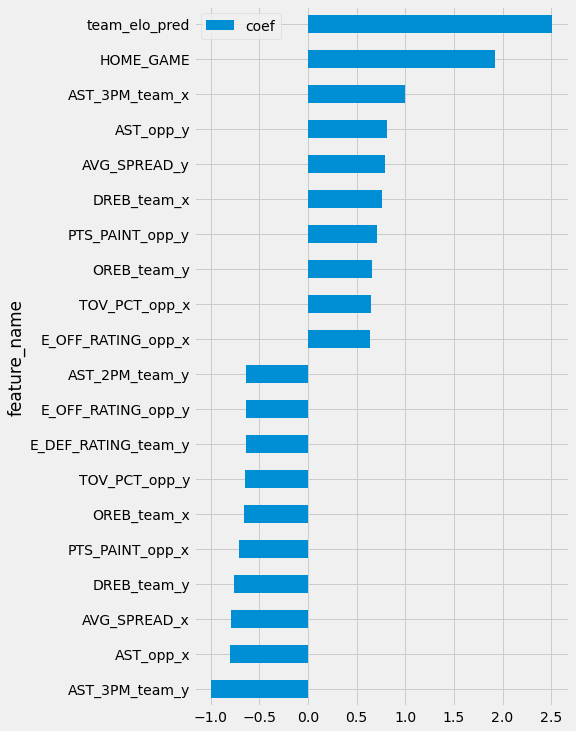

In [196]:
ridge_alpha = study_lr.best_params['alpha']
print(ridge_alpha)
best_ridge = Pipeline([('scaler', StandardScaler()),
                    ('ridge', Ridge(solver='auto', alpha=ridge_alpha))])

best_ridge.fit(X_train, y_train)

print(best_ridge)

ridge_train_preds = best_ridge.predict(X_train)
ridge_test_preds = best_ridge.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, ridge_train_preds))
print("test_MAE:", mean_absolute_error(y_test, ridge_test_preds))

view_model_coefs(best_ridge.named_steps['ridge'], X_train)

In [197]:
best_ridge.named_steps['ridge'].coef_

array([-2.33822165e-01,  3.38568319e-01, -3.65381461e-01, -7.05198480e-02,
        1.24857452e-01, -3.85939071e-02,  3.25415042e-01, -6.60407645e-01,
        7.57485146e-01,  2.30186724e-01, -1.52289136e-01,  2.15624320e-01,
       -7.51618650e-02, -1.28663493e-01,  3.04454200e-01,  1.87904367e-01,
        1.68240864e-01,  5.17415592e-01,  6.41148445e-01, -5.07454327e-02,
       -2.92114181e-01,  1.61171838e-01,  1.37841757e-01,  1.19146281e-01,
        1.40286083e-01,  1.17284345e-01,  6.26928833e-01,  9.93789835e-01,
       -6.56183017e-02, -5.93230527e-03, -2.91675691e-01,  2.33822165e-01,
        1.20001244e-01,  3.93399125e-01,  4.23470230e-02, -5.88696449e-01,
       -2.41021805e-01, -6.16578367e-01, -4.44632932e-01,  2.47690192e-01,
       -1.20821979e-02, -8.04082660e-01,  3.26243862e-01, -2.31031797e-02,
        1.96791324e-01, -1.95140554e-01,  1.49199304e-02, -1.68240864e-01,
        6.41148445e-01,  5.17415592e-01,  5.07454327e-02,  8.24680493e-02,
       -1.75911102e-01, -

### SVC 

In [51]:
# def objective(trial):    
#     svr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
#     svr_loss = trial.suggest_categorical('loss', ['epsilon_insensitive', 'squared_epsilon_insensitive'])
    
#     classifier_obj = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', LinearSVR(C = svr_C,
#                                 loss=svr_loss,
#                                max_iter=100000,
#                                      random_state=23))])
    
#     score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
#                            cv=tscv, scoring='neg_mean_absolute_error')
    
    
#     score_avg = score.mean()
    
#     return score_avg

# study_name = 'study_svr'
# storage_name = "sqlite:///{}.db".format(study_name)

# study_svc_acc = optuna.create_study(study_name = study_name, direction='maximize', 
#                                storage = storage_name, load_if_exists=True)

# study_svc_acc.optimize(objective, n_trials=1)

In [52]:
# svr_C = study_svr.best_params['C']
# svr_loss = study_svr.best_params['loss']

# print('C:', svc_C)
# best_svr = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', LinearSVR(C = svr_C,
#                                   loss=svr_loss,
#                                max_iter=100000,
#                                      random_state=23))])
    

# best_svr.fit(X_train, y_train)

# svr_train_preds = best_svr.predict(X_train)
# svr_test_preds = best_svr.predict(X_test)

# print("train_MAE:", mean_absolute_error(y_train, svr_train_preds))
# print("test_MAE:", mean_absolute_error(y_test, svr_test_preds))


In [53]:
# svc_pipe_rbf = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('svc', SVC(random_state=23, probability=True))])



# params = {
#     'svc__C': np.logspace(-3,1,100)
# }

# svc_rbf_cv = GridSearchCV(svc_pipe_rbf, param_grid=params, scoring='roc_auc', cv=tscv, n_jobs=-1, verbose=1)


# svc_rbf_cv.fit(X_train, y_train)

# best_svc_rbf = svc_rbf_cv.best_estimator_
# print("best_svc_rbf:", best_svc_rbf)


# print("train_score:", best_svc_rbf.score(X_train, y_train))
# print("test_score:", best_svc_rbf.score(X_test, y_test))

### SGD Hinge

In [198]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    sgd_loss = trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'])
    sgd_epsilon = trial.suggest_float('epsilon', 1e-4, 1, log=True)
    sgd_penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    
    reg_obj = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(alpha = sgd_alpha,
                                      loss=sgd_loss,
                                     epsilon = sgd_epsilon,
                                     penalty = sgd_penalty,
                               max_iter=10000,
                                     random_state=23,
                                    shuffle=False))])
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_regressor2'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=400)

[I 2021-11-02 17:21:03,054] A new study created in RDB with name: ../models/hyperparameter_tuning/study_sgd_regressor2
[I 2021-11-02 17:21:04,007] Trial 0 finished with value: -10.953094832968228 and parameters: {'alpha': 0.004142487760917464, 'loss': 'huber', 'epsilon': 0.00014280910193030744, 'penalty': 'l1'}. Best is trial 0 with value: -10.953094832968228.
[I 2021-11-02 17:21:09,310] Trial 1 finished with value: -9.379779687804795 and parameters: {'alpha': 0.11218240856135402, 'loss': 'squared_error', 'epsilon': 0.0036461449665407173, 'penalty': 'l1'}. Best is trial 1 with value: -9.379779687804795.
[I 2021-11-02 17:21:10,203] Trial 2 finished with value: -10.953095882266144 and parameters: {'alpha': 0.21450379986042056, 'loss': 'huber', 'epsilon': 0.308040897497112, 'penalty': 'l1'}. Best is trial 1 with value: -9.379779687804795.
[I 2021-11-02 17:21:11,106] Trial 3 finished with value: -10.953098240473874 and parameters: {'alpha': 1.0829610431550822, 'loss': 'epsilon_insensitive'

[I 2021-11-02 17:23:11,629] Trial 31 finished with value: -9.366689433974699 and parameters: {'alpha': 0.005145680184269802, 'loss': 'epsilon_insensitive', 'epsilon': 0.006542052352376434, 'penalty': 'l2'}. Best is trial 25 with value: -9.364162483423637.
[I 2021-11-02 17:23:12,630] Trial 32 finished with value: -9.365314118382042 and parameters: {'alpha': 0.008081804350218037, 'loss': 'epsilon_insensitive', 'epsilon': 0.0023266399244101592, 'penalty': 'l2'}. Best is trial 25 with value: -9.364162483423637.
[I 2021-11-02 17:23:13,451] Trial 33 finished with value: -9.433697595576547 and parameters: {'alpha': 0.08289702826538041, 'loss': 'epsilon_insensitive', 'epsilon': 0.002063823133293996, 'penalty': 'l2'}. Best is trial 25 with value: -9.364162483423637.
[I 2021-11-02 17:23:14,466] Trial 34 finished with value: -9.364452739008907 and parameters: {'alpha': 0.015746366565196377, 'loss': 'epsilon_insensitive', 'epsilon': 0.001016507715383092, 'penalty': 'l2'}. Best is trial 25 with val

[I 2021-11-02 17:24:35,445] Trial 62 finished with value: -9.365091024088027 and parameters: {'alpha': 0.009598014838147016, 'loss': 'epsilon_insensitive', 'epsilon': 0.010793774995841268, 'penalty': 'l2'}. Best is trial 44 with value: -9.362676687359947.
[I 2021-11-02 17:24:36,347] Trial 63 finished with value: -9.369433480169137 and parameters: {'alpha': 0.0039037709465918244, 'loss': 'epsilon_insensitive', 'epsilon': 0.08717593707820713, 'penalty': 'l2'}. Best is trial 44 with value: -9.362676687359947.
[I 2021-11-02 17:24:37,258] Trial 64 finished with value: -9.363953365615336 and parameters: {'alpha': 0.02268787219431506, 'loss': 'epsilon_insensitive', 'epsilon': 0.006755708547316518, 'penalty': 'l2'}. Best is trial 44 with value: -9.362676687359947.
[I 2021-11-02 17:24:38,241] Trial 65 finished with value: -9.385037123285041 and parameters: {'alpha': 0.04475523382844281, 'loss': 'epsilon_insensitive', 'epsilon': 0.003173704331629337, 'penalty': 'l2'}. Best is trial 44 with value

[I 2021-11-02 17:25:23,088] Trial 93 finished with value: -9.396306045022083 and parameters: {'alpha': 0.052321932871231595, 'loss': 'epsilon_insensitive', 'epsilon': 0.07553679011626803, 'penalty': 'elasticnet'}. Best is trial 90 with value: -9.36166351656534.
[I 2021-11-02 17:25:24,375] Trial 94 finished with value: -9.362639901941275 and parameters: {'alpha': 0.010631633290657548, 'loss': 'epsilon_insensitive', 'epsilon': 0.11440162705800909, 'penalty': 'elasticnet'}. Best is trial 90 with value: -9.36166351656534.
[I 2021-11-02 17:25:25,691] Trial 95 finished with value: -9.367164259984543 and parameters: {'alpha': 0.0036113900339169356, 'loss': 'epsilon_insensitive', 'epsilon': 0.05780255768091183, 'penalty': 'elasticnet'}. Best is trial 90 with value: -9.36166351656534.
[I 2021-11-02 17:25:27,061] Trial 96 finished with value: -9.37006114172397 and parameters: {'alpha': 0.001568777764153357, 'loss': 'epsilon_insensitive', 'epsilon': 0.1177263154548208, 'penalty': 'elasticnet'}. B

[I 2021-11-02 17:27:02,426] Trial 123 finished with value: -9.369020461125821 and parameters: {'alpha': 0.002215501409142604, 'loss': 'epsilon_insensitive', 'epsilon': 0.3726613790502275, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:03,821] Trial 124 finished with value: -9.362302219440183 and parameters: {'alpha': 0.007520622134086124, 'loss': 'epsilon_insensitive', 'epsilon': 0.6009271665249972, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:05,160] Trial 125 finished with value: -9.368329110998719 and parameters: {'alpha': 0.029043459754170126, 'loss': 'epsilon_insensitive', 'epsilon': 0.45841393732784663, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:06,502] Trial 126 finished with value: -9.362432167896213 and parameters: {'alpha': 0.007386132787291281, 'loss': 'epsilon_insensitive', 'epsilon': 0.7624341685046031, 'penalty': 'elasticnet

[I 2021-11-02 17:27:50,058] Trial 154 finished with value: -9.360056303189769 and parameters: {'alpha': 0.010286648666418874, 'loss': 'huber', 'epsilon': 0.9845788190170682, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:51,224] Trial 155 finished with value: -9.359911848907569 and parameters: {'alpha': 0.010472556588530472, 'loss': 'huber', 'epsilon': 0.9808781735292543, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:52,561] Trial 156 finished with value: -9.363819913169106 and parameters: {'alpha': 0.0030600855567764914, 'loss': 'huber', 'epsilon': 0.9987513966061791, 'penalty': 'elasticnet'}. Best is trial 109 with value: -9.35916719170481.
[I 2021-11-02 17:27:53,694] Trial 157 finished with value: -9.359122427140138 and parameters: {'alpha': 0.008857037533329021, 'loss': 'huber', 'epsilon': 0.7884570476084964, 'penalty': 'elasticnet'}. Best is trial 157 with value: -9.359122427140138.
[I

[I 2021-11-02 17:28:26,682] Trial 186 finished with value: -9.359531604806765 and parameters: {'alpha': 0.002664815212858252, 'loss': 'huber', 'epsilon': 0.5689520632075385, 'penalty': 'elasticnet'}. Best is trial 185 with value: -9.358426594254956.
[I 2021-11-02 17:28:27,793] Trial 187 finished with value: -9.360392734540403 and parameters: {'alpha': 0.002018145515156963, 'loss': 'huber', 'epsilon': 0.6197558331218055, 'penalty': 'elasticnet'}. Best is trial 185 with value: -9.358426594254956.
[I 2021-11-02 17:28:28,891] Trial 188 finished with value: -9.358035069544357 and parameters: {'alpha': 0.003040016459143079, 'loss': 'huber', 'epsilon': 0.41166114062867515, 'penalty': 'elasticnet'}. Best is trial 188 with value: -9.358035069544357.
[I 2021-11-02 17:28:30,081] Trial 189 finished with value: -9.361494319193481 and parameters: {'alpha': 0.0003845626786597907, 'loss': 'huber', 'epsilon': 0.3888033263347992, 'penalty': 'elasticnet'}. Best is trial 188 with value: -9.358035069544357

[I 2021-11-02 17:29:02,805] Trial 218 finished with value: -9.357087310374242 and parameters: {'alpha': 0.0013852335266495272, 'loss': 'huber', 'epsilon': 0.26168999784884195, 'penalty': 'elasticnet'}. Best is trial 210 with value: -9.356937361166114.
[I 2021-11-02 17:29:03,895] Trial 219 finished with value: -9.358028895500189 and parameters: {'alpha': 0.0006980616434159458, 'loss': 'huber', 'epsilon': 0.2574024480524088, 'penalty': 'elasticnet'}. Best is trial 210 with value: -9.356937361166114.
[I 2021-11-02 17:29:05,026] Trial 220 finished with value: -9.357390931750391 and parameters: {'alpha': 0.0013579076633069727, 'loss': 'huber', 'epsilon': 0.2369268802317929, 'penalty': 'elasticnet'}. Best is trial 210 with value: -9.356937361166114.
[I 2021-11-02 17:29:06,152] Trial 221 finished with value: -9.357511549311296 and parameters: {'alpha': 0.0010415444756537743, 'loss': 'huber', 'epsilon': 0.2472809584279449, 'penalty': 'elasticnet'}. Best is trial 210 with value: -9.356937361166

[I 2021-11-02 17:30:14,616] Trial 250 finished with value: -9.356596509650043 and parameters: {'alpha': 0.0008341965377264165, 'loss': 'huber', 'epsilon': 0.253001634479307, 'penalty': 'l1'}. Best is trial 250 with value: -9.356596509650043.
[I 2021-11-02 17:30:15,696] Trial 251 finished with value: -9.356993689042087 and parameters: {'alpha': 0.0007844716825632918, 'loss': 'huber', 'epsilon': 0.2853214376859324, 'penalty': 'l1'}. Best is trial 250 with value: -9.356596509650043.
[I 2021-11-02 17:30:16,772] Trial 252 finished with value: -9.357134174629326 and parameters: {'alpha': 0.000770855914252667, 'loss': 'huber', 'epsilon': 0.2811703924797726, 'penalty': 'l1'}. Best is trial 250 with value: -9.356596509650043.
[I 2021-11-02 17:30:17,849] Trial 253 finished with value: -9.357506559867705 and parameters: {'alpha': 0.0006471604837722363, 'loss': 'huber', 'epsilon': 0.1928213051964688, 'penalty': 'l1'}. Best is trial 250 with value: -9.356596509650043.
[I 2021-11-02 17:30:18,934] Tr

[I 2021-11-02 17:31:21,978] Trial 282 finished with value: -9.358866535877263 and parameters: {'alpha': 0.00047554498435414317, 'loss': 'huber', 'epsilon': 0.18116893104938447, 'penalty': 'l1'}. Best is trial 275 with value: -9.356447704855361.
[I 2021-11-02 17:31:23,032] Trial 283 finished with value: -9.356319393544325 and parameters: {'alpha': 0.0006464984652400955, 'loss': 'huber', 'epsilon': 0.23437109621372237, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:31:24,110] Trial 284 finished with value: -9.356410006713617 and parameters: {'alpha': 0.0006898501643113714, 'loss': 'huber', 'epsilon': 0.23213397726654744, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:31:25,188] Trial 285 finished with value: -9.356564003054398 and parameters: {'alpha': 0.0006456794190342649, 'loss': 'huber', 'epsilon': 0.24854320744562433, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:31:26,

[I 2021-11-02 17:32:31,999] Trial 314 finished with value: -9.401537610888123 and parameters: {'alpha': 0.0002539187751777108, 'loss': 'huber', 'epsilon': 0.10223791014369038, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:32:33,237] Trial 315 finished with value: -9.35641098100535 and parameters: {'alpha': 0.0009737837799613442, 'loss': 'huber', 'epsilon': 0.23219112373403447, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:32:34,409] Trial 316 finished with value: -9.363217959190711 and parameters: {'alpha': 0.0009466881626138525, 'loss': 'huber', 'epsilon': 0.17134556483955013, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:32:35,389] Trial 317 finished with value: -10.953095601726957 and parameters: {'alpha': 5.8496004642618615, 'loss': 'huber', 'epsilon': 0.22572158913564827, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:32:36,460]

[I 2021-11-02 17:34:06,794] Trial 346 finished with value: -9.537378314988299 and parameters: {'alpha': 0.0004951127405709056, 'loss': 'squared_error', 'epsilon': 0.20190907103461478, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:34:07,848] Trial 347 finished with value: -9.35776661680504 and parameters: {'alpha': 0.0011104673970579266, 'loss': 'huber', 'epsilon': 0.33890347872636606, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:34:08,967] Trial 348 finished with value: -9.39052563370158 and parameters: {'alpha': 0.0006811530311406419, 'loss': 'huber', 'epsilon': 0.11540639767434442, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:34:10,058] Trial 349 finished with value: -9.367692502840924 and parameters: {'alpha': 0.00031850042073995, 'loss': 'huber', 'epsilon': 0.14623921727369676, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:34:

[I 2021-11-02 17:35:15,963] Trial 378 finished with value: -9.357799452514858 and parameters: {'alpha': 0.00022689650721083597, 'loss': 'huber', 'epsilon': 0.22866442716958, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:35:17,173] Trial 379 finished with value: -9.362328081585515 and parameters: {'alpha': 0.0010380856427930662, 'loss': 'huber', 'epsilon': 0.17712492330174087, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:35:18,219] Trial 380 finished with value: -9.377792794569917 and parameters: {'alpha': 6.483452134916587e-05, 'loss': 'huber', 'epsilon': 0.12549353779786443, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:35:19,300] Trial 381 finished with value: -9.425399508261046 and parameters: {'alpha': 0.00045075310887014486, 'loss': 'huber', 'epsilon': 0.08666105316307719, 'penalty': 'l1'}. Best is trial 283 with value: -9.356319393544325.
[I 2021-11-02 17:35:20,46

best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDRegressor(alpha=0.0006464984652400955,
                              epsilon=0.23437109621372237, loss='huber',
                              max_iter=10000, penalty='l1', random_state=23,
                              shuffle=False))])
train_MAE: 9.372961618273994
test_MAE: 10.244746699081084


feature_name      coef
65          AVG_SPREAD_x -0.476765
151               REST_y -0.446707
168         opp_rating_i -0.344327
54          PTS_FB_opp_x -0.252070
66              AVG_ML_x -0.230179
145   TEAM_COVERED_opp_y -0.211071
144       ATS_DIFF_opp_y -0.207307
30       ATS_DIFF_team_x -0.205725
100  E_OFF_RATING_team_y -0.187206
132   E_DEF_RATING_opp_y -0.187206
94            STL_team_y -0.186822
107   PTS_OFF_TOV_team_y -0.186759
110       AST_3PM_team_y -0.176014
35            FG3A_opp_x -0.170550
56       PTS_PAINT_opp_x -0.150887
146             WL_PCT_y -0.142214
87           FG3A_team_y -0.133475
99     PLUS_MINUS_team_y -0.133446
47      PLUS_MINUS_opp_x -0.133309
156       REB_PCT_team_y -0.129475
74         REB_PCT_opp_x -0.129214
102  E_NET_RATING_team_y -0.124922
50    E_NET_RATING_opp_x -0.124783
57         AST_2PM_opp_x -0.121675
2            FG2A_team_x -0.109589
41             AST_opp_x -0.108757
80       AST_RATIO_opp_x -0.108412
125            STL_opp_y -0.105236
29       UAST_3PM_team_x -0.097790
165        TOV_PCT_opp_y -0.097179
40             REB_opp_x -0.083645
154      DREB_PCT_team_y -0.078409
70        OREB_PCT_opp_x -0.077188
136     PTS_2PT_MR_opp_y -0.076793
67        AVG_ATS_DIFF_x -0.075340
98            PTS_team_y -0.071851
158        TS_PCT_team_y -0.071359
104           PIE_team_y -0.070445
160       EFG_PCT_team_y -0.070297
52             PIE_opp_x -0.069194
106        PTS_FB_team_y -0.067561
45              PF_opp_x -0.057393
86           FG3M_team_y -0.055530
81        TOV_PCT_team_x -0.046229
127            TOV_opp_y -0.043787
38            OREB_opp_x -0.043036
13            TOV_team_x -0.041302
39            DREB_opp_x -0.029625
92            REB_team_y -0.023220
43             BLK_opp_x -0.022212
152      OREB_PCT_team_y -0.007977
72        DREB_PCT_opp_x -0.007272
91           DREB_team_y -0.006770
93            AST_team_y -0.006537
22     PTS_2PT_MR_team_x -0.001214
162     AST_RATIO_team_y -0.000619
105    PTS_2PT_MR_team_y  0.003851
10            AST_team_x  0.005844
69       OREB_PCT_team_x  0.007272
8            DREB_team_x  0.007527
155       DREB_PCT_opp_y  0.007977
9             REB_team_x  0.023182
126            BLK_opp_y  0.027072
122           DREB_opp_y  0.029366
96            TOV_team_y  0.041449
44             TOV_opp_x  0.042789
121           OREB_opp_y  0.044083
164       TOV_PCT_team_y  0.045915
3            FG3M_team_x  0.056350
128             PF_opp_y  0.058476
23         PTS_FB_team_x  0.064306
21            PIE_team_x  0.068942
135            PIE_opp_y  0.070700
75         TS_PCT_team_x  0.071981
77        EFG_PCT_team_x  0.073017
15            PTS_team_x  0.073110
150       AVG_ATS_DIFF_y  0.074353
71       DREB_PCT_team_x  0.077188
53      PTS_2PT_MR_opp_x  0.077285
153       OREB_PCT_opp_y  0.078409
123            REB_opp_y  0.083956
82         TOV_PCT_opp_x  0.094869
112      UAST_3PM_team_y  0.095545
42             STL_opp_x  0.102627
163      AST_RATIO_opp_y  0.108402
124            AST_opp_y  0.109646
85           FG2A_team_y  0.110689
140        AST_2PM_opp_y  0.122400
19   E_NET_RATING_team_x  0.124783
133   E_NET_RATING_opp_y  0.124922
73        REB_PCT_team_x  0.129214
157        REB_PCT_opp_y  0.129475
4            FG3A_team_x  0.133037
16     PLUS_MINUS_team_x  0.133309
130     PLUS_MINUS_opp_y  0.133446
63              WL_PCT_x  0.141689
139      PTS_PAINT_opp_y  0.148127
118           FG3A_opp_y  0.170065
27        AST_3PM_team_x  0.177365
17   E_OFF_RATING_team_x  0.187110
49    E_DEF_RATING_opp_x  0.187110
24    PTS_OFF_TOV_team_x  0.187232
11            STL_team_x  0.189171
61        ATS_DIFF_opp_x  0.205725
113      ATS_DIFF_team_y  0.207307
62    TEAM_COVERED_opp_x  0.210593
149             AVG_ML_y  0.227762
137         PTS_FB_opp_y  0.249302
167        team_rating_i  0.346792
68                REST_x  0.448834
148         AVG_SPREAD_y  0.474729
169         elo_MOV_pred  0.629936
166        team_elo_pred  1.748158
170            HOME_GA

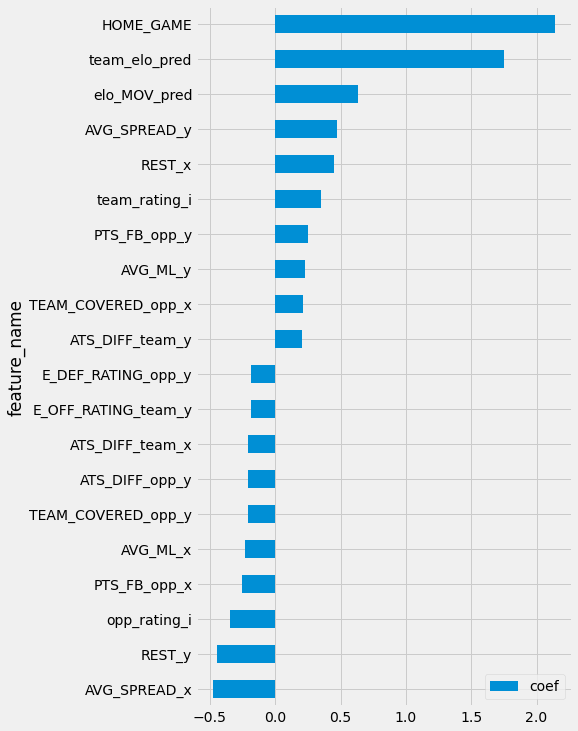

In [199]:
sgd_alpha = study_sgd.best_params['alpha']
sgd_loss = study_sgd.best_params['loss']
sgd_epsilon = study_sgd.best_params['epsilon']
sgd_penalty = study_sgd.best_params['penalty']

best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(alpha = sgd_alpha,
                                      loss=sgd_loss,
                                     epsilon = sgd_epsilon,
                                     penalty = sgd_penalty,
                               max_iter=10000,
                                     random_state=23,
                                    shuffle=False))])

print("best_sgd:", best_sgd)

best_sgd.fit(X_train, y_train)

sgd_train_preds = best_sgd.predict(X_train)
sgd_test_preds = best_sgd.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, sgd_train_preds))
print("test_MAE:", mean_absolute_error(y_test, sgd_test_preds))

view_model_coefs(best_sgd.named_steps['sgd'], X_train)

### LGBClassifier

In [200]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    reg_obj = lgb.LGBMRegressor(colsample_bytree=colsample_bytree,
                                        max_depth=max_depth,
                                        min_child_weight=min_child_weight,
                                        num_leaves=num_leaves, 
                                        random_state=23,
                                        reg_alpha=reg_alpha, 
                                        reg_lambda=reg_lambda,
                                       learning_rate=learning_rate)
    
    score = cross_val_score(reg_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbr3'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbr.optimize(objective, n_trials=400, show_progress_bar=True)

[I 2021-11-02 17:36:12,740] A new study created in RDB with name: ../models/hyperparameter_tuning/study_lgbr3
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2021-11-02 17:36:20,658] Trial 0 finished with value: -11.691269072193686 and parameters: {'min_child_weight': 0.9373706343440024, 'subsample': 0.9346118976752456, 'max_depth': 6, 'reg_lambda': 1.6506328156495704, 'reg_alpha': 3.638737393861444, 'num_leaves': 335, 'colsample_bytree': 0.7950986315996349, 'learning_rate': 0.6689686055401008}. Best is trial 0 with value: -11.691269072193686.
[I 2021-11-02 17:36:31,397] Trial 1 finished with value: -9.611600833371535 and parameters: {'min_child_weight': 0.2404202873477738, 'subsample': 0.759424192187924, 'max_depth': 27, 'reg_lambda': 1.6631571972295023, 'reg_alpha': 3.662398954831025, 'num_leaves': 467, 'colsample_bytree': 0.1568255749351176, 'learning_rate': 0.0246806227889789}. Best is trial 1 with value: -9.611600833371535.
[I 2021-11-02 17:36:37,003] Trial 2 finished with value: -9.727678964247787 and parameters: {'min_child_weight': 0.2863700875277769, 'subsample': 0.9644219917816874, 'max_depth': 6, 'reg_lambda': 9.53253777542791

[I 2021-11-02 17:39:45,045] Trial 21 finished with value: -9.594124177958426 and parameters: {'min_child_weight': 0.8024203934017626, 'subsample': 0.6396302519976071, 'max_depth': 9, 'reg_lambda': 6.861593261830925, 'reg_alpha': 0.691371363404337, 'num_leaves': 205, 'colsample_bytree': 0.3983388478001046, 'learning_rate': 0.07588171790887172}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:39:47,233] Trial 22 finished with value: -9.448560743684366 and parameters: {'min_child_weight': 0.578074126425062, 'subsample': 0.6478056063579201, 'max_depth': 14, 'reg_lambda': 7.376091563491988, 'reg_alpha': 1.1827241472745151, 'num_leaves': 9, 'colsample_bytree': 0.2482228323817237, 'learning_rate': 0.036599038060753465}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:39:58,223] Trial 23 finished with value: -10.371754065210547 and parameters: {'min_child_weight': 0.9958187684447277, 'subsample': 0.8229624110405265, 'max_depth': 9, 'reg_lambda': 6.0146650877

[I 2021-11-02 17:41:54,510] Trial 42 finished with value: -9.669883795886117 and parameters: {'min_child_weight': 0.44657200572109934, 'subsample': 0.7074438619435756, 'max_depth': 5, 'reg_lambda': 5.795658120812119, 'reg_alpha': 4.702107809348697, 'num_leaves': 92, 'colsample_bytree': 0.43107505854692285, 'learning_rate': 0.1856135538261928}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:41:57,078] Trial 43 finished with value: -9.415528043126375 and parameters: {'min_child_weight': 0.8543112982179695, 'subsample': 0.7932510279214408, 'max_depth': 4, 'reg_lambda': 6.343105070405686, 'reg_alpha': 4.226031944971258, 'num_leaves': 141, 'colsample_bytree': 0.35972595052126527, 'learning_rate': 0.03696558811261738}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:42:01,160] Trial 44 finished with value: -9.46482035481722 and parameters: {'min_child_weight': 0.890813032854024, 'subsample': 0.791536064376624, 'max_depth': 6, 'reg_lambda': 5.3045632286745

[I 2021-11-02 17:43:38,960] Trial 63 finished with value: -9.473764712941227 and parameters: {'min_child_weight': 0.5391854230058312, 'subsample': 0.8139938974501231, 'max_depth': 3, 'reg_lambda': 1.0240806804562244, 'reg_alpha': 4.5830257020175615, 'num_leaves': 253, 'colsample_bytree': 0.4808414968404736, 'learning_rate': 0.15922266108450267}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:43:41,228] Trial 64 finished with value: -9.439681126806823 and parameters: {'min_child_weight': 0.7641205100502748, 'subsample': 0.6614506685811399, 'max_depth': 4, 'reg_lambda': 5.903859954300719, 'reg_alpha': 4.3721546323167955, 'num_leaves': 155, 'colsample_bytree': 0.3312412431165086, 'learning_rate': 0.0955714444231026}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:43:54,824] Trial 65 finished with value: -9.559215512045004 and parameters: {'min_child_weight': 0.8189511522578704, 'subsample': 0.7126632913703784, 'max_depth': 16, 'reg_lambda': 3.90285931

[I 2021-11-02 17:45:17,193] Trial 84 finished with value: -9.443344263609015 and parameters: {'min_child_weight': 0.8713902429546914, 'subsample': 0.7156240233225762, 'max_depth': 4, 'reg_lambda': 5.435884662829402, 'reg_alpha': 4.306797978532946, 'num_leaves': 349, 'colsample_bytree': 0.44485353686863466, 'learning_rate': 0.09364271184744409}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:45:19,502] Trial 85 finished with value: -9.445738290047187 and parameters: {'min_child_weight': 0.9263752277173413, 'subsample': 0.6748231511784379, 'max_depth': 3, 'reg_lambda': 5.718668923372961, 'reg_alpha': 4.122314844962288, 'num_leaves': 242, 'colsample_bytree': 0.5533067717076938, 'learning_rate': 0.15427305540581715}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:45:22,221] Trial 86 finished with value: -9.401390776994752 and parameters: {'min_child_weight': 0.8013248187663814, 'subsample': 0.8312069629343966, 'max_depth': 4, 'reg_lambda': 6.0654062414

[I 2021-11-02 17:46:44,457] Trial 105 finished with value: -9.458175257359866 and parameters: {'min_child_weight': 0.46209395329396713, 'subsample': 0.6781009983667986, 'max_depth': 4, 'reg_lambda': 5.303452435828806, 'reg_alpha': 2.259600253946794, 'num_leaves': 64, 'colsample_bytree': 0.4644871939239861, 'learning_rate': 0.11578091110477383}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:46:49,013] Trial 106 finished with value: -9.4847913676665 and parameters: {'min_child_weight': 0.4925809070171383, 'subsample': 0.6845867172628198, 'max_depth': 6, 'reg_lambda': 4.667615717011433, 'reg_alpha': 3.8826067888229487, 'num_leaves': 247, 'colsample_bytree': 0.5069408704184742, 'learning_rate': 0.06751321795619714}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:46:51,259] Trial 107 finished with value: -9.401074532799672 and parameters: {'min_child_weight': 0.59483517961586, 'subsample': 0.6551389109625287, 'max_depth': 3, 'reg_lambda': 5.64139528457

[I 2021-11-02 17:47:36,944] Trial 125 finished with value: -9.43404695327211 and parameters: {'min_child_weight': 0.6305738832622478, 'subsample': 0.7130017852354057, 'max_depth': 4, 'reg_lambda': 6.2709963421343, 'reg_alpha': 0.6252577602497058, 'num_leaves': 114, 'colsample_bytree': 0.5786984423774905, 'learning_rate': 0.08986466947819885}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:47:39,498] Trial 126 finished with value: -9.402071618622662 and parameters: {'min_child_weight': 0.5829101548436143, 'subsample': 0.6888104121879413, 'max_depth': 3, 'reg_lambda': 5.239834467513434, 'reg_alpha': 0.0020876013387078063, 'num_leaves': 150, 'colsample_bytree': 0.6872859355166416, 'learning_rate': 0.10734086249207558}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:47:42,598] Trial 127 finished with value: -9.410974696604109 and parameters: {'min_child_weight': 0.6612370678475135, 'subsample': 0.6453768824268589, 'max_depth': 4, 'reg_lambda': 5.466248

[I 2021-11-02 17:48:41,881] Trial 146 finished with value: -9.408578354255585 and parameters: {'min_child_weight': 0.7021612904584198, 'subsample': 0.6744970889760656, 'max_depth': 4, 'reg_lambda': 6.5950998471979325, 'reg_alpha': 0.6090491015002293, 'num_leaves': 105, 'colsample_bytree': 0.6591877810568438, 'learning_rate': 0.05903104117692306}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:48:53,399] Trial 147 finished with value: -9.602341896195075 and parameters: {'min_child_weight': 0.6264508851453119, 'subsample': 0.6915759277774808, 'max_depth': 16, 'reg_lambda': 6.407132762730648, 'reg_alpha': 0.7217440813301724, 'num_leaves': 87, 'colsample_bytree': 0.6674587454346663, 'learning_rate': 0.08274775295987039}. Best is trial 18 with value: -9.382415198198515.
[I 2021-11-02 17:48:55,911] Trial 148 finished with value: -9.436001136640812 and parameters: {'min_child_weight': 0.6489780257025464, 'subsample': 0.7077293352299743, 'max_depth': 3, 'reg_lambda': 6.95926

[I 2021-11-02 17:49:53,208] Trial 166 finished with value: -9.432155051611169 and parameters: {'min_child_weight': 0.6199716808983835, 'subsample': 0.6884766588728873, 'max_depth': 5, 'reg_lambda': 7.855944838553678, 'reg_alpha': 3.2292069330572137, 'num_leaves': 98, 'colsample_bytree': 0.6538053824132917, 'learning_rate': 0.07476236949093583}. Best is trial 161 with value: -9.381947601058906.
[I 2021-11-02 17:49:55,828] Trial 167 finished with value: -9.380960230567124 and parameters: {'min_child_weight': 0.6401833364020095, 'subsample': 0.7018746505020305, 'max_depth': 3, 'reg_lambda': 7.28981542711447, 'reg_alpha': 0.18810433256950412, 'num_leaves': 104, 'colsample_bytree': 0.6831546062629658, 'learning_rate': 0.05754814802588023}. Best is trial 167 with value: -9.380960230567124.
[I 2021-11-02 17:49:59,169] Trial 168 finished with value: -9.402678200032444 and parameters: {'min_child_weight': 0.6754922274593175, 'subsample': 0.7034376101478077, 'max_depth': 4, 'reg_lambda': 7.39637

[I 2021-11-02 17:51:02,330] Trial 186 finished with value: -9.403777400824177 and parameters: {'min_child_weight': 0.7198538666465675, 'subsample': 0.9896520509495563, 'max_depth': 3, 'reg_lambda': 7.647082644527453, 'reg_alpha': 0.6270821623024246, 'num_leaves': 59, 'colsample_bytree': 0.7783111270754761, 'learning_rate': 0.03759072807211073}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:51:05,024] Trial 187 finished with value: -9.386986950044895 and parameters: {'min_child_weight': 0.7681847890895768, 'subsample': 0.9392821381108049, 'max_depth': 3, 'reg_lambda': 7.430084687137106, 'reg_alpha': 0.43479503440341694, 'num_leaves': 45, 'colsample_bytree': 0.6945700737933423, 'learning_rate': 0.052967790986520435}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:51:08,320] Trial 188 finished with value: -9.39422252829832 and parameters: {'min_child_weight': 0.7665735581266422, 'subsample': 0.9528877952872874, 'max_depth': 4, 'reg_lambda': 7.25480

[I 2021-11-02 17:52:08,701] Trial 206 finished with value: -9.39070962503591 and parameters: {'min_child_weight': 0.64146104542518, 'subsample': 0.9229029597861447, 'max_depth': 3, 'reg_lambda': 7.361855058500642, 'reg_alpha': 0.7315907446072254, 'num_leaves': 78, 'colsample_bytree': 0.5949831797915272, 'learning_rate': 0.0733689492367384}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:52:11,356] Trial 207 finished with value: -9.399834744125567 and parameters: {'min_child_weight': 0.6261717657631373, 'subsample': 0.9435297711649254, 'max_depth': 3, 'reg_lambda': 6.864696347872204, 'reg_alpha': 0.28295135866375937, 'num_leaves': 107, 'colsample_bytree': 0.6452926772697342, 'learning_rate': 0.039515130976684965}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:52:14,416] Trial 208 finished with value: -9.411441075403788 and parameters: {'min_child_weight': 0.6556289349573449, 'subsample': 0.9590487433922912, 'max_depth': 4, 'reg_lambda': 7.5468394

[I 2021-11-02 17:53:08,284] Trial 226 finished with value: -9.403516676453643 and parameters: {'min_child_weight': 0.7066366581317719, 'subsample': 0.928109689506494, 'max_depth': 4, 'reg_lambda': 7.297828205308132, 'reg_alpha': 0.34483418401136356, 'num_leaves': 36, 'colsample_bytree': 0.6471606201338278, 'learning_rate': 0.05691725693197309}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:53:10,991] Trial 227 finished with value: -10.882751493882733 and parameters: {'min_child_weight': 0.5976001865391223, 'subsample': 0.9712689807667293, 'max_depth': 3, 'reg_lambda': 6.809354517280952, 'reg_alpha': 0.08516999262689467, 'num_leaves': 112, 'colsample_bytree': 0.6862323299105568, 'learning_rate': 0.0003134997866417472}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:53:13,427] Trial 228 finished with value: -9.387459928472989 and parameters: {'min_child_weight': 0.6747609345160881, 'subsample': 0.9816049156195216, 'max_depth': 3, 'reg_lambda': 7.4

[I 2021-11-02 17:54:18,385] Trial 246 finished with value: -9.400963398466422 and parameters: {'min_child_weight': 0.6668242345633261, 'subsample': 0.9937969181383286, 'max_depth': 3, 'reg_lambda': 7.162249527345143, 'reg_alpha': 0.19055142019196747, 'num_leaves': 99, 'colsample_bytree': 0.6259406393421122, 'learning_rate': 0.09000744801502703}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:54:21,550] Trial 247 finished with value: -9.398795398428641 and parameters: {'min_child_weight': 0.6015219606848017, 'subsample': 0.8933505452808425, 'max_depth': 4, 'reg_lambda': 6.827605822964567, 'reg_alpha': 0.29686488335958405, 'num_leaves': 114, 'colsample_bytree': 0.6357864966188937, 'learning_rate': 0.05890306810922806}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:54:24,033] Trial 248 finished with value: -9.382833157624907 and parameters: {'min_child_weight': 0.7164821727149169, 'subsample': 0.9573303179816745, 'max_depth': 3, 'reg_lambda': 7.304

[I 2021-11-02 17:55:24,643] Trial 266 finished with value: -9.38082806400055 and parameters: {'min_child_weight': 0.671292864526512, 'subsample': 0.9892483328882389, 'max_depth': 3, 'reg_lambda': 6.663099684803209, 'reg_alpha': 0.0006731685408637167, 'num_leaves': 80, 'colsample_bytree': 0.6505015520564188, 'learning_rate': 0.06689731948372021}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:55:27,789] Trial 267 finished with value: -9.414392504404411 and parameters: {'min_child_weight': 0.22464346665305407, 'subsample': 0.9986412279328073, 'max_depth': 4, 'reg_lambda': 6.613380569981537, 'reg_alpha': 0.07151395267314317, 'num_leaves': 486, 'colsample_bytree': 0.6514687590924683, 'learning_rate': 0.07274309705012379}. Best is trial 178 with value: -9.378203152532157.
[I 2021-11-02 17:55:30,222] Trial 268 finished with value: -9.401521075197271 and parameters: {'min_child_weight': 0.6696914473204043, 'subsample': 0.9882861916582842, 'max_depth': 3, 'reg_lambda': 6.67

[I 2021-11-02 17:56:28,843] Trial 286 finished with value: -9.377771784027063 and parameters: {'min_child_weight': 0.41133711386530775, 'subsample': 0.7039563504181428, 'max_depth': 3, 'reg_lambda': 7.117760718314752, 'reg_alpha': 0.3556024931465255, 'num_leaves': 96, 'colsample_bytree': 0.5766913492125603, 'learning_rate': 0.0657079161689604}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:56:32,360] Trial 287 finished with value: -9.424392309125196 and parameters: {'min_child_weight': 0.4166266955881589, 'subsample': 0.7026059868040906, 'max_depth': 4, 'reg_lambda': 6.543353568166018, 'reg_alpha': 0.34701843615517025, 'num_leaves': 128, 'colsample_bytree': 0.5729169260429776, 'learning_rate': 0.08382507404120018}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:56:36,058] Trial 288 finished with value: -9.518790981931964 and parameters: {'min_child_weight': 0.263862767419187, 'subsample': 0.710952094139755, 'max_depth': 5, 'reg_lambda': 6.889095

[I 2021-11-02 17:57:47,746] Trial 306 finished with value: -9.3889505573897 and parameters: {'min_child_weight': 0.3655091509234192, 'subsample': 0.681312608335139, 'max_depth': 3, 'reg_lambda': 7.5167792612756505, 'reg_alpha': 0.10724681255003282, 'num_leaves': 121, 'colsample_bytree': 0.6791100176663244, 'learning_rate': 0.06354880031887011}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:57:50,838] Trial 307 finished with value: -10.162362963987707 and parameters: {'min_child_weight': 0.3049630451027312, 'subsample': 0.6968770205038243, 'max_depth': 4, 'reg_lambda': 7.270962283959445, 'reg_alpha': 0.1219634358895267, 'num_leaves': 120, 'colsample_bytree': 0.6487065971548994, 'learning_rate': 0.4144025532893924}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:57:53,496] Trial 308 finished with value: -9.389424183344062 and parameters: {'min_child_weight': 0.35352420310892874, 'subsample': 0.6678850073472364, 'max_depth': 3, 'reg_lambda': 7.7864

[I 2021-11-02 17:58:57,490] Trial 326 finished with value: -9.396532187407155 and parameters: {'min_child_weight': 0.3204233318566956, 'subsample': 0.665765258471308, 'max_depth': 3, 'reg_lambda': 6.835284786693505, 'reg_alpha': 0.08979849879352679, 'num_leaves': 240, 'colsample_bytree': 0.7045094499723833, 'learning_rate': 0.04380865112422271}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:59:01,492] Trial 327 finished with value: -9.426911568268494 and parameters: {'min_child_weight': 0.27796101092413983, 'subsample': 0.6756230078883745, 'max_depth': 5, 'reg_lambda': 8.196568757442897, 'reg_alpha': 0.3585601121816871, 'num_leaves': 69, 'colsample_bytree': 0.5906665291947649, 'learning_rate': 0.050964892788589254}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 17:59:04,784] Trial 328 finished with value: -9.417767634819572 and parameters: {'min_child_weight': 0.5899479283380493, 'subsample': 0.7065448934505506, 'max_depth': 4, 'reg_lambda': 6.405

[I 2021-11-02 18:00:10,880] Trial 346 finished with value: -9.387957921502403 and parameters: {'min_child_weight': 0.6803231934166057, 'subsample': 0.6844087410067377, 'max_depth': 3, 'reg_lambda': 6.902154820961344, 'reg_alpha': 0.31529783437538106, 'num_leaves': 78, 'colsample_bytree': 0.582399422735413, 'learning_rate': 0.052175712044438154}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:00:13,946] Trial 347 finished with value: -9.413176239964333 and parameters: {'min_child_weight': 0.12031203976207042, 'subsample': 0.9707102830555177, 'max_depth': 4, 'reg_lambda': 7.054542229120616, 'reg_alpha': 0.5437555571053643, 'num_leaves': 49, 'colsample_bytree': 0.6151362198526465, 'learning_rate': 0.0660714526471716}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:00:16,481] Trial 348 finished with value: -9.3964983267848 and parameters: {'min_child_weight': 0.6579873744331701, 'subsample': 0.9999077187637744, 'max_depth': 3, 'reg_lambda': 7.3964802

[I 2021-11-02 18:01:31,539] Trial 366 finished with value: -9.38914482465704 and parameters: {'min_child_weight': 0.5935171974463771, 'subsample': 0.9623099058834238, 'max_depth': 3, 'reg_lambda': 6.955096368575188, 'reg_alpha': 0.5072085881481235, 'num_leaves': 82, 'colsample_bytree': 0.6779902678814782, 'learning_rate': 0.0774222160104245}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:01:34,022] Trial 367 finished with value: -9.388508696327596 and parameters: {'min_child_weight': 0.39819074357556006, 'subsample': 0.7015429203461764, 'max_depth': 3, 'reg_lambda': 7.133004105970868, 'reg_alpha': 0.23463026009590085, 'num_leaves': 182, 'colsample_bytree': 0.5968600170621876, 'learning_rate': 0.060903488186624465}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:01:36,616] Trial 368 finished with value: -9.392712929120123 and parameters: {'min_child_weight': 0.6532641799229238, 'subsample': 0.7250864054163384, 'max_depth': 3, 'reg_lambda': 7.6593

[I 2021-11-02 18:02:38,122] Trial 386 finished with value: -9.405677927033647 and parameters: {'min_child_weight': 0.3210346420624889, 'subsample': 0.6799551667098226, 'max_depth': 3, 'reg_lambda': 7.6903148061134425, 'reg_alpha': 0.30302464742114105, 'num_leaves': 95, 'colsample_bytree': 0.614480252320331, 'learning_rate': 0.1164113303454842}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:02:42,732] Trial 387 finished with value: -9.422341468752512 and parameters: {'min_child_weight': 0.8301016519392277, 'subsample': 0.96837045317523, 'max_depth': 5, 'reg_lambda': 6.643689529291734, 'reg_alpha': 0.17009167876507902, 'num_leaves': 64, 'colsample_bytree': 0.6923738903560517, 'learning_rate': 0.0357977006663727}. Best is trial 286 with value: -9.377771784027063.
[I 2021-11-02 18:02:45,961] Trial 388 finished with value: -9.398103528234875 and parameters: {'min_child_weight': 0.627487270693231, 'subsample': 0.9545770467709918, 'max_depth': 4, 'reg_lambda': 7.052824660

best_lgbr: LGBMRegressor(colsample_bytree=0.5766913492125603,
              learning_rate=0.0657079161689604, max_depth=3,
              min_child_weight=0.41133711386530775, num_leaves=96,
              random_state=23, reg_alpha=0.3556024931465255,
              reg_lambda=7.117760718314752, subsample=0.7039563504181428)
train_MAE: 9.235833102243244
test_MAE: 10.287882613217988
LGBoost or XGBoost


feature_name  coef
101  E_DEF_RATING_team_y     1
91           DREB_team_y     1
33            FG2A_opp_x     1
142       UAST_2PM_opp_y     1
78         EFG_PCT_opp_x     1
..                   ...   ...
148         AVG_SPREAD_y    25
151               REST_y    26
170            HOME_GAME    38
169         elo_MOV_pred    39
166        team_elo_pred    69

[139 rows x 2 columns]

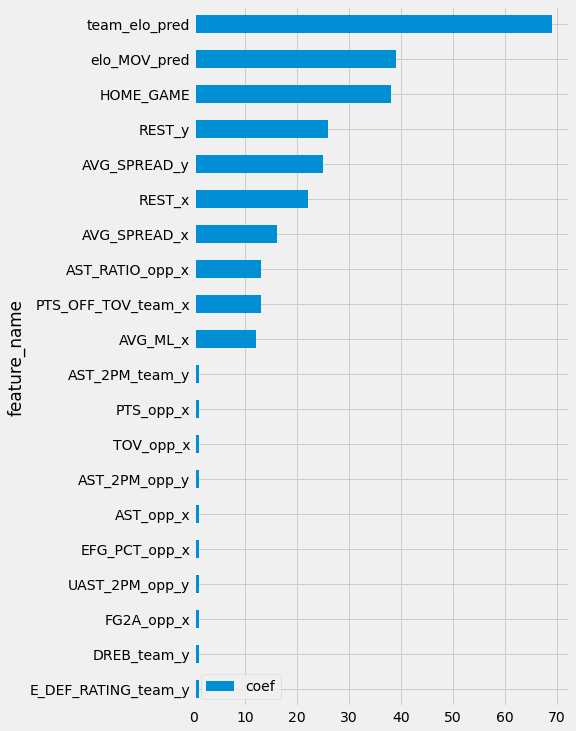

In [201]:
lgbr_params = study_lgbr.best_trial.params
lgbr_params['random_state'] = 23
best_lgbr = lgb.LGBMRegressor()
best_lgbr.set_params(**lgbr_params)
print("best_lgbr:", best_lgbr)

best_lgbr.fit(X_train, y_train)

lgbr_train_preds = best_lgbr.predict(X_train)
lgbr_test_preds = best_lgbr.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, lgbr_train_preds))
print("test_MAE:", mean_absolute_error(y_test, lgbr_test_preds))



view_model_coefs(best_lgbr, X_train)


In [58]:
from sklearn.decomposition import PCA


### KNNeighbors

In [202]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    pca__n_components = trial.suggest_int('n_components', 5, 50)
    
    regression_obj = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=pca__n_components)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=n_neighbors))]) 
    
    score = cross_val_score(regression_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_knn_reg'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 51, 2).tolist(),
               'n_components':np.arange(5, 50, 3).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

[I 2021-11-02 18:03:27,889] A new study created in RDB with name: study_knn_reg
[I 2021-11-02 18:03:29,128] Trial 0 finished with value: -10.050188425997627 and parameters: {'n_neighbors': 33, 'n_components': 5}. Best is trial 0 with value: -10.050188425997627.
[I 2021-11-02 18:03:32,207] Trial 1 finished with value: -10.038829612361397 and parameters: {'n_neighbors': 19, 'n_components': 14}. Best is trial 1 with value: -10.038829612361397.
[I 2021-11-02 18:03:35,166] Trial 2 finished with value: -9.911754684838161 and parameters: {'n_neighbors': 25, 'n_components': 29}. Best is trial 2 with value: -9.911754684838161.
[I 2021-11-02 18:03:37,000] Trial 3 finished with value: -10.844679159568427 and parameters: {'n_neighbors': 5, 'n_components': 11}. Best is trial 2 with value: -9.911754684838161.
[I 2021-11-02 18:03:40,189] Trial 4 finished with value: -9.819470966549133 and parameters: {'n_neighbors': 43, 'n_components': 47}. Best is trial 4 with value: -9.819470966549133.
[I 2021-11-0

[I 2021-11-02 18:05:18,759] Trial 42 finished with value: -9.961002797232211 and parameters: {'n_neighbors': 27, 'n_components': 20}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:05:19,707] Trial 43 finished with value: -10.549168491928288 and parameters: {'n_neighbors': 7, 'n_components': 5}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:05:22,646] Trial 44 finished with value: -10.079874402912784 and parameters: {'n_neighbors': 17, 'n_components': 26}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:05:25,676] Trial 45 finished with value: -9.92502366079879 and parameters: {'n_neighbors': 39, 'n_components': 26}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:05:27,250] Trial 46 finished with value: -9.986316911773228 and parameters: {'n_neighbors': 49, 'n_components': 8}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:05:30,096] Trial 47 finished with value: -10.082827938671212 and param

[I 2021-11-02 18:07:13,785] Trial 84 finished with value: -9.91752918165184 and parameters: {'n_neighbors': 45, 'n_components': 26}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:07:16,747] Trial 85 finished with value: -9.94326012554292 and parameters: {'n_neighbors': 37, 'n_components': 17}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:07:19,699] Trial 86 finished with value: -10.049113137588936 and parameters: {'n_neighbors': 17, 'n_components': 17}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:07:22,864] Trial 87 finished with value: -9.865834629533616 and parameters: {'n_neighbors': 23, 'n_components': 38}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:07:25,914] Trial 88 finished with value: -10.022057272653523 and parameters: {'n_neighbors': 21, 'n_components': 26}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:07:28,856] Trial 89 finished with value: -9.976168843460155 and para

[I 2021-11-02 18:09:07,177] Trial 126 finished with value: -10.02383287732521 and parameters: {'n_neighbors': 33, 'n_components': 11}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:09:08,187] Trial 127 finished with value: -10.088954003407155 and parameters: {'n_neighbors': 25, 'n_components': 5}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:09:11,290] Trial 128 finished with value: -9.87283051984926 and parameters: {'n_neighbors': 33, 'n_components': 29}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:09:14,366] Trial 129 finished with value: -9.840856488280561 and parameters: {'n_neighbors': 29, 'n_components': 38}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:09:17,170] Trial 130 finished with value: -10.055392991949763 and parameters: {'n_neighbors': 17, 'n_components': 14}. Best is trial 14 with value: -9.806464858253616.
[I 2021-11-02 18:09:19,513] Trial 131 finished with value: -9.991321420372852 an

[I 2021-11-02 18:11:06,039] Trial 168 finished with value: -9.9899173449429 and parameters: {'n_neighbors': 45, 'n_components': 8}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:11:09,181] Trial 169 finished with value: -9.85437365133447 and parameters: {'n_neighbors': 25, 'n_components': 38}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:11:12,205] Trial 170 finished with value: -9.836631964161777 and parameters: {'n_neighbors': 45, 'n_components': 29}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:11:15,250] Trial 171 finished with value: -10.004542873367404 and parameters: {'n_neighbors': 13, 'n_components': 38}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:11:18,341] Trial 172 finished with value: -9.83903085368162 and parameters: {'n_neighbors': 33, 'n_components': 44}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:11:21,269] Trial 173 finished with value: -10.111281468862389 

[I 2021-11-02 18:13:00,040] Trial 210 finished with value: -10.008808420162962 and parameters: {'n_neighbors': 43, 'n_components': 5}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:13:01,486] Trial 211 finished with value: -10.211636744856506 and parameters: {'n_neighbors': 13, 'n_components': 8}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:13:03,057] Trial 212 finished with value: -9.993286055755846 and parameters: {'n_neighbors': 43, 'n_components': 8}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:13:06,124] Trial 213 finished with value: -9.844613346146566 and parameters: {'n_neighbors': 39, 'n_components': 29}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:13:09,182] Trial 214 finished with value: -9.820566597261656 and parameters: {'n_neighbors': 45, 'n_components': 41}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:13:12,091] Trial 215 finished with value: -10.0069896057082

[I 2021-11-02 18:15:03,389] Trial 252 finished with value: -10.194298693923907 and parameters: {'n_neighbors': 15, 'n_components': 11}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:15:06,842] Trial 253 finished with value: -9.93759561746334 and parameters: {'n_neighbors': 17, 'n_components': 41}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:15:10,557] Trial 254 finished with value: -9.907035476254519 and parameters: {'n_neighbors': 19, 'n_components': 44}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:15:14,485] Trial 255 finished with value: -9.970157107703958 and parameters: {'n_neighbors': 15, 'n_components': 44}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:15:18,227] Trial 256 finished with value: -9.837477384678367 and parameters: {'n_neighbors': 43, 'n_components': 29}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:15:20,937] Trial 257 finished with value: -10.133674048835

[I 2021-11-02 18:17:24,699] Trial 294 finished with value: -9.82724714493028 and parameters: {'n_neighbors': 45, 'n_components': 44}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:17:27,962] Trial 295 finished with value: -9.966743602425309 and parameters: {'n_neighbors': 31, 'n_components': 23}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:17:31,425] Trial 296 finished with value: -9.844469682629818 and parameters: {'n_neighbors': 27, 'n_components': 47}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:17:35,402] Trial 297 finished with value: -10.057709978834339 and parameters: {'n_neighbors': 11, 'n_components': 35}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:17:38,519] Trial 298 finished with value: -9.997168627761711 and parameters: {'n_neighbors': 43, 'n_components': 11}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:17:41,772] Trial 299 finished with value: -9.9680863145939

[I 2021-11-02 18:19:29,572] Trial 336 finished with value: -10.147663426529045 and parameters: {'n_neighbors': 17, 'n_components': 5}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:19:33,000] Trial 337 finished with value: -10.562873367404885 and parameters: {'n_neighbors': 5, 'n_components': 44}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:19:36,215] Trial 338 finished with value: -9.89427059983861 and parameters: {'n_neighbors': 19, 'n_components': 32}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:19:38,600] Trial 339 finished with value: -10.05895850421688 and parameters: {'n_neighbors': 27, 'n_components': 11}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:19:41,880] Trial 340 finished with value: -9.917209121611524 and parameters: {'n_neighbors': 19, 'n_components': 41}. Best is trial 152 with value: -9.802554207372898.
[I 2021-11-02 18:19:45,049] Trial 341 finished with value: -9.99052985628794

In [203]:
best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']
print("best_n_neighbors:", best_n, "best_n_components:", best_n_components)



best_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=best_n_components)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=best_n))]) 

best_knn.fit(X_train, y_train)

knn_train_preds = best_knn.predict(X_train)
knn_test_preds = best_knn.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, knn_train_preds))
print("test_MAE:", mean_absolute_error(y_test, knn_test_preds))


best_n_neighbors: 49 best_n_components: 32
train_MAE: 9.596953743170403
test_MAE: 10.662470544665593


### Random Forest

In [204]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    regression_obj = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23)
    
    score = cross_val_score(regression_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='neg_mean_absolute_error')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = 'study_rf3'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=200)

[I 2021-11-02 18:20:51,854] A new study created in RDB with name: study_rf3
[I 2021-11-02 18:21:12,099] Trial 0 finished with value: -9.746642465353961 and parameters: {'min_samples_split': 0.17051909433317, 'max_depth': 13, 'min_samples_leaf': 0.2231882137601997}. Best is trial 0 with value: -9.746642465353961.
[I 2021-11-02 18:21:12,889] Trial 1 finished with value: -10.953089376297191 and parameters: {'min_samples_split': 0.21506221265987294, 'max_depth': 27, 'min_samples_leaf': 0.38588695101435566}. Best is trial 0 with value: -9.746642465353961.
[I 2021-11-02 18:21:13,666] Trial 2 finished with value: -10.953089376297191 and parameters: {'min_samples_split': 0.25307321402967736, 'max_depth': 7, 'min_samples_leaf': 0.35348170433732723}. Best is trial 0 with value: -9.746642465353961.
[I 2021-11-02 18:21:14,440] Trial 3 finished with value: -10.953089376297191 and parameters: {'min_samples_split': 0.2983389780237796, 'max_depth': 24, 'min_samples_leaf': 0.48154169165106314}. Best is

[I 2021-11-02 18:41:20,073] Trial 32 finished with value: -9.432700742330379 and parameters: {'min_samples_split': 0.049696676422506414, 'max_depth': 8, 'min_samples_leaf': 0.04000906354173932}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 18:42:10,692] Trial 33 finished with value: -9.455996861920758 and parameters: {'min_samples_split': 0.01490987388643716, 'max_depth': 6, 'min_samples_leaf': 0.0655951872904657}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 18:43:20,617] Trial 34 finished with value: -9.426733032842924 and parameters: {'min_samples_split': 0.08350398174813584, 'max_depth': 5, 'min_samples_leaf': 0.022421151740260395}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 18:44:07,193] Trial 35 finished with value: -9.464627609546957 and parameters: {'min_samples_split': 0.01013234463696352, 'max_depth': 10, 'min_samples_leaf': 0.08124507381512559}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 18:44:07,909] Tr

[I 2021-11-02 19:08:05,505] Trial 65 finished with value: -9.425778849285386 and parameters: {'min_samples_split': 0.0728703775183436, 'max_depth': 4, 'min_samples_leaf': 0.011886657680820829}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:09:17,105] Trial 66 finished with value: -9.424358122783492 and parameters: {'min_samples_split': 0.053449790151384055, 'max_depth': 4, 'min_samples_leaf': 0.010677303516030655}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:10:06,686] Trial 67 finished with value: -9.454550926323304 and parameters: {'min_samples_split': 0.04144143526194252, 'max_depth': 3, 'min_samples_leaf': 0.06398963777332281}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:11:11,087] Trial 68 finished with value: -9.432654608951962 and parameters: {'min_samples_split': 0.05659972961311016, 'max_depth': 4, 'min_samples_leaf': 0.04010253570309817}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:11:49,059] Tr

[I 2021-11-02 19:38:26,146] Trial 98 finished with value: -9.47412019676787 and parameters: {'min_samples_split': 0.25339722859227254, 'max_depth': 12, 'min_samples_leaf': 0.02117873182110859}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:39:36,434] Trial 99 finished with value: -9.43505429105155 and parameters: {'min_samples_split': 0.020535314489632056, 'max_depth': 7, 'min_samples_leaf': 0.04418484986695231}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:40:31,132] Trial 100 finished with value: -9.45908659753726 and parameters: {'min_samples_split': 0.14387038914540834, 'max_depth': 4, 'min_samples_leaf': 0.061630243914187074}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:41:53,290] Trial 101 finished with value: -9.424059162491393 and parameters: {'min_samples_split': 0.07144871665724038, 'max_depth': 5, 'min_samples_leaf': 0.01947757950507572}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 19:43:03,559] Tr

[I 2021-11-02 20:18:51,343] Trial 130 finished with value: -9.449550122956078 and parameters: {'min_samples_split': 0.04442594827444224, 'max_depth': 12, 'min_samples_leaf': 0.05526135793611522}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 20:20:23,777] Trial 131 finished with value: -9.424069024606855 and parameters: {'min_samples_split': 0.05494310530297835, 'max_depth': 10, 'min_samples_leaf': 0.019872053910982564}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 20:21:51,290] Trial 132 finished with value: -9.425767573000883 and parameters: {'min_samples_split': 0.010410753611873123, 'max_depth': 9, 'min_samples_leaf': 0.026743510338272797}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 20:23:23,697] Trial 133 finished with value: -9.424287088586127 and parameters: {'min_samples_split': 0.05675923018658782, 'max_depth': 11, 'min_samples_leaf': 0.01844281574750843}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 20:25:12

[I 2021-11-02 20:57:38,402] Trial 162 finished with value: -9.4244371059772 and parameters: {'min_samples_split': 0.04677082877357019, 'max_depth': 12, 'min_samples_leaf': 0.018374310058659353}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 20:59:21,824] Trial 163 finished with value: -9.426126823195618 and parameters: {'min_samples_split': 0.046039969474394024, 'max_depth': 12, 'min_samples_leaf': 0.010347549429931859}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 21:00:46,591] Trial 164 finished with value: -9.426709645280349 and parameters: {'min_samples_split': 0.03509498425764296, 'max_depth': 21, 'min_samples_leaf': 0.027860834784106576}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 21:02:01,455] Trial 165 finished with value: -9.432765318016308 and parameters: {'min_samples_split': 0.022318675850072554, 'max_depth': 12, 'min_samples_leaf': 0.040607528696721025}. Best is trial 31 with value: -9.42268793506042.
[I 2021-11-02 21:03:

[I 2021-11-02 21:40:32,781] Trial 194 finished with value: -9.426628914512984 and parameters: {'min_samples_split': 0.0458041038657811, 'max_depth': 9, 'min_samples_leaf': 0.021727437752972364}. Best is trial 174 with value: -9.422613205538447.
[I 2021-11-02 21:41:37,477] Trial 195 finished with value: -9.433883826579855 and parameters: {'min_samples_split': 0.060200587581663446, 'max_depth': 10, 'min_samples_leaf': 0.04186598785493521}. Best is trial 174 with value: -9.422613205538447.
[I 2021-11-02 21:42:54,182] Trial 196 finished with value: -9.426205574899033 and parameters: {'min_samples_split': 0.03357835631363777, 'max_depth': 11, 'min_samples_leaf': 0.027181698687722432}. Best is trial 174 with value: -9.422613205538447.
[I 2021-11-02 21:44:11,723] Trial 197 finished with value: -9.424881127149188 and parameters: {'min_samples_split': 0.06937906875607604, 'max_depth': 12, 'min_samples_leaf': 0.018523895648494507}. Best is trial 174 with value: -9.422613205538447.
[I 2021-11-02 

In [205]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = RandomForestRegressor(max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                random_state=23)

best_rf.fit(X_train, y_train)

rf_train_preds = best_rf.predict(X_train)
rf_test_preds = best_rf.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, rf_train_preds))
print("test_MAE:", mean_absolute_error(y_test, rf_test_preds))

{'max_depth': 8, 'min_samples_leaf': 0.017235951865733797, 'min_samples_split': 0.03499453836125677}
rf train_acc: 0.21592229417762032
rf test_acc: 0.15974234439868995


rf train_acc: 0.6232086851628468
rf test_acc: 0.5110964984382705


LGBoost or XGBoost


feature_name      coef
20      POSS_team_x  0.000038
150  AVG_ATS_DIFF_y  0.000047
144  ATS_DIFF_opp_y  0.000064
63         WL_PCT_x  0.000073
46        PTS_opp_x  0.000074
..              ...       ...
38       OREB_opp_x  0.001791
54     PTS_FB_opp_x  0.002818
137    PTS_FB_opp_y  0.003257
169    elo_MOV_pred  0.006515
166   team_elo_pred  0.907905

[170 rows x 2 columns]

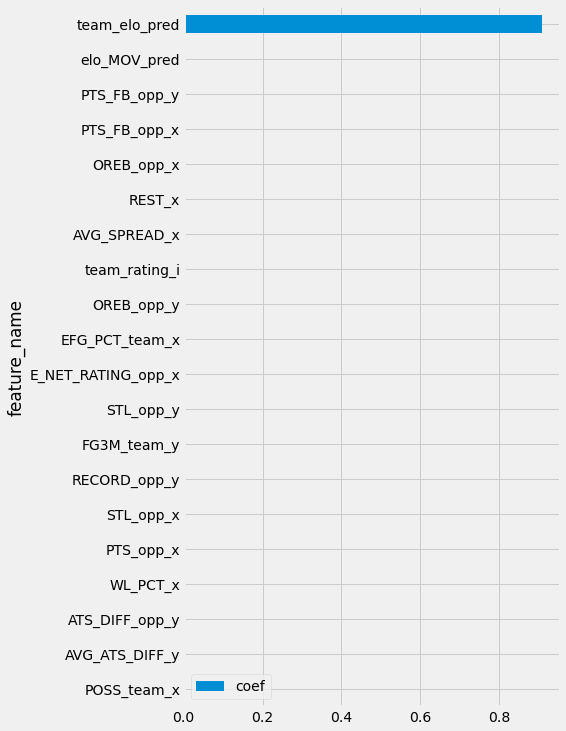

In [206]:
view_model_coefs(best_rf, X_train)

## Stacked Classifier

### new_version

In [207]:
estimators = [('ridge', best_ridge), ('sgd', best_sgd),
              ('lgbr', best_lgbr), ('knn', best_knn), ('rf', best_rf)]


stacked_reg = StackingRegressor(estimators = estimators,
                                 n_jobs=-1, verbose=1)


stacked_reg.fit(X_train, y_train)


stacked_train_preds = stacked_reg.predict(X_train)
stacked_test_preds = stacked_reg.predict(X_test)

print("train_MAE:", mean_absolute_error(y_train, stacked_train_preds))
print("test_MAE:", mean_absolute_error(y_test, stacked_test_preds))

train_MAE: 9.286737118583451
test_MAE: 10.231135243130463


In [209]:
df_ewm_19

SEASON  TEAM_ID_team_x TEAM_ABBREVIATION        TEAM_NAME_team_x  \
0      2006-07      1610612741               CHI           Chicago Bulls   
1      2006-07      1610612748               MIA              Miami Heat   
2      2006-07      1610612747               LAL      Los Angeles Lakers   
3      2006-07      1610612756               PHX            Phoenix Suns   
4      2006-07      1610612755               PHI      Philadelphia 76ers   
...        ...             ...               ...                     ...   
34139  2021-22      1610612743               DEN          Denver Nuggets   
34140  2021-22      1610612750               MIN  Minnesota Timberwolves   
34141  2021-22      1610612753               ORL           Orlando Magic   
34142  2021-22      1610612746               LAC             LA Clippers   
34143  2021-22      1610612760               OKC   Oklahoma City Thunder   

          GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  \
0      0020600001 2006-10-31    CHI @ MIA          0         108   
1      0020600001 2006-10-31  MIA vs. CHI          1          66   
2      0020600002 2006-10-31  LAL vs. PHX          1         114   
3      0020600002 2006-10-31    PHX @ LAL          0         106   
4      0020600003 2006-11-01  PHI vs. ATL          1          88   
...           ...        ...          ...        ...         ...   
34139  0022100100 2021-11-01    DEN @ MEM          0          97   
34140  0022100101 2021-11-01  MIN vs. ORL          1          97   
34141  0022100101 2021-11-01    ORL @ MIN          0         115   
34142  0022100102 2021-11-01  LAC vs. OKC          1          99   
34143  0022100102 2021-11-01    OKC @ LAC          0          94   

       POINT_DIFF_team  WL_team_x  ML_team_x  SPREAD_team_x  \
0                   42          1   2.800000            4.5   
1                  -42          0   1.454545           -4.5   
2                    8          1   3.900000            8.5   
3                   -8          0   1.263158           -8.5   
4                   13          1   1.416667           -6.0   
...                ...        ...        ...            ...   
34139               -9          0   2.150000           -1.5   
34140              -18          0   1.238095           -9.0   
34141               18          1   4.200000            9.0   
34142                5          1   1.089686          -13.0   
34143               -5          0   8.500000           13.0   

       TEAM_COVERED_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
0                        1            NaN          NaN          NaN   
1                        0            NaN          NaN          NaN   
2                        1            NaN          NaN          NaN   
3                        0            NaN          NaN          NaN   
4                        1            NaN          NaN          NaN   
...                    ...            ...          ...          ...   
34139                    0       0.671546    29.789361    50.274386   
34140                    0       0.558008    24.102366    47.918464   
34141                    1       0.125761    23.289244    48.301273   
34142                    0       0.197797    25.235232    50.641401   
34143                    1       0.192078    25.190687    49.815976   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
0              NaN          NaN         NaN         NaN          NaN   
1              NaN          NaN         NaN         NaN          NaN   
2              NaN          NaN         NaN         NaN          NaN   
3              NaN          NaN         NaN         NaN          NaN   
4              NaN          NaN         NaN         NaN          NaN   
...            ...          ...         ...         ...          ...   
34139    10.565207    34.679541    9.630580   14.182037     8.400381   
34140    13.698225    42.644575   14.097434   18.021318    12.433469   
34141    14.182875  

0
test set 1: 2016-10-27 - 2017-06-12


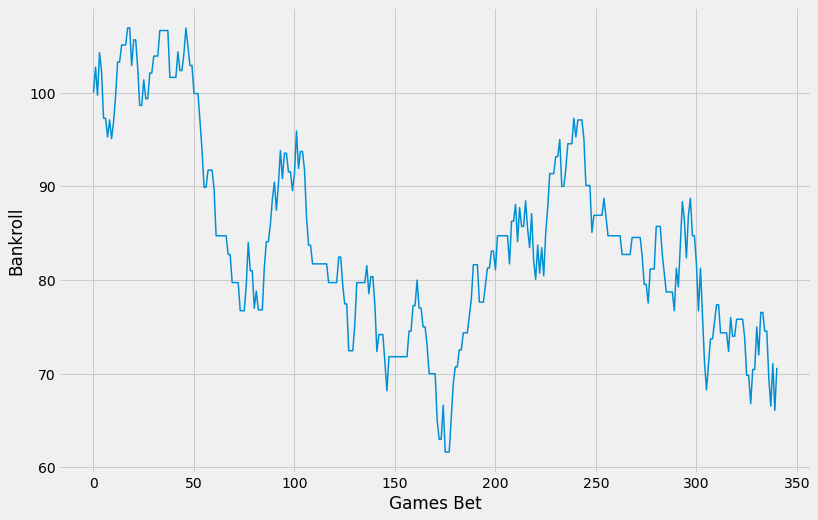

min balance: 61.6363636363637 
max balance: 106.90909090909093 
final balance: 65.6363636363637 
win percentage 48.089999999999996 
profit: -34.363636363636374 risk: 588.0 
ROI: -5.84
1
test set 1: 2017-10-20 - 2018-06-08


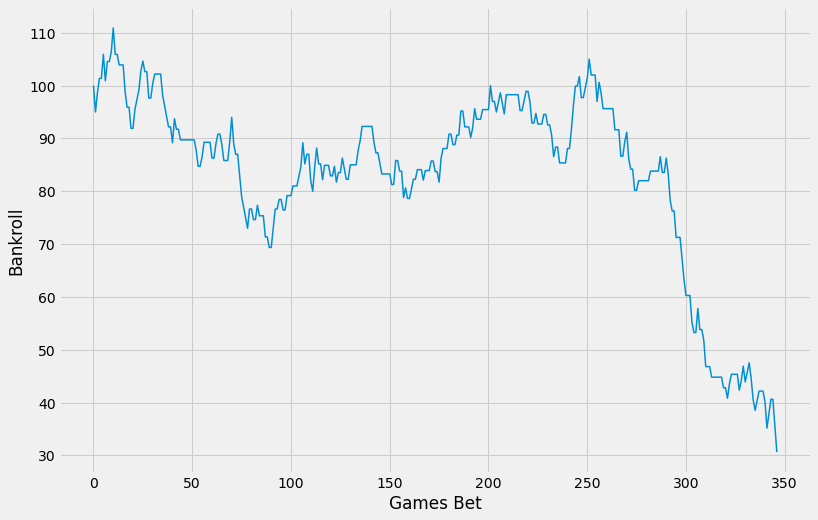

min balance: 30.636363636363626 
max balance: 110.90909090909092 
final balance: 33.36363636363635 
win percentage 48.99 
profit: -66.63636363636365 risk: 584.0 
ROI: -11.41
2
test set 1: 2018-10-19 - 2019-06-13


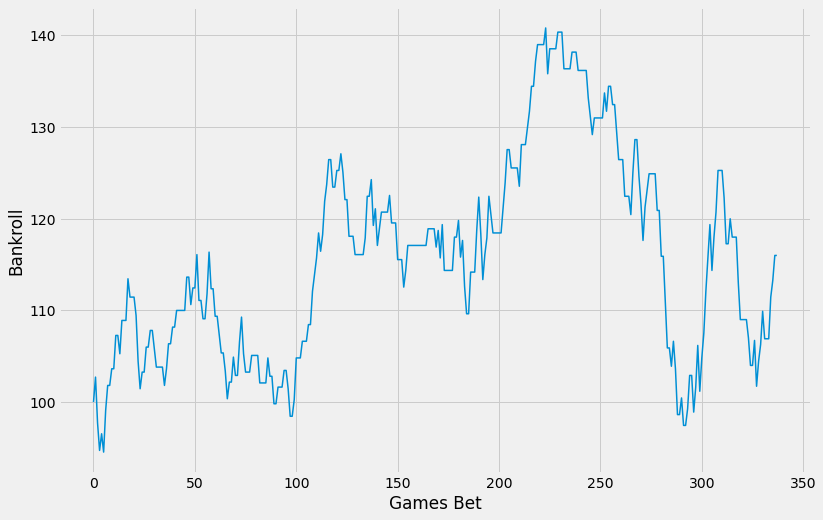

min balance: 94.54545454545455 
max balance: 140.81818181818176 
final balance: 115.99999999999996 
win percentage 53.25 
profit: 16.0 risk: 593.0 
ROI: 2.7
3
test set 1: 2019-10-25 - 2020-10-11


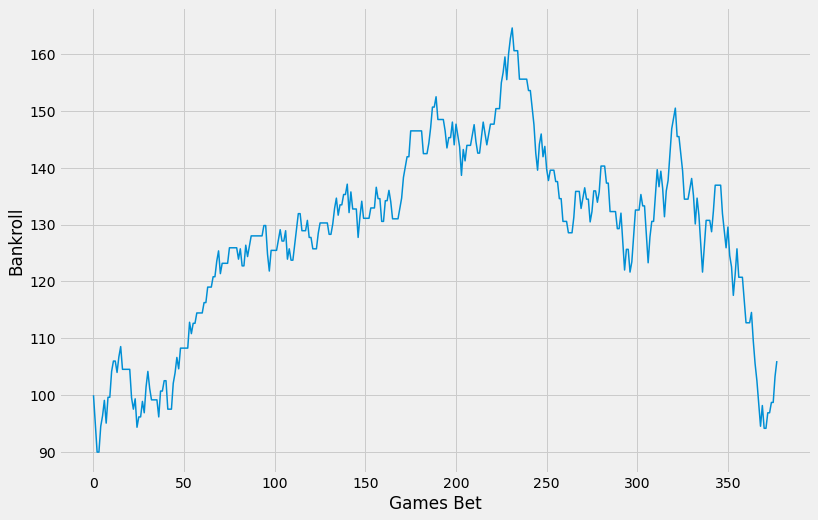

min balance: 90.0 
max balance: 164.54545454545422 
final balance: 105.99999999999943 
win percentage 53.169999999999995 
profit: 5.999999999999943 risk: 771.0 
ROI: 0.7799999999999999
4
test set 1: 2020-12-25 - 2021-07-20


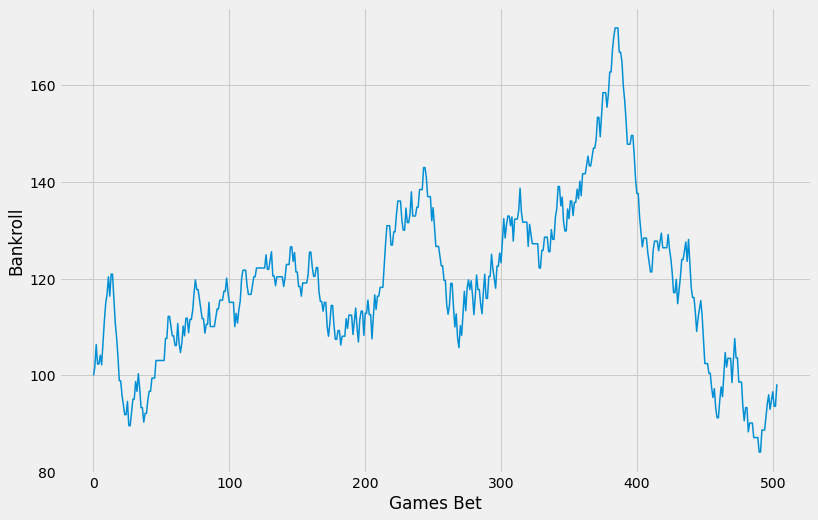

min balance: 84.18181818181785 
max balance: 171.7272727272724 
final balance: 99.99999999999966 
win percentage 51.39 
profit: 0.0 risk: 1113.0 
ROI: 0.0

 StackingRegressor(estimators=[('ridge',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('ridge',
                                                Ridge(alpha=99.94629165081645))])),
                              ('sgd',
                               Pipeline(steps=[('scaler', StandardScaler()),
                                               ('sgd',
                                                SGDRegressor(alpha=0.0006464984652400955,
                                                             epsilon=0.23437109621372237,
                                                             loss='huber',
                                                             max_iter=10000,
                                                             penalty='l1',
        

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)               3  0.480938            341 -0.058442   
1  (2017, -, 2018)               3  0.489914            347 -0.114103   
2  (2018, -, 2019)               3  0.532544            338  0.026981   
3  (2019, -, 2020)               3  0.531746            378  0.007782   
4  (2020, -, 2021)               3  0.513889            504  0.000000   

     profits  
0 -34.363636  
1 -66.636364  
2  16.000000  
3   6.000000  
4   0.000000

In [216]:
estimators = [('ridge', best_ridge), ('sgd', best_sgd),
              ('lgbr', best_lgbr), ('knn', best_knn), ('rf', best_rf)]

stacked_reg = StackingRegressor(estimators = estimators,
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 3

for estimator in [stacked_reg]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        
        y_preds = estimator.predict(X_test1)

        
        betting_df = create_betting_df(df_ewm_19, y_preds, test_idx1)

        
        select_bets = betting_df.loc[np.abs(betting_df['spread_pred_diff'])>threshold]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [217]:
ridge_preds = best_ridge.predict(X_test)
stacked_preds = stacked_reg.predict(X_test)
betting_df_stacked = create_betting_df(df_ewm_19, stacked_preds, test_idx)

betting_df_stacked

GAME_ID MATCHUP_home  SPREAD_home  SCORE_home  SCORE_away  \
0     0021600016  SAC vs. SAS          8.5          94         102   
1     0021600018  TOR vs. CLE          3.5          91          94   
2     0021600019  BKN vs. IND          6.5         103          94   
3     0021600020  DET vs. ORL         -4.0         108          82   
4     0021600021  OKC vs. PHX         -8.0         113         110   
...          ...          ...          ...         ...         ...   
6222  0022100098  BOS vs. CHI         -4.5         114         128   
6223  0022100099  NYK vs. TOR         -8.5         104         113   
6224  0022100100  MEM vs. DEN          1.5         106          97   
6225  0022100101  MIN vs. ORL         -9.0          97         115   
6226  0022100102  LAC vs. OKC        -13.0          99          94   

      POINT_DIFF_home  cover_home  pred_home  pred_away   pred_avg  bet_home  \
0                  -8           1  -1.992406   1.606567  -1.799486         1   
1                  -3           1  -4.226753   4.173792  -4.200273         0   
2                   9           1  -8.378346   8.391536  -8.384941         0   
3                  26           1   4.737413  -4.495220   4.616317         1   
4                   3           0  11.519929 -11.206693  11.363311         1   
...               ...         ...        ...        ...        ...       ...   
6222              -14           0   1.618930  -1.485532   1.552231         0   
6223               -9           0   4.478394  -4.540150   4.509272         0   
6224                9           1   0.449388  -0.324817   0.387102         1   
6225              -18           0  10.938703 -11.298605  11.118654         1   
6226                5           0  13.885291 -13.748549  13.816920         1   

      spread_pred_diff  bet_won  bankroll_i  bankroll_n  bet_size  
0             6.700514        1       100.0         NaN       NaN  
1            -0.700273        0         NaN         NaN       NaN  
2            -1.884941        0         NaN         NaN       NaN  
3             0.616317        1         NaN         NaN       NaN  
4             3.363311        0         NaN         NaN       NaN  
...                ...      ...         ...         ...       ...  
6222         -2.947769        1         NaN         NaN       NaN  
6223         -3.990728        1         NaN         NaN       NaN  
6224          1.887102        1         NaN         NaN       NaN  
6225          2.118654        0         NaN         NaN       NaN  
6226          0.816920        0         NaN         NaN       NaN  

[6115 rows x 16 columns]

In [230]:
season_21 = betting_df_stacked.loc[betting_df_stacked['GAME_ID'].str.startswith('00221')]

season_21_select = season_21.loc[abs(season_21['spread_pred_diff'])>3]

season_21_select

GAME_ID MATCHUP_home  SPREAD_home  SCORE_home  SCORE_away  \
6141  0022100017  CLE vs. CHA          3.0         112         123   
6144  0022100020  BOS vs. TOR         -6.5          83         115   
6145  0022100021  PHI vs. BKN          1.5         109         114   
6147  0022100023  HOU vs. OKC         -1.5         124          91   
6148  0022100024  DEN vs. SAS         -7.0         102          96   
6149  0022100025  LAL vs. PHX         -3.5         105         115   
6151  0022100027  CLE vs. ATL          7.0         101          95   
6153  0022100029  TOR vs. DAL          4.5          95         103   
6155  0022100031  MIN vs. NOP         -9.5          96          89   
6156  0022100032  SAS vs. MIL          6.0         111         121   
6158  0022100034  LAC vs. MEM         -4.0         114         120   
6159  0022100035  BKN vs. CHA         -8.5          95         111   
6161  0022100037  HOU vs. BOS          5.5          97         107   
6163  0022100039  SAC vs. GSW          5.0         107         119   
6166  0022100042  IND vs. MIL          4.0         109         119   
6170  0022100046  TOR vs. CHI          4.0         108         111   
6171  0022100047  MIN vs. NOP         -6.0          98         107   
6173  0022100049  LAC vs. POR         -4.5         116          86   
6175  0022100051  OKC vs. GSW         11.5          98         106   
6176  0022100052  DAL vs. HOU        -11.0         116         106   
6178  0022100054  UTA vs. DEN         -9.5         122         110   
6181  0022100057  BKN vs. MIA         -5.5          93         106   
6182  0022100058  TOR vs. IND          3.0         118         100   
6184  0022100060  MIL vs. MIN         -7.5         108         113   
6190  0022100066  WAS vs. ATL          6.0         122         111   
6196  0022100072  BKN vs. IND        -10.5         105          98   
6198  0022100074  NOP vs. SAC          1.5         109         113   
6200  0022100076  POR vs. LAC         -5.5         111          92   
6204  0022100080  NOP vs. NYK          9.5         117         123   
6205  0022100081  IND vs. TOR         -3.0          94          97   
6208  0022100084  MEM vs. MIA         -5.5         103         129   
6215  0022100091  MIL vs. UTA          7.0          95         107   
6216  0022100092  BKN vs. DET        -14.0         117          91   
6217  0022100093  LAL vs. HOU        -13.0          95          85   
6220  0022100096  PHI vs. POR          6.0         113         103   
6223  0022100099  NYK vs. TOR         -8.5         104         113   

      POINT_DIFF_home  cover_home  pred_home  pred_away   pred_avg  bet_home  \
6141              -11           0   0.994529  -0.780654   0.887591         1   
6144              -32           0   3.376206  -3.309944   3.343075         0   
6145               -5           0  10.044228  -9.858554   9.951391         1   
6147               33           1   6.200896  -6.134785   6.167841         1   
6148                6           0   1.745202  -1.423595   1.584399         0   
6149              -10           0  -1.203246   0.818097  -1.010671         0   
6151                6           1 -10.942185  11.008465 -10.975325         0   
6153               -8           0   5.319388  -5.014678   5.167033         1   
6155                7           0  14.153394 -13.955226  14.054310         1   
6156              -10           0  -0.032235   0.138029  -0.085132         1   
6158               -6           0   0.961876  -0.748972   0.855424         0   
6159              -16           0   3.624868  -3.448118   3.536493         0   
6161              -10           0   1.847453  -1.522956   1.685205         1   
6163              -12           0  -0.525408   0.632261  -0.578834         1   
6166              -10           0   1.835338  -1.801755   1.818546         1   
6170               -3           1  -0.106228   0.192491  -0.149360         1   
6171               -9           0  11.300782 -11.220252  1

stacked clf train_acc: 0.5640048250904705
stacked clf test_acc: 0.512938849513763
0
test set 1: 2016-10-27 - 2017-06-12


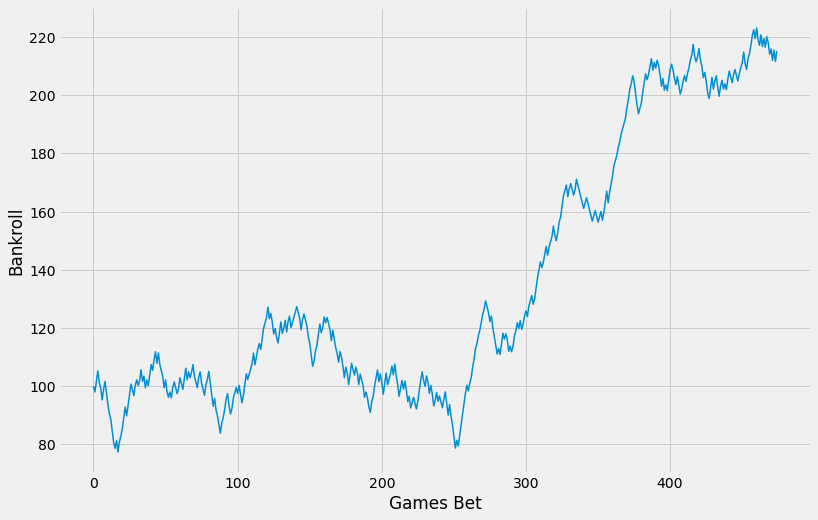

min balance: 77.36363636363639 
max balance: 223.0909090909086 
final balance: 211.18181818181765 
win percentage 55.78999999999999 
profit: 111.18181818181813 risk: 1397.0 
ROI: 7.960000000000001
1
test set 1: 2017-10-20 - 2018-06-08


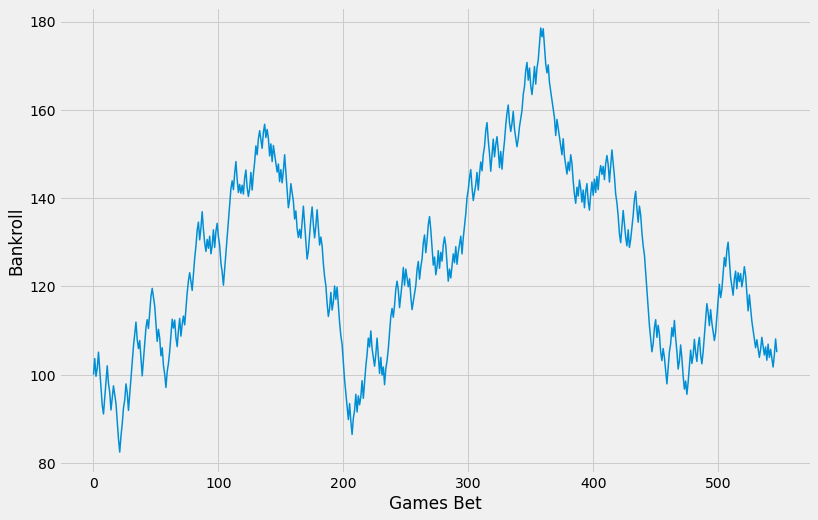

min balance: 82.45454545454548 
max balance: 178.54545454545396 
final balance: 102.0909090909083 
win percentage 51.28 
profit: 2.0909090909090082 risk: 1697.0 
ROI: 0.12
2
test set 1: 2018-10-19 - 2019-06-13


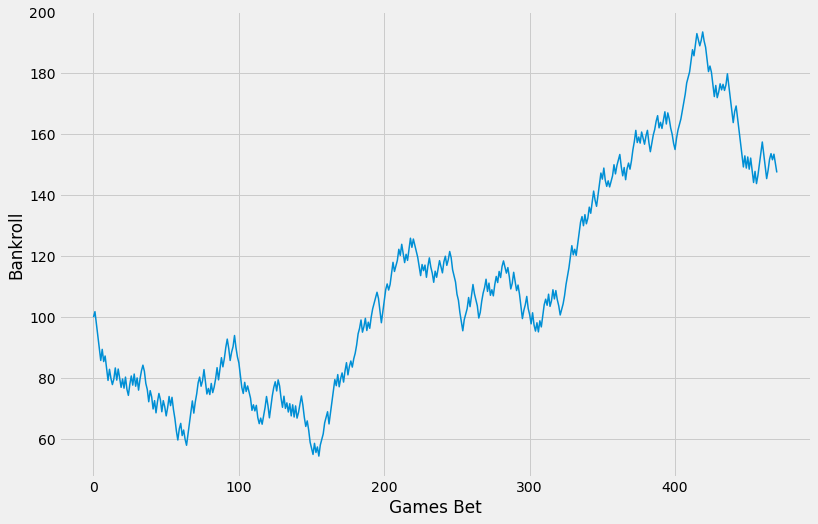

min balance: 54.45454545454561 
max balance: 193.54545454545445 
final balance: 149.272727272727 
win percentage 53.72 
profit: 49.27272727272725 risk: 1457.0 
ROI: 3.38
3
test set 1: 2019-10-25 - 2020-10-11


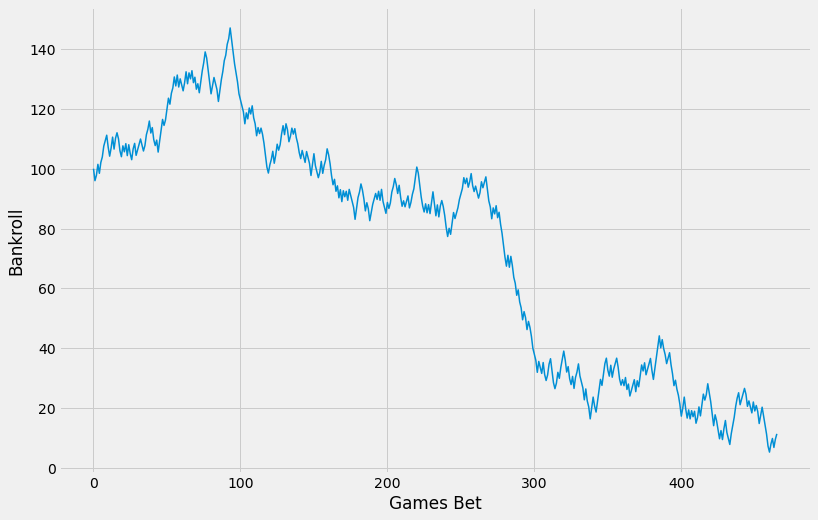

min balance: 5.363636363636289 
max balance: 146.99999999999986 
final balance: 14.181818181818105 
win percentage 48.93 
profit: -85.81818181818187 risk: 1405.0 
ROI: -6.11
4
test set 1: 2020-12-25 - 2021-07-20


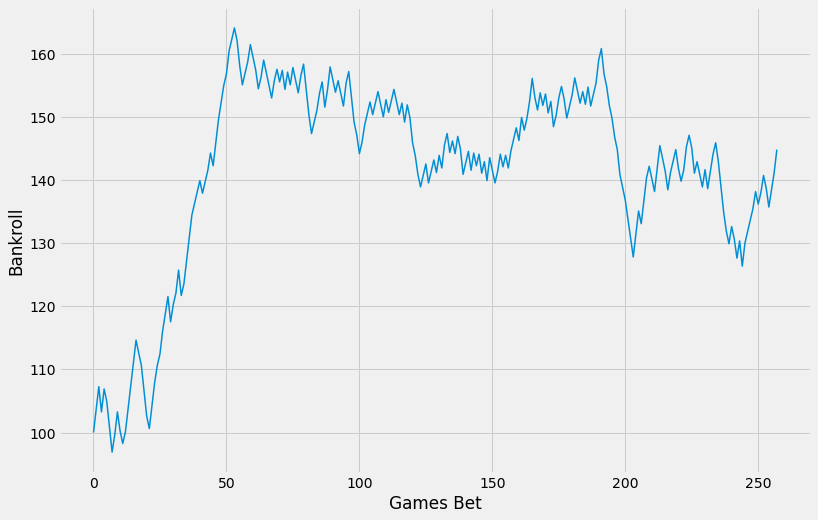

min balance: 96.90909090909092 
max balance: 164.09090909090904 
final balance: 147.5454545454538 
win percentage 54.65 
profit: 47.545454545454504 risk: 697.0 
ROI: 6.819999999999999
5
test set 1: 2021-10-22 - 2021-10-26


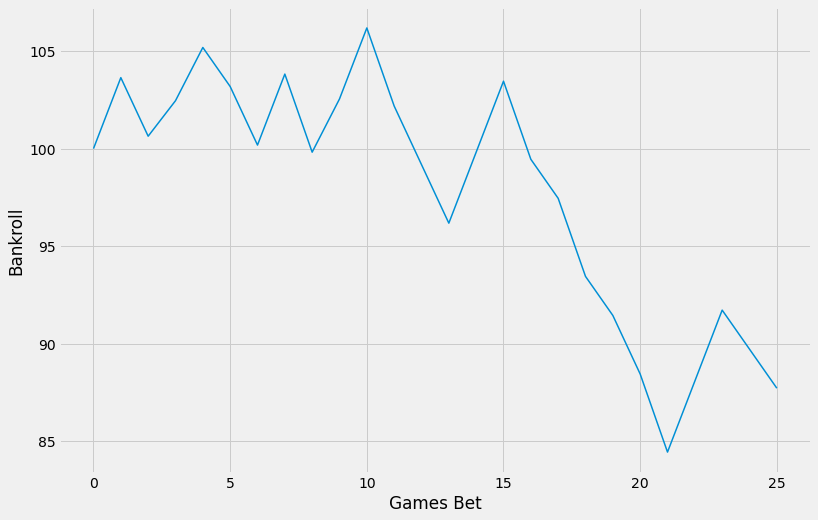

min balance: 83.72727272727276 
max balance: 106.1818181818182 
final balance: 83.72727272727276 
win percentage 38.46 
profit: -16.272727272727273 risk: 85.0 
ROI: -19.139999999999997

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.06226787404081285,
                                                                    max_iter=100000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                    

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.557895            475  0.079586   
1  (2017, -, 2018)            0.53  0.512774            548  0.001232   
2  (2018, -, 2019)            0.53  0.537155            471  0.033818   
3  (2019, -, 2020)            0.53  0.489270            466 -0.061081   
4  (2020, -, 2021)            0.53  0.546512            258  0.068214   
5  (2021, -, 2021)            0.53  0.384615             26 -0.191444   

      profits  
0  111.181818  
1    2.090909  
2   49.272727  
3  -85.818182  
4   47.545455  
5  -16.272727

In [414]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


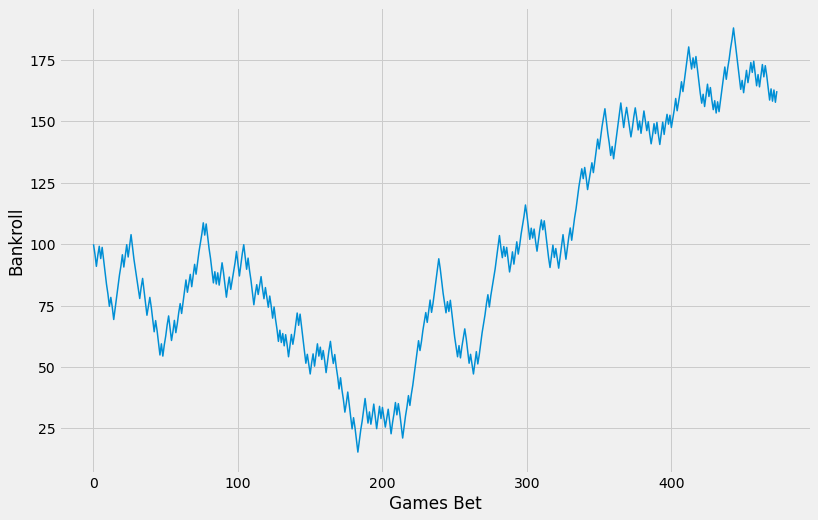

min balance: 15.36363636363648 
max balance: 188.09090909090864 
final balance: 157.36363636363575 
win percentage 53.800000000000004 
profit: 57.36363636363626 risk: 2203.0 
ROI: 2.6
1
test set 1: 2017-10-28 - 2018-06-08


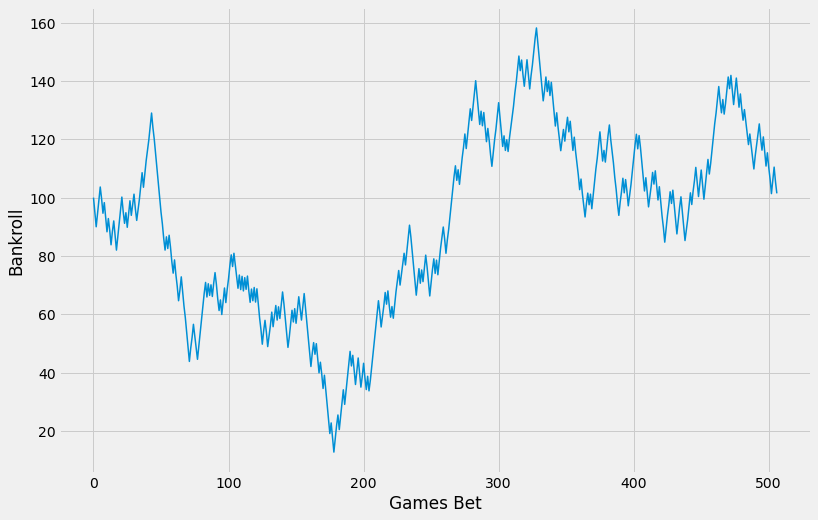

min balance: 12.727272727272808 
max balance: 158.18181818181813 
final balance: 97.45454545454537 
win percentage 52.27 
profit: -2.5454545454547315 risk: 2366.0 
ROI: -0.11
2
test set 1: 2018-10-26 - 2019-06-13


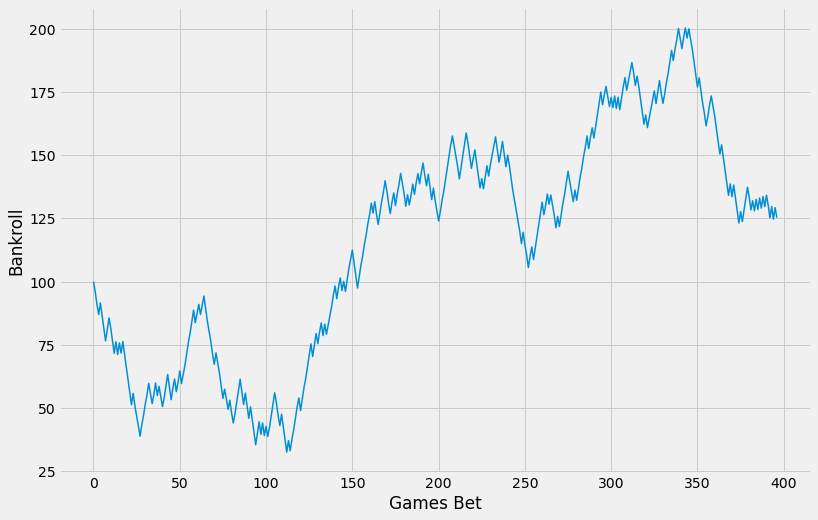

min balance: 32.545454545454554 
max balance: 200.3636363636354 
final balance: 128.90909090908974 
win percentage 52.900000000000006 
profit: 28.909090909090878 risk: 1821.0 
ROI: 1.59
3
test set 1: 2019-11-01 - 2020-10-11


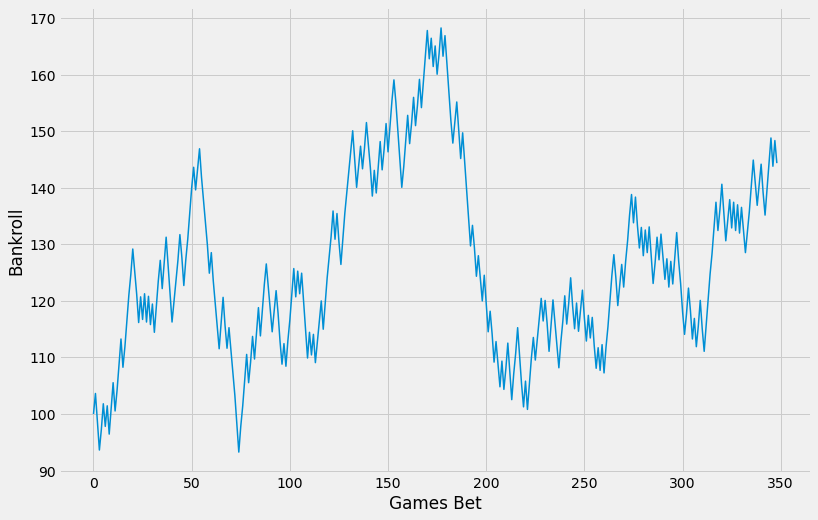

min balance: 93.27272727272727 
max balance: 168.27272727272694 
final balance: 147.9999999999994 
win percentage 54.15 
profit: 47.999999999999886 risk: 1590.0 
ROI: 3.02
4
test set 1: 2021-01-01 - 2021-07-20


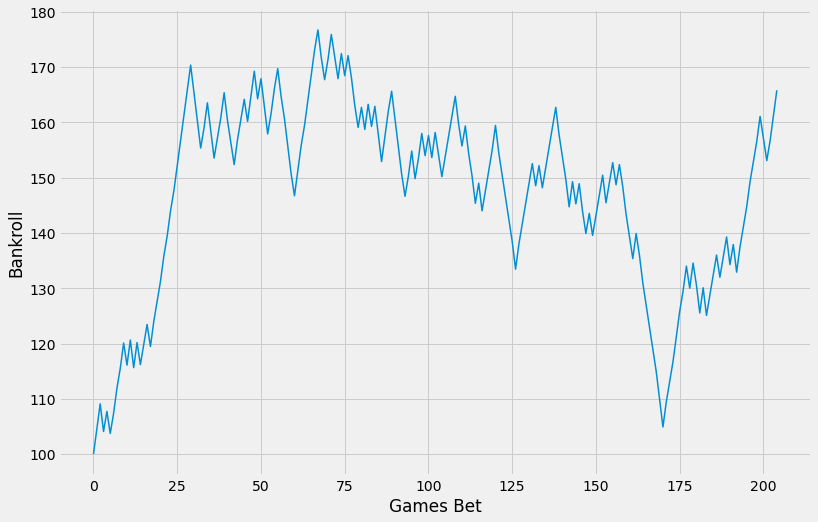

min balance: 103.72727272727273 
max balance: 176.7272727272724 
final balance: 170.36363636363532 
win percentage 56.589999999999996 
profit: 70.36363636363632 risk: 909.0 
ROI: 7.739999999999999

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.0011798799724438123,
                                                                    max_iter=10000,
                                                                    random_state=23,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                       

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537975            474  0.026039   
1  (2017, -, 2018)            0.53  0.522682            507 -0.001076   
2  (2018, -, 2019)            0.53  0.528967            397  0.015875   
3  (2019, -, 2020)            0.53  0.541547            349  0.030189   
4  (2021, -, 2021)            0.53  0.565854            205  0.077408   

     profits  
0  57.363636  
1  -2.545455  
2  28.909091  
3  48.000000  
4  70.363636

In [113]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [660]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


0
test set 1: 2016-11-04 - 2017-06-12


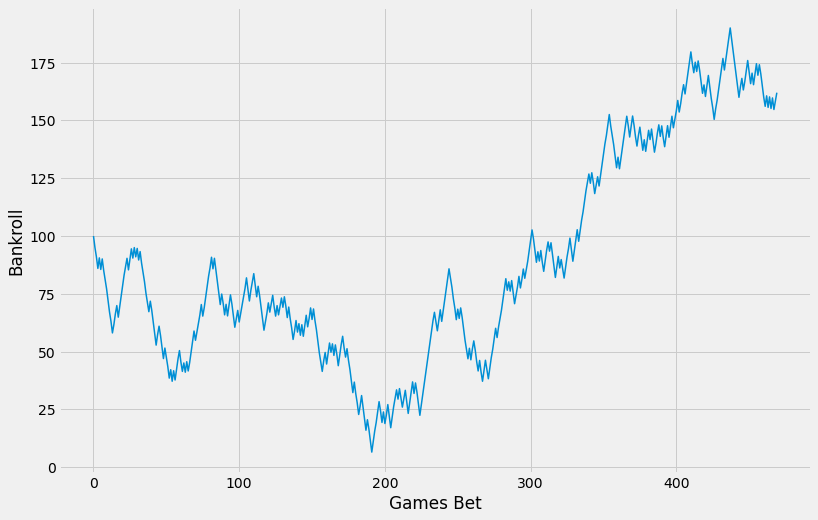

min balance: 6.545454545454625 
max balance: 189.99999999999957 
final balance: 165.63636363636303 
win percentage 53.620000000000005 
profit: 65.63636363636351 risk: 2189.0 
ROI: 3.0
1
test set 1: 2017-10-28 - 2018-06-08


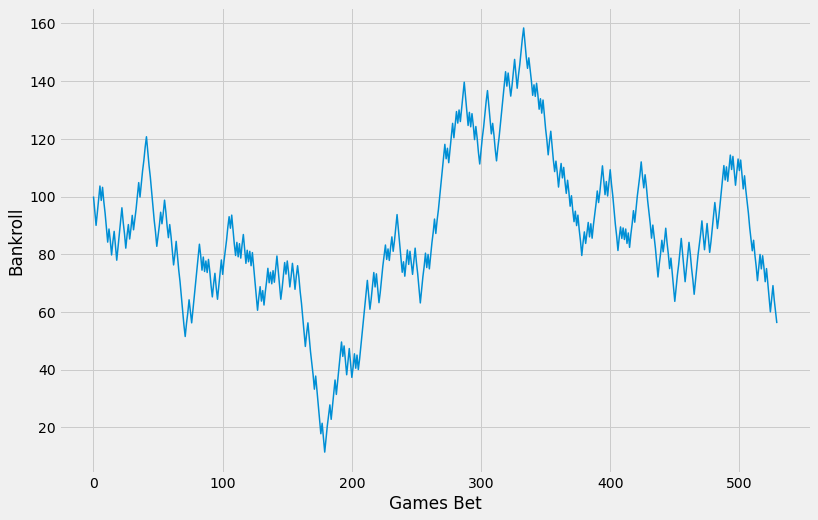

min balance: 11.36363636363652 
max balance: 158.45454545454544 
final balance: 52.09090909090921 
win percentage 51.32 
profit: -47.90909090909099 risk: 2482.0 
ROI: -1.9300000000000002
2
test set 1: 2018-10-26 - 2019-06-13


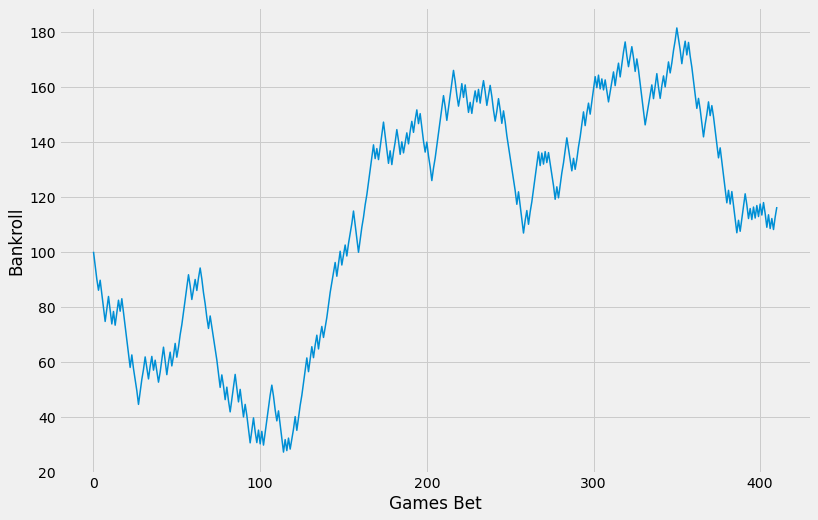

min balance: 27.090909090909136 
max balance: 181.4545454545445 
final balance: 119.90909090908988 
win percentage 52.55 
profit: 19.909090909090878 risk: 1893.0 
ROI: 1.05
3
test set 1: 2019-11-01 - 2020-10-11


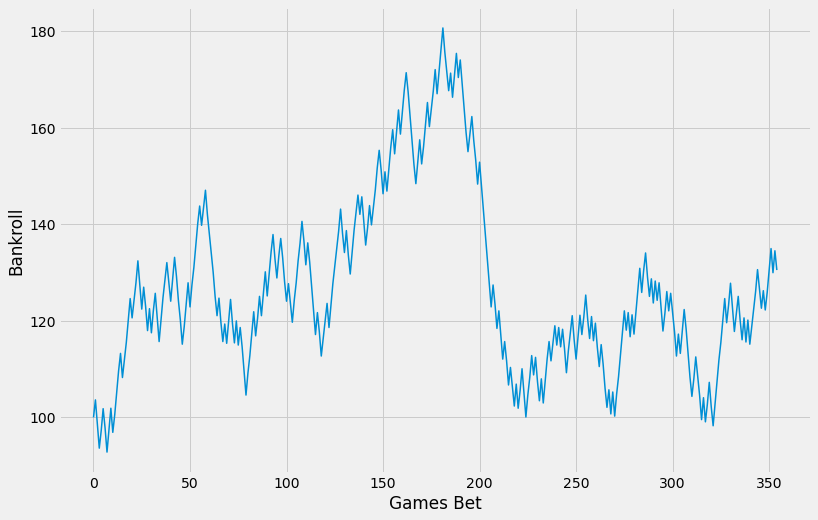

min balance: 92.81818181818183 
max balance: 180.7272727272722 
final balance: 134.18181818181765 
win percentage 53.52 
profit: 34.18181818181813 risk: 1621.0 
ROI: 2.11
4
test set 1: 2021-01-01 - 2021-07-20


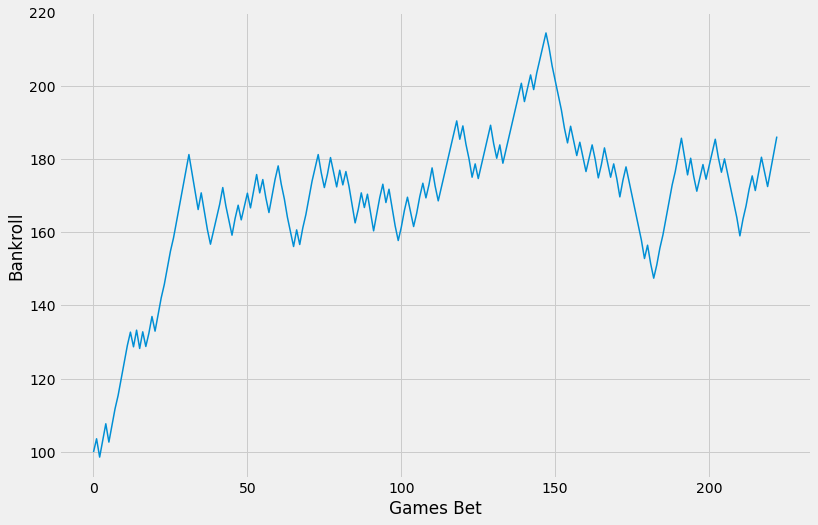

min balance: 98.63636363636364 
max balance: 214.36363636363544 
final balance: 190.6363636363623 
win percentage 56.95 
profit: 90.63636363636363 risk: 988.0 
ROI: 9.17

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SG

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.029985   
1  (2017, -, 2018)            0.53  0.513208            530 -0.019303   
2  (2018, -, 2019)            0.53  0.525547            411  0.010517   
3  (2019, -, 2020)            0.53  0.535211            355  0.021087   
4  (2021, -, 2021)            0.53  0.569507            223  0.091737   

     profits  
0  65.636364  
1 -47.909091  
2  19.909091  
3  34.181818  
4  90.636364

In [663]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


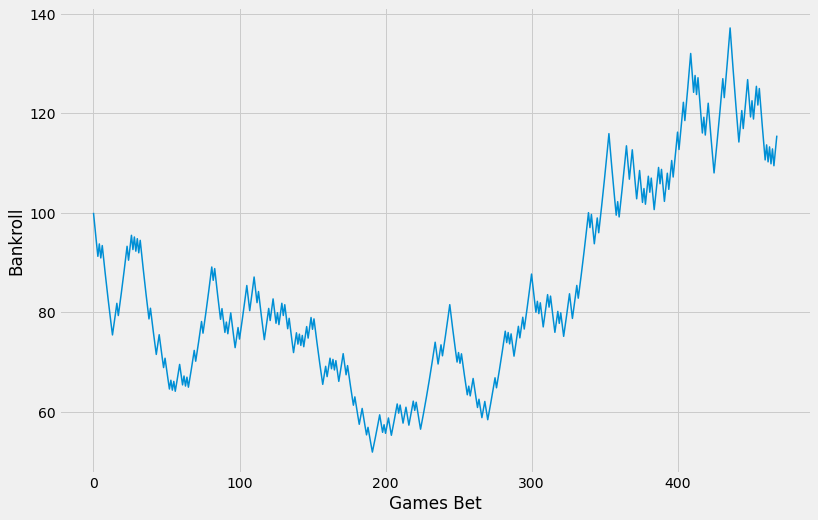

min balance: 51.95931418569775 
max balance: 137.1196961017868 
final balance: 118.65264767409444 
win percentage 53.73 
profit: 18.652647674094396 risk: 1192.5157733411133 
ROI: 1.5599999999999998
1
test set 1: 2017-10-28 - 2018-06-08


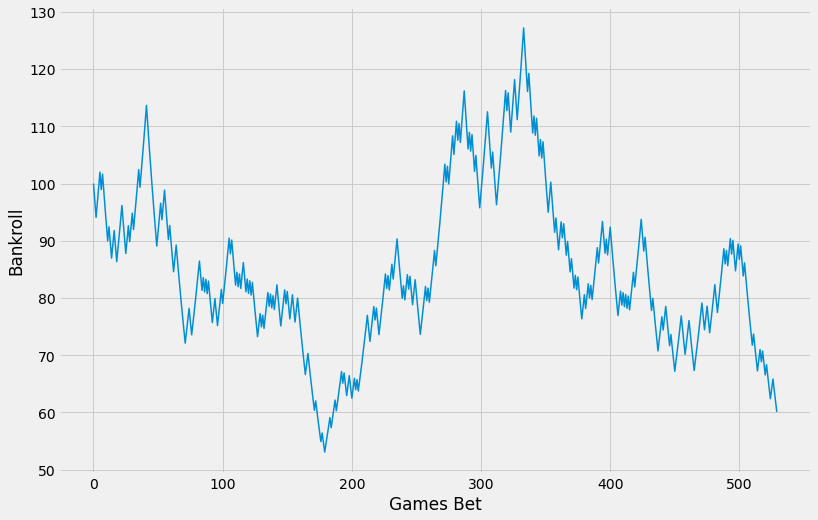

min balance: 53.078477196476335 
max balance: 127.18206300089665 
final balance: 58.29532195061766 
win percentage 51.32 
profit: -41.70467804938244 risk: 1350.6986843431337 
ROI: -3.09
2
test set 1: 2018-10-26 - 2019-06-13


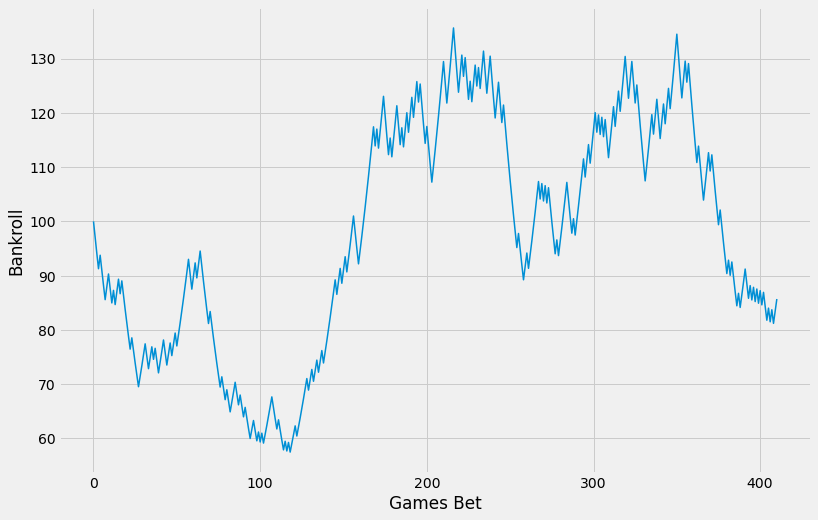

min balance: 57.47882989311353 
max balance: 135.63678545005874 
final balance: 88.02620525821162 
win percentage 52.55 
profit: -11.973794741788538 risk: 1205.5090846965707 
ROI: -0.9900000000000001
3
test set 1: 2019-11-01 - 2020-10-11


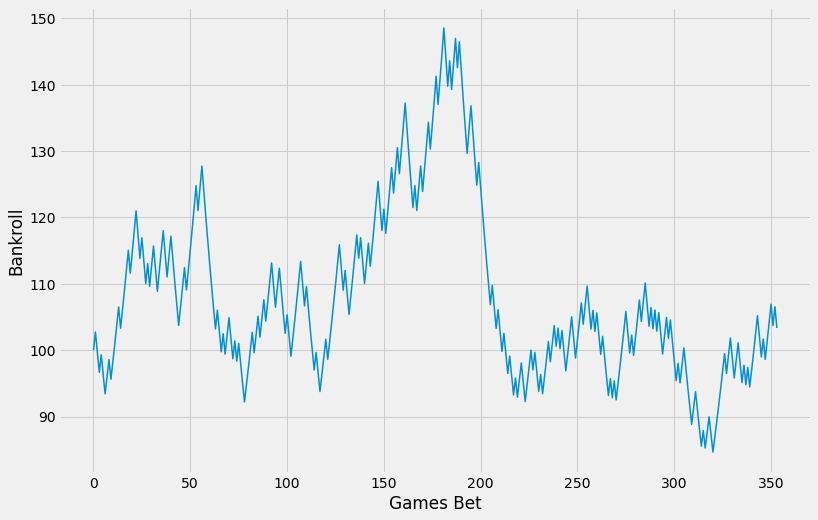

min balance: 84.64415680167593 
max balance: 148.53485625163472 
final balance: 106.15598328445795 
win percentage 53.39 
profit: 6.155983284457989 risk: 1146.171180097704 
ROI: 0.54
4
test set 1: 2021-01-01 - 2021-07-20


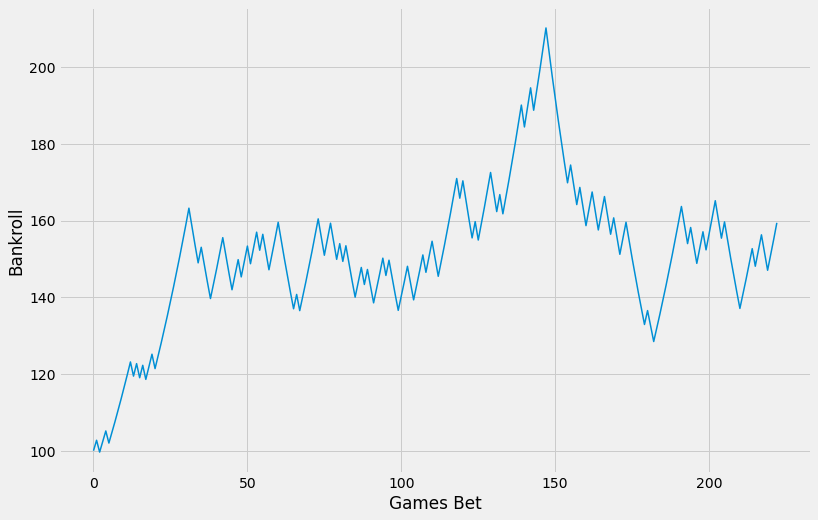

min balance: 99.64545454545456 
max balance: 210.19439280369414 
final balance: 163.74867588537154 
win percentage 56.95 
profit: 63.748675885371426 risk: 1011.0410842746564 
ROI: 6.3100000000000005

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                      

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.537313            469  0.015641   
1  (2017, -, 2018)            0.53  0.513208            530 -0.030876   
2  (2018, -, 2019)            0.53  0.525547            411 -0.009933   
3  (2019, -, 2020)            0.53  0.533898            354  0.005371   
4  (2021, -, 2021)            0.53  0.569507            223  0.063053   

     profits  
0  18.652648  
1 -41.704678  
2 -11.973795  
3   6.155983  
4  63.748676

In [664]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_2(select_bets, unit_pct=0.03)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

0
test set 1: 2016-11-04 - 2017-06-12


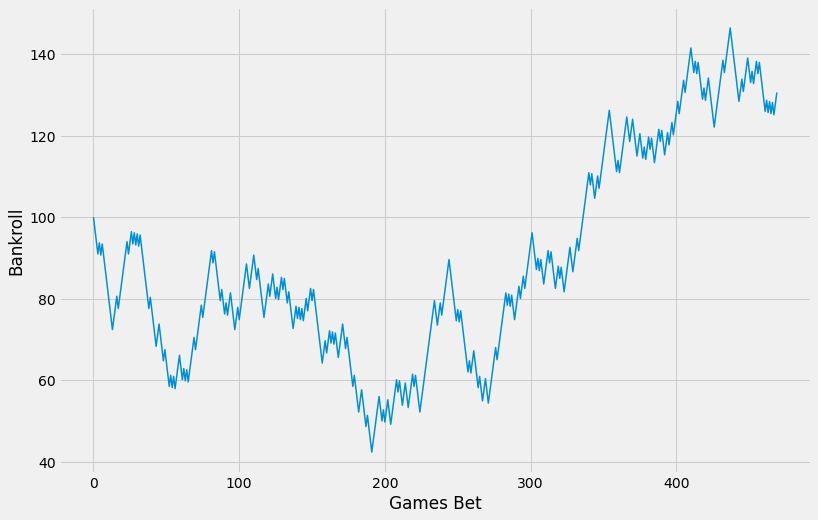

min balance: 42.45454545454595 
max balance: 146.3636363636373 
final balance: 133.27272727272813 
win percentage 53.620000000000005 
profit: 33.27272727272725 risk: 1410.0 
ROI: 2.36
1
test set 1: 2017-10-28 - 2018-06-08


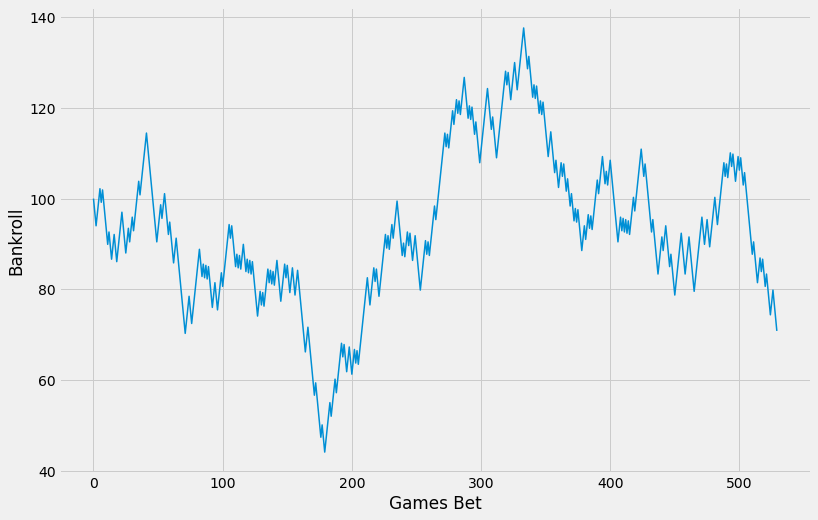

min balance: 44.09090909090962 
max balance: 137.63636363636468 
final balance: 67.81818181818343 
win percentage 51.32 
profit: -32.181818181818244 risk: 1590.0 
ROI: -2.02
2
test set 1: 2018-10-26 - 2019-06-13


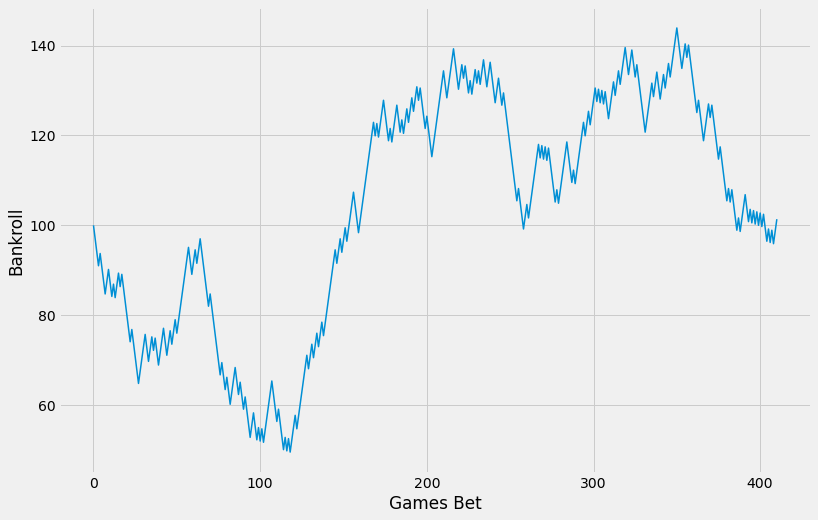

min balance: 49.54545454545478 
max balance: 143.9090909090913 
final balance: 104.0909090909096 
win percentage 52.55 
profit: 4.090909090909008 risk: 1233.0 
ROI: 0.33
3
test set 1: 2019-11-01 - 2020-10-11


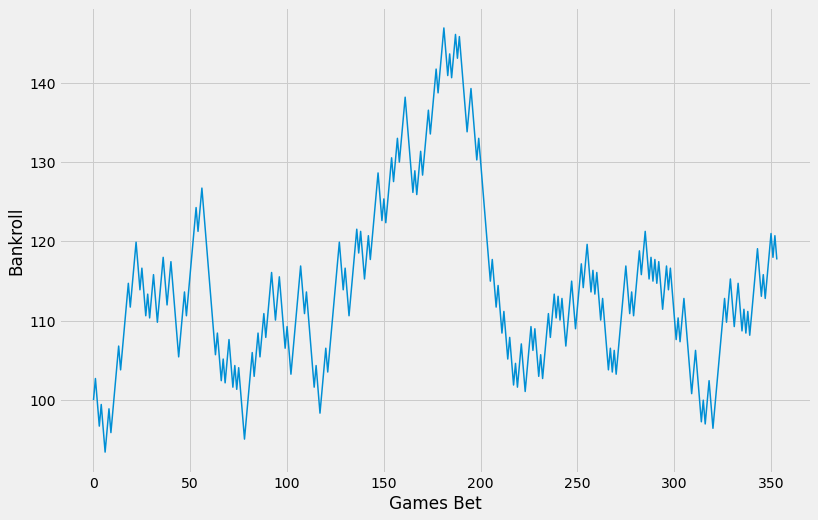

min balance: 93.45454545454547 
max balance: 146.90909090909133 
final balance: 120.45454545454633 
win percentage 53.39 
profit: 20.454545454545382 risk: 1062.0 
ROI: 1.9300000000000002
4
test set 1: 2021-01-01 - 2021-07-20


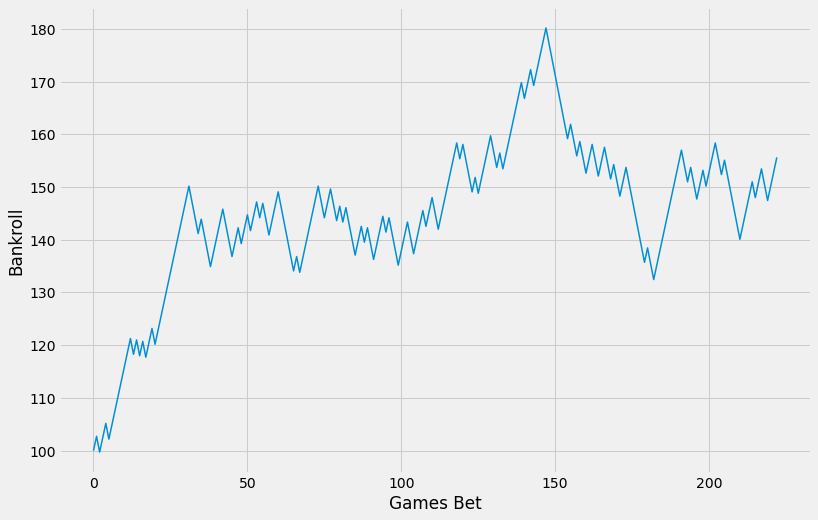

min balance: 99.72727272727273 
max balance: 180.1818181818177 
final balance: 158.3636363636356 
win percentage 56.95 
profit: 58.36363636363632 risk: 669.0 
ROI: 8.72

 StackingClassifier(estimators=[('log',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logreg',
                                                 LogisticRegression(C=0.001258237256125393,
                                                                    max_iter=10000,
                                                                    random_state=22,
                                                                    solver='saga',
                                                                    verbose=1))])),
                               ('sgd',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('sgd',
                                                 SGD

season  best_threshold  win_pcts  num_games_bet      rois  \
0  (2016, -, 2017)            0.53  0.536170            470  0.023598   
1  (2017, -, 2018)            0.53  0.513208            530 -0.020240   
2  (2018, -, 2019)            0.53  0.525547            411  0.003318   
3  (2019, -, 2020)            0.53  0.533898            354  0.019260   
4  (2021, -, 2021)            0.53  0.569507            223  0.087240   

     profits  
0  33.272727  
1 -32.181818  
2   4.090909  
3  20.454545  
4  58.363636

In [665]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_1(select_bets, unit_size=3)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


## Make Predictions

ETL Pipeline

### Update Date

In [91]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [92]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [105]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df





In [94]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

SEASON     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0    2021-22  1610612744               GSW   Golden State Warriors   
1    2021-22  1610612747               LAL      Los Angeles Lakers   
2    2021-22  1610612751               BKN           Brooklyn Nets   
3    2021-22  1610612749               MIL         Milwaukee Bucks   
4    2021-22  1610612766               CHA       Charlotte Hornets   
5    2021-22  1610612754               IND          Indiana Pacers   
6    2021-22  1610612741               CHI           Chicago Bulls   
7    2021-22  1610612765               DET         Detroit Pistons   
8    2021-22  1610612764               WAS      Washington Wizards   
9    2021-22  1610612761               TOR         Toronto Raptors   
10   2021-22  1610612755               PHI      Philadelphia 76ers   
11   2021-22  1610612740               NOP    New Orleans Pelicans   
12   2021-22  1610612763               MEM       Memphis Grizzlies   
13   2021-22  1610612739               CLE     Cleveland Cavaliers   
14   2021-22  1610612750               MIN  Minnesota Timberwolves   
15   2021-22  1610612745               HOU         Houston Rockets   
16   2021-22  1610612738               BOS          Boston Celtics   
17   2021-22  1610612752               NYK         New York Knicks   
18   2021-22  1610612759               SAS       San Antonio Spurs   
19   2021-22  1610612753               ORL           Orlando Magic   
20   2021-22  1610612756               PHX            Phoenix Suns   
21   2021-22  1610612743               DEN          Denver Nuggets   
22   2021-22  1610612758               SAC        Sacramento Kings   
23   2021-22  1610612757               POR  Portland Trail Blazers   
24   2021-22  1610612762               UTA               Utah Jazz   
25   2021-22  1610612760               OKC   Oklahoma City Thunder   
26   2021-22  1610612742               DAL        Dallas Mavericks   
27   2021-22  1610612737               ATL           Atlanta Hawks   
28   2021-22  1610612749               MIL         Milwaukee Bucks   
29   2021-22  1610612748               MIA              Miami Heat   
30   2021-22  1610612746               LAC             LA Clippers   
31   2021-22  1610612744               GSW   Golden State Warriors   
32   2021-22  1610612764               WAS      Washington Wizards   
33   2021-22  1610612754               IND          Indiana Pacers   
34   2021-22  1610612755               PHI      Philadelphia 76ers   
35   2021-22  1610612751               BKN           Brooklyn Nets   
36   2021-22  1610612761               TOR         Toronto Raptors   
37   2021-22  1610612738               BOS          Boston Celtics   
38   2021-22  1610612753               ORL           Orlando Magic   
39   2021-22  1610612752               NYK         New York Knicks   
40   2021-22  1610612766               CHA       Charlotte Hornets   
41   2021-22  1610612739               CLE     Cleveland Cavaliers   
42   2021-22  1610612740               NOP    New Orleans Pelicans   
43   2021-22  1610612741               CHI           Chicago Bulls   
44   2021-22  1610612760               OKC   Oklahoma City Thunder   
45   2021-22  1610612745               HOU         Houston Rockets   
46   2021-22  1610612759               SAS       San Antonio Spurs   
47   2021-22  1610612743               DEN          Denver Nuggets   
48   2021-22  1610612756               PHX            Phoenix Suns   
49   2021-22  1610612747               LAL      Los Angeles Lakers   
50   2021-22  1610612762               UTA               Utah Jazz   
51   2021-22  1610612758               SAC        Sacramento Kings   
52   2021-22  1610612737               ATL           Atlanta Hawks   
53   2021-22  1610612739               CLE     Cleveland Cavaliers   
54   2021-22  1610612754               IND          Indiana Pacers   
55   2021-22  1610612748               MIA              Miami Heat   
56   2021-22  16

In [95]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [124]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612744                    GSW   Golden State Warriors   
1       2021-22    1610612744                    GSW   Golden State Warriors   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612744                    GSW   Golden State Warriors   
4       2021-22    1610612747                    LAL      Los Angeles Lakers   
5       2021-22    1610612747                    LAL      Los Angeles Lakers   
6       2021-22    1610612747                    LAL      Los Angeles Lakers   
7       2021-22    1610612747                    LAL      Los Angeles Lakers   
8       2021-22    1610612751                    BKN           Brooklyn Nets   
9       2021-22    1610612751                    BKN           Brooklyn Nets   
10      2021-22    1610612751                    BKN           Brooklyn Nets   
11      2021-22    1610612751                    BKN           Brooklyn Nets   
12      2021-22    1610612749                    MIL         Milwaukee Bucks   
13      2021-22    1610612749                    MIL         Milwaukee Bucks   
14      2021-22    1610612749                    MIL         Milwaukee Bucks   
15      2021-22    1610612749                    MIL         Milwaukee Bucks   
16      2021-22    1610612766                    CHA       Charlotte Hornets   
17      2021-22    1610612766                    CHA       Charlotte Hornets   
18      2021-22    1610612766                    CHA       Charlotte Hornets   
19      2021-22    1610612766                    CHA       Charlotte Hornets   
20      2021-22    1610612754                    IND          Indiana Pacers   
21      2021-22    1610612754                    IND          Indiana Pacers   
22      2021-22    1610612754                    IND          Indiana Pacers   
23      2021-22    1610612754                    IND          Indiana Pacers   
24      2021-22    1610612741                    CHI           Chicago Bulls   
25      2021-22    1610612741                    CHI           Chicago Bulls   
26      2021-22    1610612741                    CHI           Chicago Bulls   
27      2021-22    1610612741                    CHI           Chicago Bulls   
28      2021-22    1610612765                    DET         Detroit Pistons   
29      2021-22    1610612765                    DET         Detroit Pistons   
30      2021-22    1610612765                    DET         Detroit Pistons   
31      2021-22    1610612764                    WAS      Washington Wizards   
32      2021-22    1610612764                    WAS      Washington Wizards   
33      2021-22    1610612764                    WAS      Washington Wizards   
34      2021-22    1610612761                    TOR         Toronto Raptors   
35      2021-22    1610612761                    TOR         Toronto Raptors   
36      2021-22    1610612761                    TOR         Toronto Raptors   
37      2021-22    1610612761                    TOR         Toronto Raptors   
38      2021-22    1610612755                    PHI      Philadelphia 76ers   
39      2021-22    1610612755                    PHI      Philadelphia 76ers   
40      2021-22    1610612755                    PHI      Philadelphia 76ers   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612740                    NOP    New Orleans Pelicans   
44      2021-22    1610612740                    NOP    New Orleans Pelicans   
45      2021-22    1610612740                    NOP    New Orleans Pelicans   
46      2021-22    1610612763                    MEM       Memphis Grizzlies   
47      2021-22    1610612763                    MEM       Memphis Grizzlies   
48      2021-22    1610612763                    MEM       Memphis Grizzlies   
49  

In [96]:
from datetime import date
date.today()

datetime.date(2021, 10, 29)

In [97]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]


In [98]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=elo_final_2020.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [251]:
team_avgs_21

SEASON_team  TEAM_ID_team TEAM_ABBREVIATION_team          TEAM_NAME_team  \
0       2021-22    1610612751                    BKN           Brooklyn Nets   
1       2021-22    1610612749                    MIL         Milwaukee Bucks   
2       2021-22    1610612744                    GSW   Golden State Warriors   
3       2021-22    1610612747                    LAL      Los Angeles Lakers   
4       2021-22    1610612754                    IND          Indiana Pacers   
5       2021-22    1610612766                    CHA       Charlotte Hornets   
6       2021-22    1610612741                    CHI           Chicago Bulls   
7       2021-22    1610612765                    DET         Detroit Pistons   
8       2021-22    1610612738                    BOS          Boston Celtics   
9       2021-22    1610612752                    NYK         New York Knicks   
10      2021-22    1610612764                    WAS      Washington Wizards   
11      2021-22    1610612761                    TOR         Toronto Raptors   
12      2021-22    1610612739                    CLE     Cleveland Cavaliers   
13      2021-22    1610612763                    MEM       Memphis Grizzlies   
14      2021-22    1610612745                    HOU         Houston Rockets   
15      2021-22    1610612750                    MIN  Minnesota Timberwolves   
16      2021-22    1610612755                    PHI      Philadelphia 76ers   
17      2021-22    1610612740                    NOP    New Orleans Pelicans   
18      2021-22    1610612753                    ORL           Orlando Magic   
19      2021-22    1610612759                    SAS       San Antonio Spurs   
20      2021-22    1610612760                    OKC   Oklahoma City Thunder   
21      2021-22    1610612762                    UTA               Utah Jazz   
22      2021-22    1610612743                    DEN          Denver Nuggets   
23      2021-22    1610612756                    PHX            Phoenix Suns   
24      2021-22    1610612758                    SAC        Sacramento Kings   
25      2021-22    1610612757                    POR  Portland Trail Blazers   
26      2021-22    1610612742                    DAL        Dallas Mavericks   
27      2021-22    1610612737                    ATL           Atlanta Hawks   
28      2021-22    1610612749                    MIL         Milwaukee Bucks   
29      2021-22    1610612748                    MIA              Miami Heat   
30      2021-22    1610612746                    LAC             LA Clippers   
31      2021-22    1610612744                    GSW   Golden State Warriors   
32      2021-22    1610612766                    CHA       Charlotte Hornets   
33      2021-22    1610612739                    CLE     Cleveland Cavaliers   
34      2021-22    1610612752                    NYK         New York Knicks   
35      2021-22    1610612753                    ORL           Orlando Magic   
36      2021-22    1610612754                    IND          Indiana Pacers   
37      2021-22    1610612764                    WAS      Washington Wizards   
38      2021-22    1610612761                    TOR         Toronto Raptors   
39      2021-22    1610612738                    BOS          Boston Celtics   
40      2021-22    1610612751                    BKN           Brooklyn Nets   
41      2021-22    1610612755                    PHI      Philadelphia 76ers   
42      2021-22    1610612740                    NOP    New Orleans Pelicans   
43      2021-22    1610612741                    CHI           Chicago Bulls   
44      2021-22    1610612760                    OKC   Oklahoma City Thunder   
45      2021-22    1610612745                    HOU         Houston Rockets   
46      2021-22    1610612759                    SAS       San Antonio Spurs   
47      2021-22    1610612743                    DEN          Denver Nuggets   
48      2021-22    1610612756                    PHX            Phoenix Suns   
49  

In [100]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread, home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
    home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
    away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
    new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = away_spread 
    diffs.at[1, 'SPREAD_team'] = home_spread
    
    diffs.at[0, 'ML_team'] = away_ml
    diffs.at[1, 'ML_team'] = home_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


### Make Predictions

In [102]:

def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_spreads = get_days_spreads(todays_date)
    todays_spreads = clean_spreads_df(todays_spreads)

    todays_mls = get_days_moneylines(todays_date)
    todays_mls = clean_moneyline_df(todays_mls)
    
    todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['HOME_TEAM']
        away_team = row['AWAY_TEAM']
        home_spread = row['HIGHEST_HOME_SPREAD'] 
        away_spread = row['HIGHEST_AWAY_SPREAD']
        home_ml = row['HIGHEST_HOME_ML']
        away_ml = row['HIGHEST_AWAY_ML']
        game_date = row['GM_DATE']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [121]:
# X_full = pd.concat([X_train, X_test])
# y_full = pd.concat([y_train, y_test])

# X_full.shape, y_full.shape

# estimators = [('log', best_lr), ('sgd', best_sgd),
#               ('svc', best_svc), ('lgbc', best_lgbc),
#              ('rf', best_rf), ('knn', best_knn)]


# final_stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
#                                  n_jobs=-1, verbose=1)


# final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model'

joblib.dump(final_stacked_clf, filename)

['../models/finalized_stacked_model']

In [108]:
X_train

RECORD_team_diff  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  \
15450         -0.473684       -3.473684       10.105263       -3.473684   
15451          0.473684        3.473684      -10.105263        3.473684   
15466          0.000000       -0.157895       10.368421        2.210526   
15467          0.000000        0.157895      -10.368421       -2.210526   
15474          0.526316        5.105263       11.052632       -2.210526   
...                 ...             ...             ...             ...   
41189          0.143834       -0.786681       -0.582086        1.593153   
41190          0.029448       -2.308044       -1.923904        1.833843   
41191         -0.029448        2.308044        1.923904       -1.833843   
41192          0.073498        3.277257        2.431520       -2.150465   
41193         -0.073498       -3.277257       -2.431520        2.150465   

       FG3A_team_diff  FTM_team_diff  FTA_team_diff  OREB_team_diff  \
15450       -1.684211      -0.263158      -2.789474       10.052632   
15451        1.684211       0.263158       2.789474      -10.052632   
15466        4.736842       0.526316       4.157895        6.315789   
15467       -4.736842      -0.526316      -4.157895       -6.315789   
15474       -7.842105       0.000000       0.263158       -1.368421   
...               ...            ...            ...             ...   
41189        3.217412       0.922036       0.587392       -0.807284   
41190        4.795702       1.329841       0.828656       -0.226543   
41191       -4.795702      -1.329841      -0.828656        0.226543   
41192       -5.516144      -0.696841      -0.445778        0.103885   
41193        5.516144       0.696841       0.445778       -0.103885   

       DREB_team_diff  REB_team_diff  AST_team_diff  STL_team_diff  \
15450        3.526316      13.578947      -8.473684       1.578947   
15451       -3.526316     -13.578947       8.473684      -1.578947   
15466       -1.578947       4.736842      -5.526316       3.000000   
15467        1.578947      -4.736842       5.526316      -3.000000   
15474        0.947368      -0.421053       2.842105       2.052632   
...               ...            ...            ...            ...   
41189        0.755402      -0.051882       3.479550       0.447166   
41190        0.379854       0.153312       3.431598      -0.097563   
41191       -0.379854      -0.153312      -3.431598       0.097563   
41192        0.758152       0.862037      -2.588423       0.787820   
41193       -0.758152      -0.862037       2.588423      -0.787820   

       BLK_team_diff  TOV_team_diff  PF_team_diff  PTS_team_diff  \
15450      -0.368421       2.526316     -5.263158     -17.631579   
15451       0.368421      -2.526316      5.263158      17.631579   
15466      -1.000000       0.421053      7.421053       6.842105   
15467       1.000000      -0.421053     -7.421053      -6.842105   
15474      -0.578947       0.263158     -1.315789       3.578947   
...              ...            ...           ...            ...   
41189       1.222646       1.022656      1.334851       4.128134   
41190       1.100376       1.020388      1.101360       2.215282   
41191      -1.100376      -1.020388     -1.101360      -2.215282   
41192      -0.590329      -1.118352     -0.991219      -0.593722   
41193       0.590329       1.118352      0.991219       0.593722   

       PLUS_MINUS_team_diff  E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  \
15450            -21.000000              -17.952632                1.868421   
15451             21.000000               17.952632               -1.868421   
15466              3.315789               -4.731579               -6.742105   
15467             -3.315789                4.731579                6.742105   
15474             10.789474               -1.815789              -11.368421   
...                     ...                     ...                     ...   
41189             -0.612905               

In [123]:
final_stacked_model = joblib.load('../models/finalized_stacked_model')


final_stacked_model.predict(X_train)

array([1, 0, 0, ..., 1, 1, 0])

In [126]:
def main(conn, season, model, prev_season_elo):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [127]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/final_elo_ratings_2020")
todays_predictions = main(connection, 2021, final_stacked_clf, prev_season_elo)

connection.close()

todays_predictions

progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.31s/it]
progress:: 154it [00:00, 4529.64it/s]


game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-30       WAS       BOS         -4.0          0.506587   
1   2021-10-30       DET       ORL         -8.0          0.520615   
2   2021-10-30       NOP       NYK          6.0          0.446485   
3   2021-10-30       IND       TOR         -4.5          0.467039   
4   2021-10-30       PHI       ATL         -5.5          0.557671   
5   2021-10-30       CHI       UTA          4.5          0.501391   
6   2021-10-30       MIL       SAS         -7.0          0.494550   
7   2021-10-30       MEM       MIA         -3.0          0.500480   
8   2021-10-30       GSW       OKC        -14.5          0.530507   
9   2021-10-30       MIN       DEN         -3.0          0.551326   
10  2021-10-30       PHX       CLE        -10.0          0.569496   

    away_cover_probs  home_cover_avg  
0           0.499518        0.503535  
1           0.471622        0.524496  
2           0.550445        0.448020  
3           0.532006        0.467516  
4           0.442400        0.557636  
5           0.500978        0.500206  
6           0.509464        0.492543  
7           0.500311        0.500085  
8           0.472792        0.528858  
9           0.451358        0.549984  
10          0.431999        0.568748

In [117]:
todays_predictions.to_csv("../test_data.csv", index=False)

In [118]:
todays_predictions.to_csv("../test_data.csv", mode='a', header=False, index=False)

In [119]:
pd.read_csv('../test_data.csv')

game_date home_team away_team  home_spread  home_cover_probs  \
0   2021-10-29       TOR       ORL         -9.0          0.589156   
1   2021-10-29       MIA       CHA         -8.5          0.502124   
2   2021-10-29       BKN       IND        -10.5          0.503996   
3   2021-10-29       NOP       SAC          3.5          0.433964   
4   2021-10-29       POR       LAC         -5.5          0.481502   
5   2021-10-29       DEN       DAL         -3.5          0.511928   
6   2021-10-29       LAL       CLE         -8.5          0.485542   
7   2021-10-29       TOR       ORL         -9.0          0.589156   
8   2021-10-29       MIA       CHA         -8.5          0.502124   
9   2021-10-29       BKN       IND        -10.5          0.503996   
10  2021-10-29       NOP       SAC          3.5          0.433964   
11  2021-10-29       POR       LAC         -5.5          0.481502   
12  2021-10-29       DEN       DAL         -3.5          0.511928   
13  2021-10-29       LAL       CLE         -8.5          0.485542   

    away_cover_probs  home_cover_avg  
0           0.413940        0.587608  
1           0.490751        0.505686  
2           0.496721        0.503638  
3           0.561797        0.436084  
4           0.523630        0.478936  
5           0.489419        0.511255  
6           0.509621        0.487960  
7           0.413940        0.587608  
8           0.490751        0.505686  
9           0.496721        0.503638  
10          0.561797        0.436084  
11          0.523630        0.478936  
12          0.489419        0.511255  
13          0.509621        0.487960

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df